<style>
    .center {
    margin-left: auto;
    margin-right: auto;
    }
</style>


<table class="center">
    <tr>
        <td>Module Code</td>
        <td>CSMAD21</td>
    </tr>
    <tr>
        <td>Assignment Report Title</td>
        <td>Applied Data Science with Python</td>
    </tr>
    <tr>
        <td>Student Number</td>
        <td>29818010</td>
    </tr>
    <tr>
        <td>Hours spent for this assignment</td>
        <td>40 hours</td>
    </tr>
    <tr>
        <td>Assignment Evaluation</td>
        <td>
            <ul>
                <li> Various amounts of tasks gives practice on a wide range of methods. </li>
                <li> Classification or Regression end result could have been one of the tasks. </li>
                <li> Network Analysis data was had a lot of leaf nodes. Greater number of higher degree nodes would have made the dataset more interesting. </li>
            </ul>
        </td> 
</table>

---
# Task 1 - Exploratory Data Analysis

## Imports and Settings

In [1]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Imports
from typing import *
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples


In [2]:
# Matplotlib Settings
plt.style.use(["seaborn-ticks"])
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (10, 7.5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
sns.set(rc=dict(plt.rcParams))

# Output settings
pd.set_option('display.float_format', lambda x: f"{x: 5.5f}")
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

## Read Data

### Implementation Details
#### Column dtypes

- Given the data description in the pdf outlining the tasks, the dtypes of the columns are defined as following:

<style>
    .center {
    margin-left: auto;
    margin-right: auto;
    }
</style>


<table class="center">
    <tr>
        <td>trip_id</td>
        <td>int64</td>
    </tr>
    <tr>
        <td>duration</td>
        <td>int64</td>
    </tr>
    <tr>
        <td>start_time</td>
        <td>string</td>
    </tr>
    <tr>
        <td>end_time</td>
        <td>string</td>
    </tr>
    <tr>
        <td>start_station</td>
        <td>category</td>
    </tr>
    <tr>
        <td>end_station</td>
        <td>category</td>
    </tr>
    <tr>
        <td>bike_id</td>
        <td>object</td>
    </tr>
    <tr>
        <td>plan_duration</td>
        <td>category</td>
    </tr>
    <tr>
        <td>trip_route_category</td>
        <td>category</td>
    </tr>
    <tr>
        <td>passholder_type</td>
        <td>category</td>
    </tr>
    <tr>
        <td>bike_type</td>
        <td>category</td>
    </tr>
    <tr>
        <td>start_time</td>
        <td>datetime64[ns]</td>
    </tr>
    <tr>
        <td>end_time</td>
        <td>datetime64[ns]</td>
    </tr>
</table>

#### `read_data` Function
- Create a dictionary with column names as the keys and data type as the values.
- Pass the dictionary `dtype` parameter in `pd.read_csv` function while reading the file.
- For datetime columns, we use the `parse_dates` parameter and pass a list of datetime columns identified in the previous step. 
- We also exclude the latitude and longitude columns. This is because the start and end stations are available in the data, thus rendering the latitude and longitude columns not very helpful in this piece of work

Pandas by default assigns dtypes to variables. However this can be inaccurate and slow when the dataset is large. As a best practice, it is always good to define the dtypes before reading and pass it to `read_csv` function. 

In [3]:
def read_data(file_path: str, dtypes_: dict, exclude_fn: Callable = None) -> pd.DataFrame:
    """Read the CSV data with predefined data types for columns.

    Args:
        file_path (str): Path to file
        dtypes_ (dict): Dtypes of columns
        exclude_fn (Callable, optional): Function that excludes columns we do not want to read. Defaults to None.

    Returns:
        pd.DataFrame: DataFrame object with dtypes and data.
    """

    # Include all columns if exclude_fn is none
    if not exclude_fn:
        exclude_fn = lambda x: x
    df = pd.read_csv(file_path, dtype=dtypes_, parse_dates=['start_time', 'end_time'], usecols=exclude_fn)
    return df

# Dtypes list
numeric_dtypes = ['float64', 'int64']
dttime_dtypes = ['datetime64[ns]']
category_dtypes = ['object', 'category']

# Dtypes
dtypes_ = {
    "trip_id": "int64",
    "duration": "int64",
    "start_time": "string",
    "end_time": "string",
    "start_station": "category",
    "end_station": "category",
    "bike_id": "object",
    "plan_duration": "category",
    "trip_route_category": "category",
    "passholder_type": "category",
    "bike_type": "category",
}
# Exclude Columns
exclude_fn = lambda x: ('lat' not in x) and ('lon' not in x)
metro_df = read_data("./data/metro.csv", dtypes_, exclude_fn)

# Update dtypes to timestamps
dtypes_.update({"start_time": "datetime64[ns]", "end_time": "datetime64[ns]"})

## EDA on raw data

### DataFrame Statistics

In [4]:
metro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92124 entries, 0 to 92123
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trip_id              92124 non-null  int64         
 1   duration             92124 non-null  int64         
 2   start_time           92124 non-null  datetime64[ns]
 3   end_time             92124 non-null  datetime64[ns]
 4   start_station        92124 non-null  category      
 5   end_station          92124 non-null  category      
 6   bike_id              92124 non-null  object        
 7   plan_duration        92124 non-null  category      
 8   trip_route_category  92124 non-null  category      
 9   passholder_type      92124 non-null  category      
 10  bike_type            92124 non-null  category      
dtypes: category(6), datetime64[ns](2), int64(2), object(1)
memory usage: 4.2+ MB


In [5]:
print("Numeric columns summary statistics:")
metro_df.describe(include=numeric_dtypes).T


Numeric columns summary statistics:


count             mean            std              min  \
trip_id   92124.00000  127428624.99310  1524133.65894  124657107.00000   
duration  92124.00000         33.16859      129.05784          1.00000   

                      25%              50%              75%              max  
trip_id   126137540.50000  127491114.50000  128737946.25000  130387712.00000  
duration          6.00000         12.00000         22.00000       1440.00000

In [6]:
print("Categorical columns summary statistics:")
metro_df.describe(include=category_dtypes).T

Categorical columns summary statistics:


count unique           top   freq
start_station        92124    183          3005   4512
end_station          92124    183          3005   4649
bike_id              92124   2042         17584    397
plan_duration        92124      4            30  57182
trip_route_category  92124      2       One Way  76771
passholder_type      92124      6  Monthly Pass  57175
bike_type            92124      3      electric  46446

In [7]:
print("Categorical columns summary statistics:")
metro_df.describe(include=dttime_dtypes).T

Categorical columns summary statistics:


count unique                 top freq               first  \
start_time  92124  57274 2019-08-24 18:50:00    9 2019-07-01 00:04:00   
end_time    92124  55658 2019-09-27 08:28:00   16 2019-07-01 00:09:00   

                          last  
start_time 2019-09-30 23:58:00  
end_time   2019-10-02 12:04:00

#### Analysis

**Null Values**
- Using the `info()` function, we see that there are no null values in the data. 

**Numerical Columns**
- We can ignore the statistics of the `trip_id` column as this is a unique identifier.
- We see that the average duration for a cycle trip is **33.16 minutes**.

**Categorical Columns**
- We can ignore the statistics of the `bike_id` column as this is a unique identifier.
- We see that there are 183 start and end stations with station 3005 being the most used one for both starting and ending a trip.
- Most of the bookings are for One Way only.
- Most customers prefer a monthly pass to book rides. This is confirmed by the plan_duration column for which the 30 plan is the most frequent.
- It can be said that electric bikes are the most popular choice of bike.

### Univariate Analysis

- We perform univariate analysis by zooming into each column separately. This gives us an idea of the characterstics and distribution of each column.
- We ignore the id columns as these are just unique identifiers and do not contain any relevant statistical information.

#### Duration


Mean duration of each ride in the data is :  33.16859
Binning the values using np.hist, we get:
(array([89817,   950,   271,   144,    84,    91,    76,    82,    65,
         544]), array([   1. ,  144.9,  288.8,  432.7,  576.6,  720.5,  864.4, 1008.3,
       1152.2, 1296.1, 1440. ]))



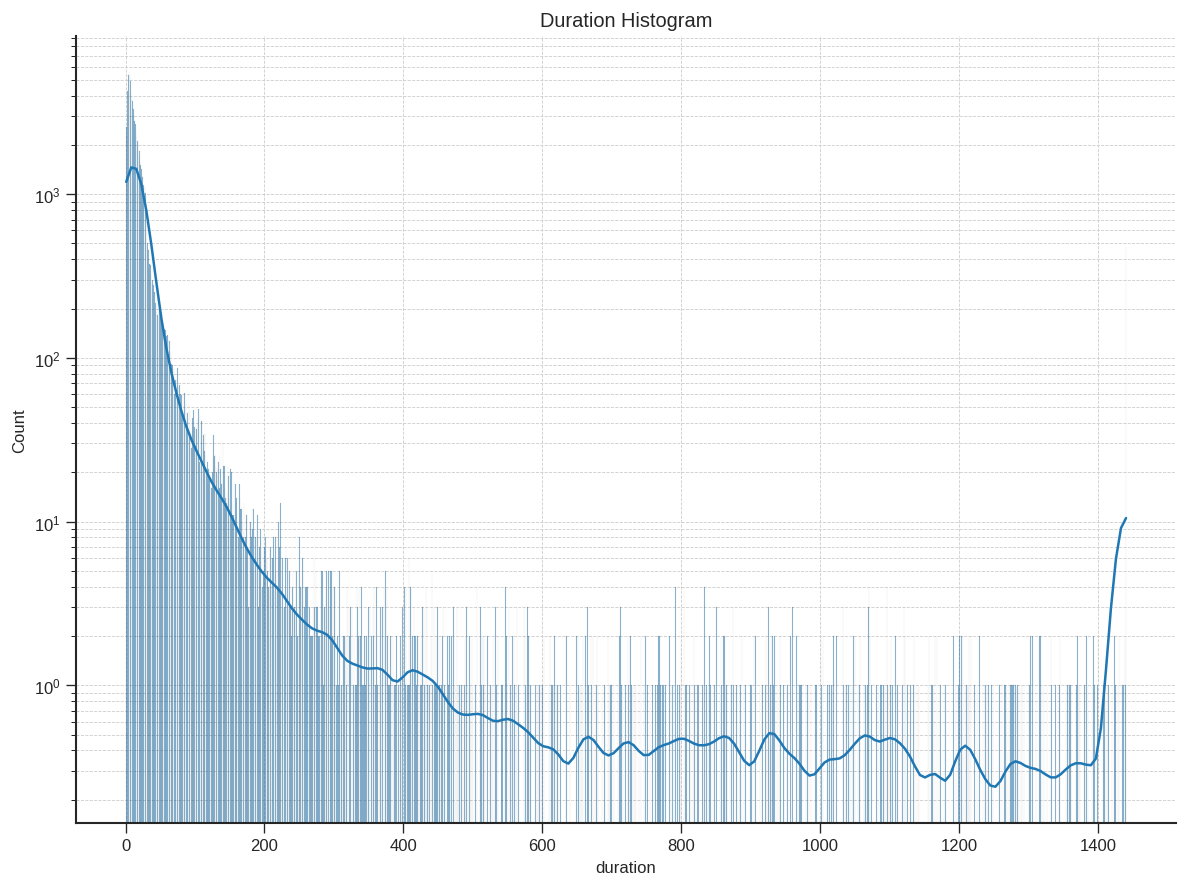

In [8]:
# Summary Statistics
str_ = f"""
Mean duration of each ride in the data is : {metro_df['duration'].mean(): 4.5f}
Binning the values using np.hist, we get:
{np.histogram(metro_df['duration'].values)}
"""
print(str_)

# Visualisation
sns.histplot(data=metro_df, x='duration', kde=True)
plt.yscale('log')
plt.title("Duration Histogram")
plt.show();

Here we see that the bins do not occur frequently and have a large range of values. Hence we would need to use a log scale to visualise the distribution of duration properly.
Using the graph above we see that most of the rides have a duration of 1-200 minutes.


#### start_station


Number of starting stations: 183
Most frequently occurring 10 start_stations: 
['3005', '3030', '3014', '4345', '3031', '3006', '3035', '4346', '3042', '3074']



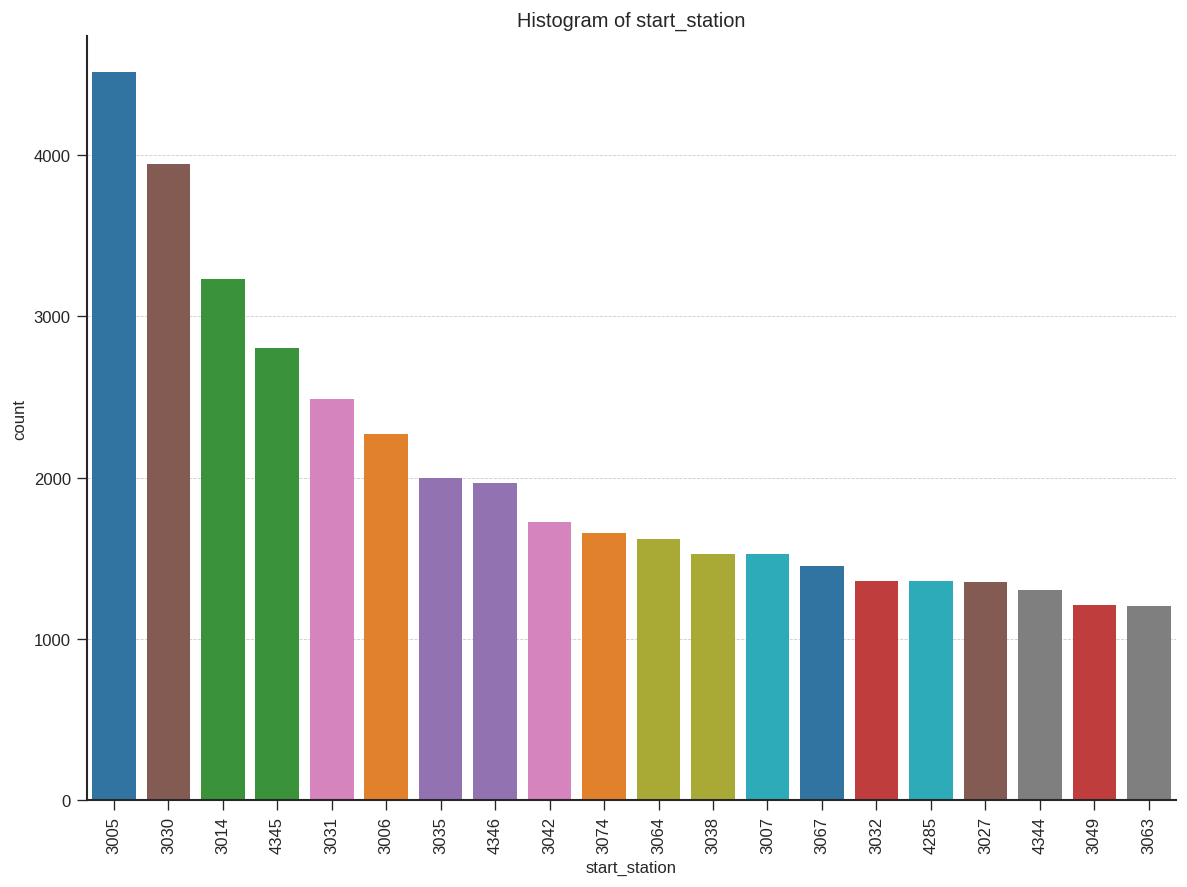

In [9]:
str_ = f"""
Number of starting stations: {metro_df['start_station'].nunique()}
Most frequently occurring 10 start_stations: 
{metro_df['start_station'].value_counts().iloc[:10].index.to_list()}
"""
print(str_)

col = "start_station"
ax = plt.gca()
cats = metro_df[col].value_counts()
palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
palette = list(map(lambda x: x[1], sorted(palette.items())))

# Create graph
sns.countplot(data=metro_df, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
ax.set_title(f"Histogram of {col}")
ax.tick_params(axis='x', rotation=90)

Since there are too many possible categories here, we plot only the 20 most occurring start_stations.
Looking at the graph above, we can see that station 3005 is the most popular starting point for bike rides with over 4000 rides originating from here.

#### end_station


Number of starting stations: 183
Most frequently occurring 10 end_stations: 
['3005', '3014', '3030', '4345', '3031', '3006', '3035', '3042', '4285', '3064']



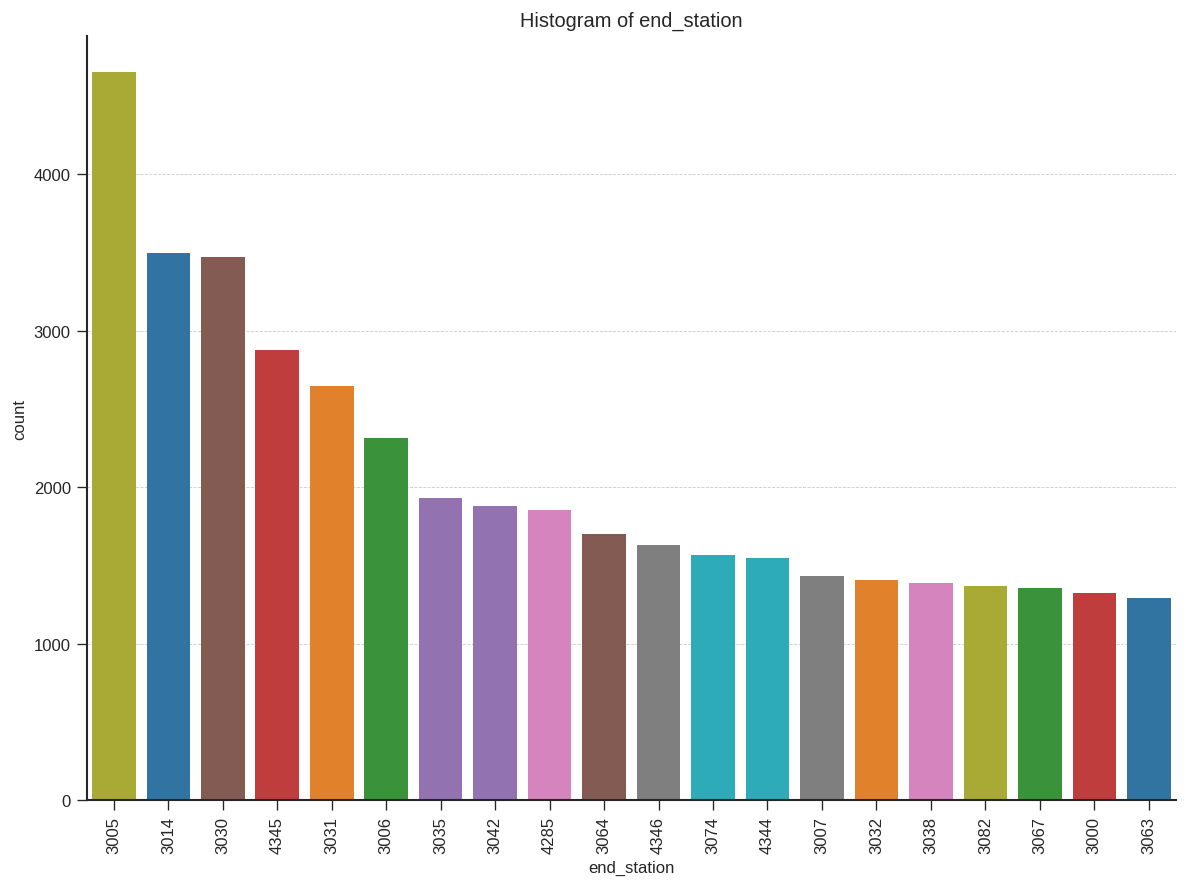

In [10]:
str_ = f"""
Number of starting stations: {metro_df['end_station'].nunique()}
Most frequently occurring 10 end_stations: 
{metro_df['end_station'].value_counts().iloc[:10].index.to_list()}
"""
print(str_)

col = "end_station"
ax = plt.gca()
cats = metro_df[col].value_counts()
palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
palette = list(map(lambda x: x[1], sorted(palette.items())))

# Create graph
sns.countplot(data=metro_df, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
ax.set_title(f"Histogram of {col}")
ax.tick_params(axis='x', rotation=90)

Since there are too many possible categories here, we plot only the 20 most occurring end_stations.
Looking at the graph above, we can see that station 3005 is the most popular final point for bike rides with over 4000 rides ending from here.

#### plan_duration


Types of plan_duration: 4
Frequency of categories:
30     57182
1      24572
365    10324
999       46
Name: plan_duration, dtype: int64



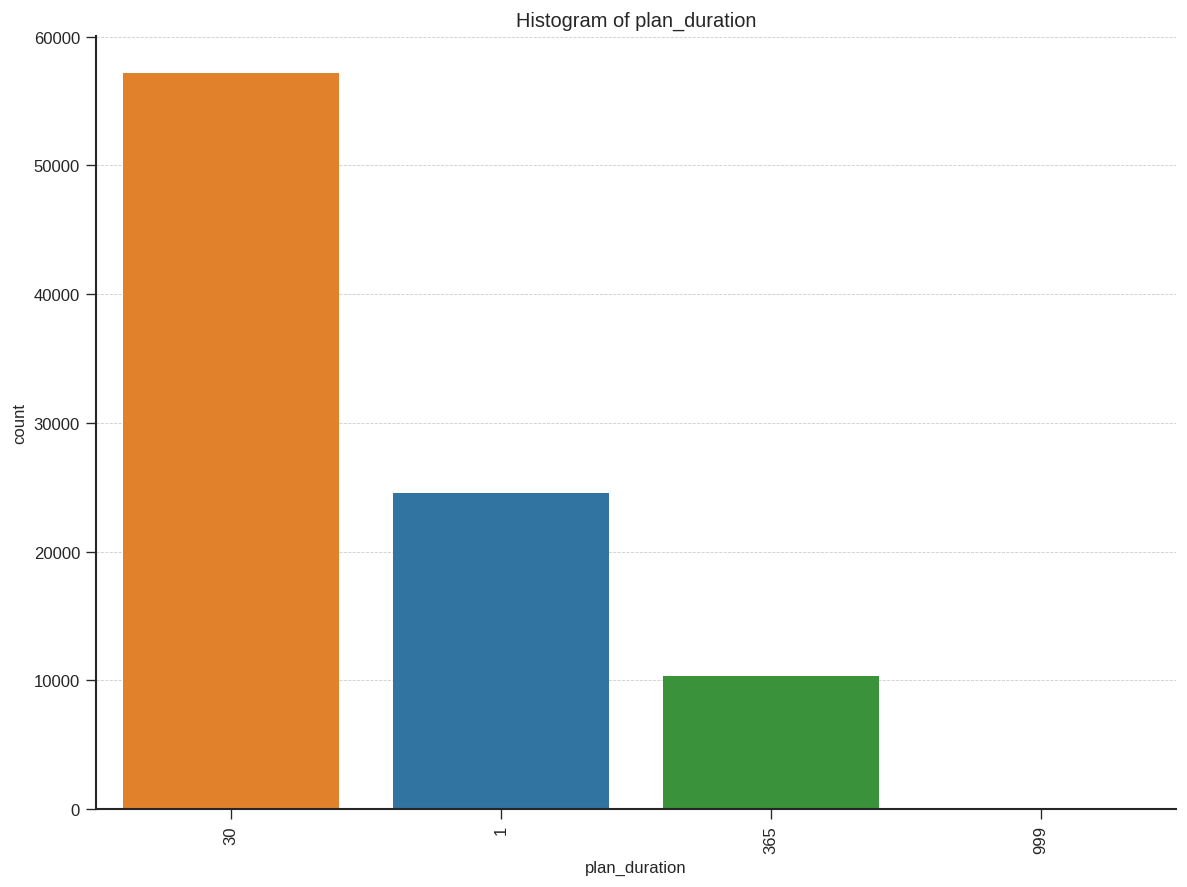

In [11]:
col = "plan_duration"

str_ = f"""
Types of plan_duration: {metro_df[col].nunique()}
Frequency of categories:
{metro_df[col].value_counts()}
"""
print(str_)


# Create graph
ax = plt.gca()
cats = metro_df[col].value_counts()
palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=len(cats))))
palette = list(map(lambda x: x[1], sorted(palette.items())))
sns.countplot(data=metro_df, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
ax.set_title(f"Histogram of {col}")
ax.tick_params(axis='x', rotation=90)

Here we see that there are 4 categories in plan_duration column. The 4th type can be ignored as it is just records inserted during API testing by developers and does not indicate real world data.

The 30-day/monthly plan is very popular among users with almost 60000 users preferring this plan type.

#### trip_route_category


Types of trip_route_category: 2
Frequency of categories:
One Way       76771
Round Trip    15353
Name: trip_route_category, dtype: int64



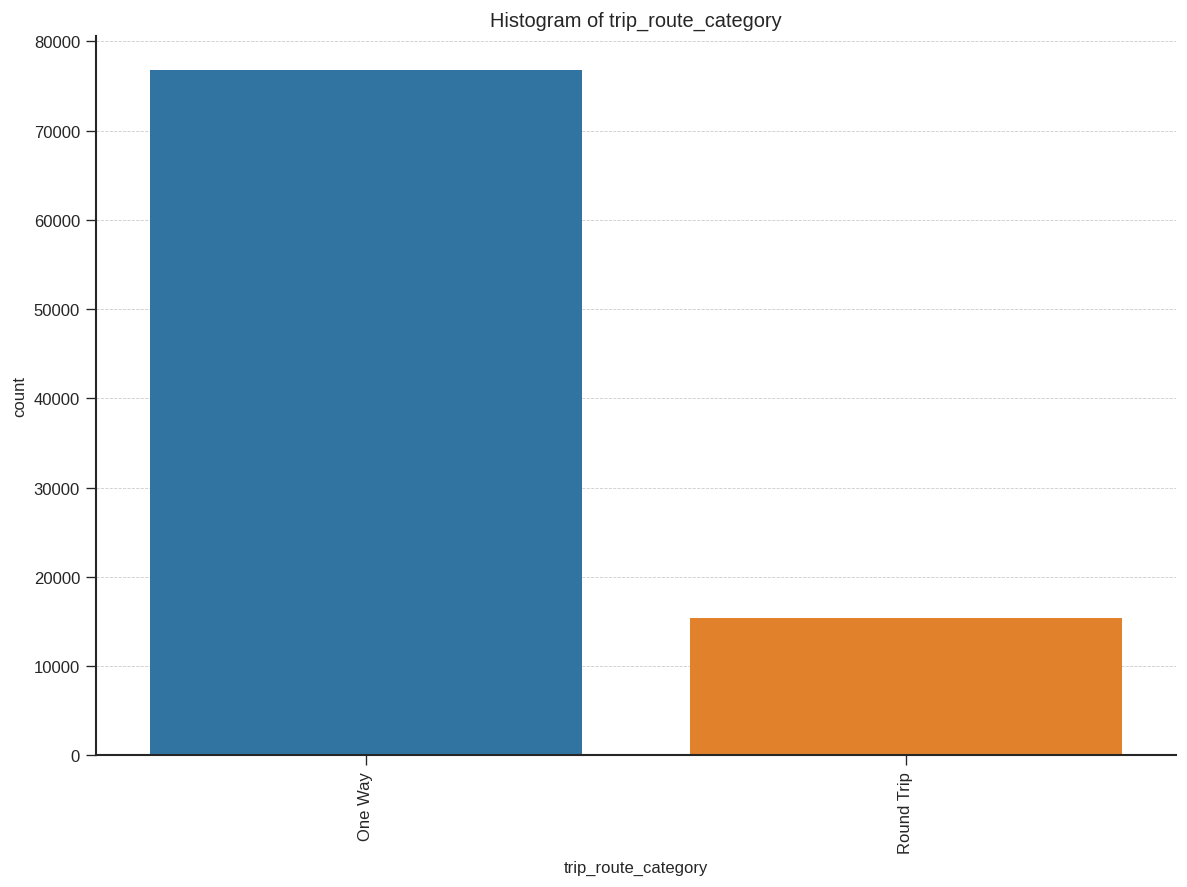

In [12]:
col = "trip_route_category"

str_ = f"""
Types of trip_route_category: {metro_df[col].nunique()}
Frequency of categories:
{metro_df[col].value_counts()}
"""
print(str_)


# Create graph
ax = plt.gca()
cats = metro_df[col].value_counts()
palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=len(cats))))
palette = list(map(lambda x: x[1], sorted(palette.items())))
sns.countplot(data=metro_df, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
ax.set_title(f"Histogram of {col}")
ax.tick_params(axis='x', rotation=90)

Here we see that there are 2 categories in trip_route_category column - One Way and Round Trip. We can see that almost 80% of consumers of the bike rental service prefer single trips over round trips. 

#### passholder_type


Types of passholder_type: 6
Frequency of categories:
Monthly Pass    57175
Walk-up         23502
Annual Pass      6220
One Day Pass     5175
Testing            46
Flex Pass           6
Name: passholder_type, dtype: int64



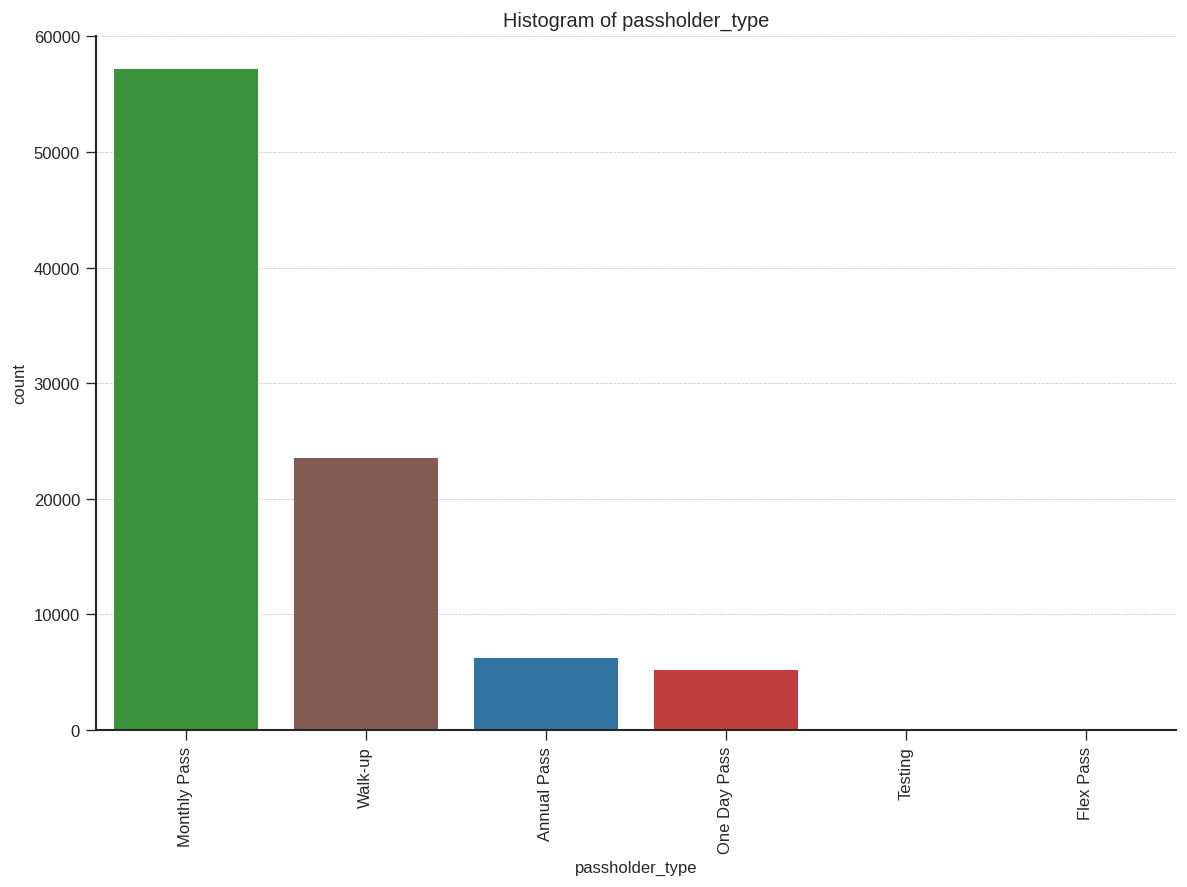

In [13]:
col = "passholder_type"

str_ = f"""
Types of passholder_type: {metro_df[col].nunique()}
Frequency of categories:
{metro_df[col].value_counts()}
"""
print(str_)


# Create graph
ax = plt.gca()
cats = metro_df[col].value_counts()
palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=len(cats))))
palette = list(map(lambda x: x[1], sorted(palette.items())))
sns.countplot(data=metro_df, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
ax.set_title(f"Histogram of {col}")
ax.tick_params(axis='x', rotation=90)

Here we see that there are 6 categories in passholder_type column. The `testing` type can be ignored as it is just records inserted during API testing by developers and does not indicate real world data.

The monthly plan is very popular among users with almost 60000 users preferring this plan type. This confirms our previous hypothesis while analysing the `plan_duration` column.

#### bike_type


Types of bike_type: 3
Frequency of categories:
electric    46446
standard    29477
smart       16201
Name: bike_type, dtype: int64



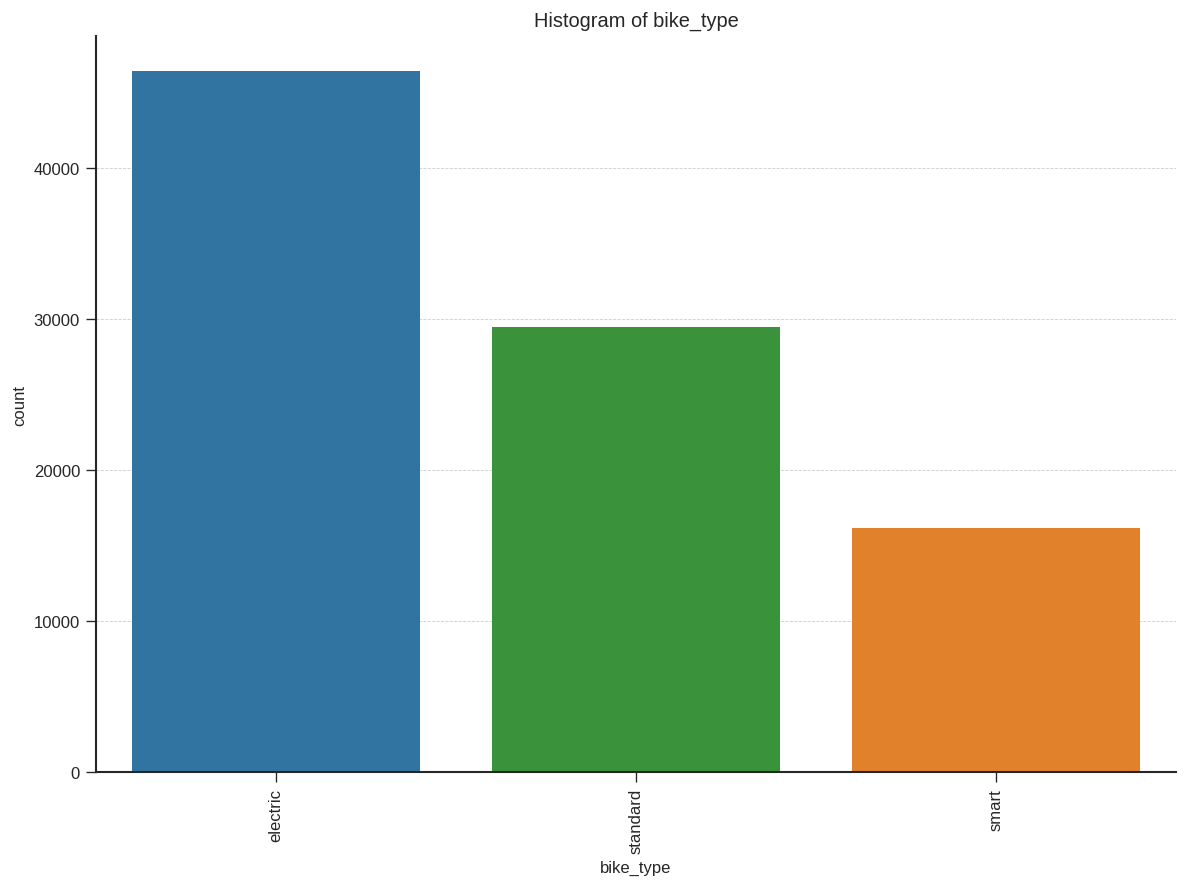

In [14]:
col = "bike_type"

str_ = f"""
Types of bike_type: {metro_df[col].nunique()}
Frequency of categories:
{metro_df[col].value_counts()}
"""
print(str_)


# Create graph
ax = plt.gca()
cats = metro_df[col].value_counts()
palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=len(cats))))
palette = list(map(lambda x: x[1], sorted(palette.items())))
sns.countplot(data=metro_df, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
ax.set_title(f"Histogram of {col}")
ax.tick_params(axis='x', rotation=90)

Here we see that there are 3 types of bikes available to rent -- electric, standard and smart. Electric bikes are most popular among users with almost 45000 of the rides booked being with electric bikes.

### Bivariate Analysis

- From the univariate analysis, we see that the `plan_duration` and `passholder_type` columns are related to one another. Going forward, we will only consider the `passholder_type` column as the plan duration can be inferred from it.

#### duration VS bike_type

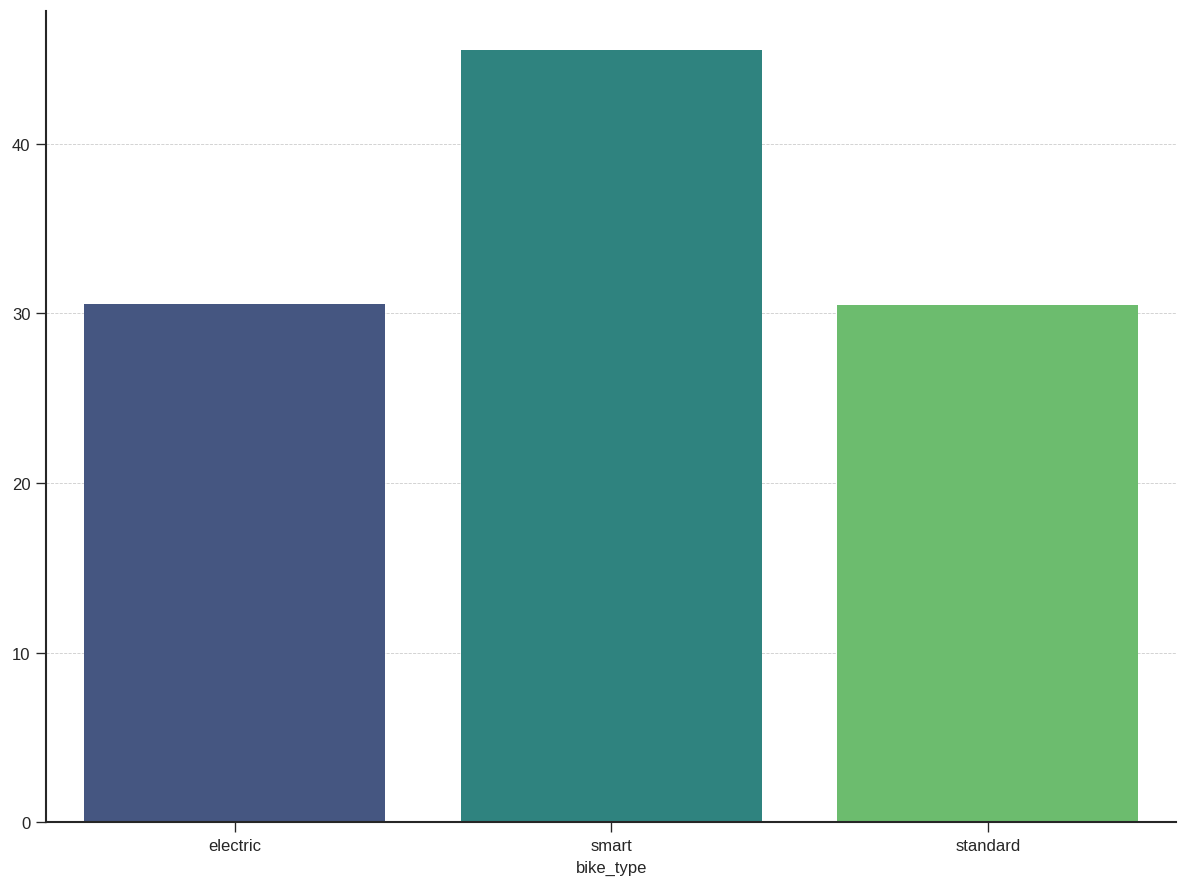

In [15]:
# Get mean duration by bike_type
col = 'bike_type'
mean_duration = metro_df.groupby(f'{col}').agg({'duration': 'mean'})

# Create graph
ax = plt.gca()
sns.barplot(y=mean_duration.values.reshape(len(mean_duration, )), x=mean_duration.index, ax=ax, palette='viridis');

Here we see distribution of mean duration of rides according to bike type. It can be seen that smart bikes are generally used for a longer duration compared to standard and electric bikes. Standard and electric bikes are used for a short duration -- this makes sense because smart bikes can cover larger distances with minimal effort in comparision to standard and electroc bikes.

#### duration vs passholder_type

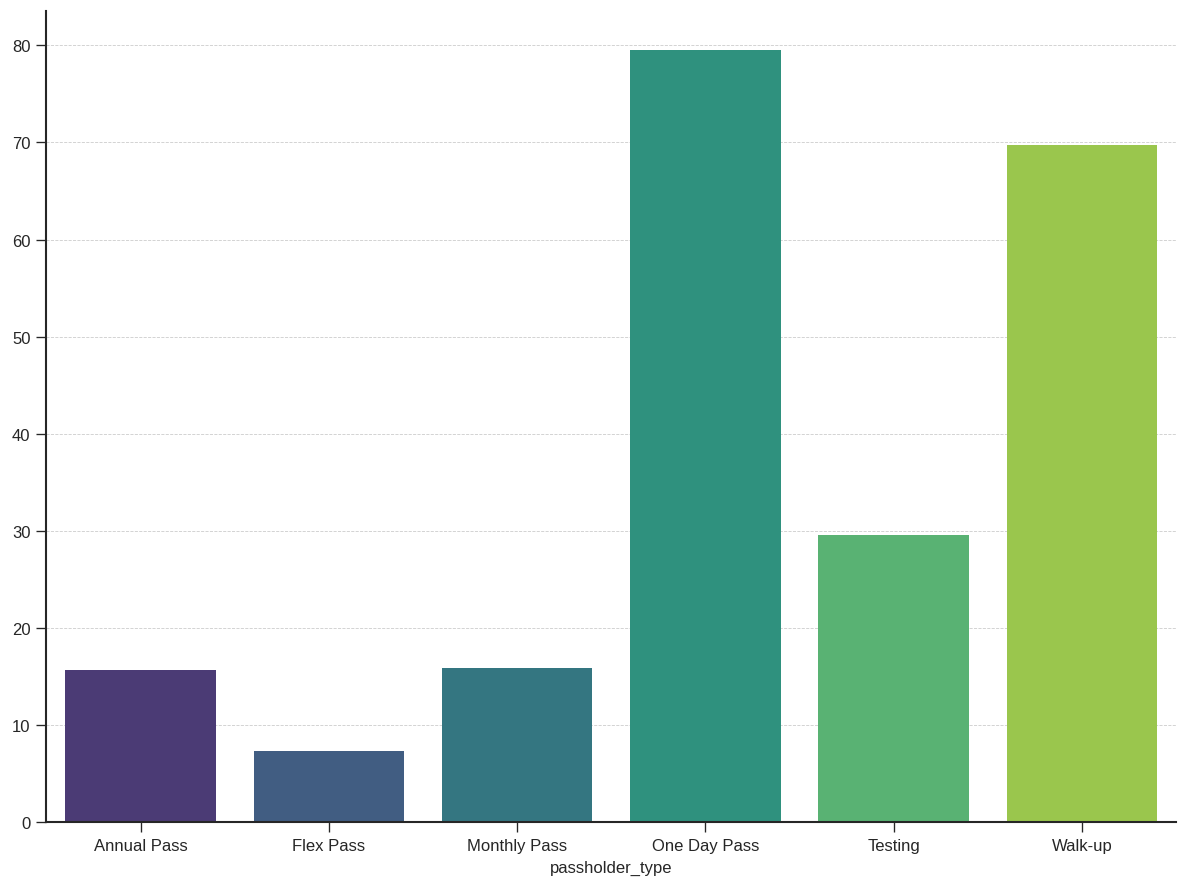

In [16]:
# Get mean duration by passholder_type
col = 'passholder_type'
mean_duration = metro_df.groupby(f'{col}').agg({'duration': 'mean'})

# Create graph
ax = plt.gca()
sns.barplot(y=mean_duration.values.reshape(len(mean_duration, )), x=mean_duration.index, ax=ax, palette='viridis');

From this graph, we can see that consumers that opt for one day pass or walk up rental bikes often use the bike for a longer duration. In contrast, consumers on a monthly/annual pass tend to use the bike for shorter times. It can be hypothesised that consumers that use one-day pass/walk-up are tourists and the other consumers are local to LA and use the bike for short, regular travel. 

#### duration vs trip_route_category

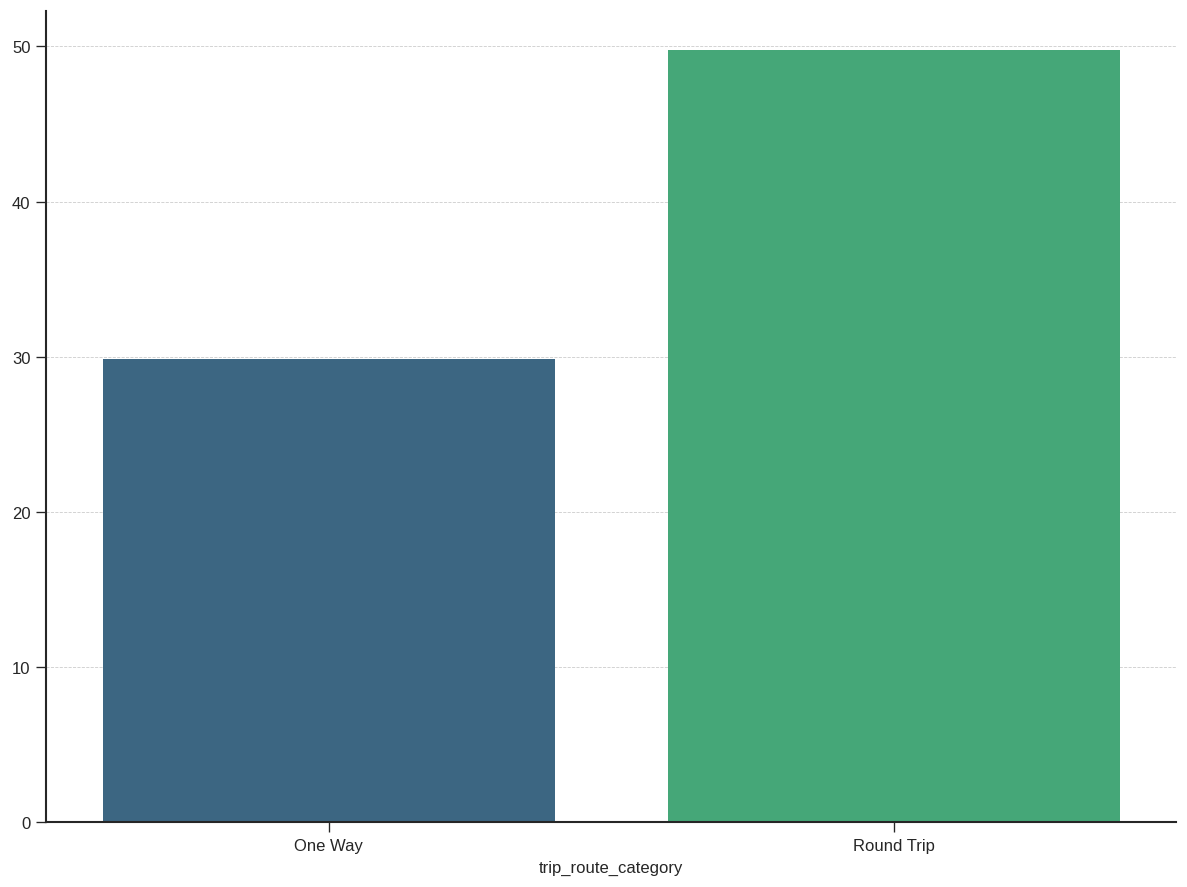

In [17]:
# Get mean duration by trip_route_category
col = 'trip_route_category'
mean_duration = metro_df.groupby(f'{col}').agg({'duration': 'mean'})

# Create graph
ax = plt.gca()
sns.barplot(y=mean_duration.values.reshape(len(mean_duration, )), x=mean_duration.index, ax=ax, palette='viridis');

From this graph, we can see that round trips are longer in duration

#### passholder_type vs bike_type

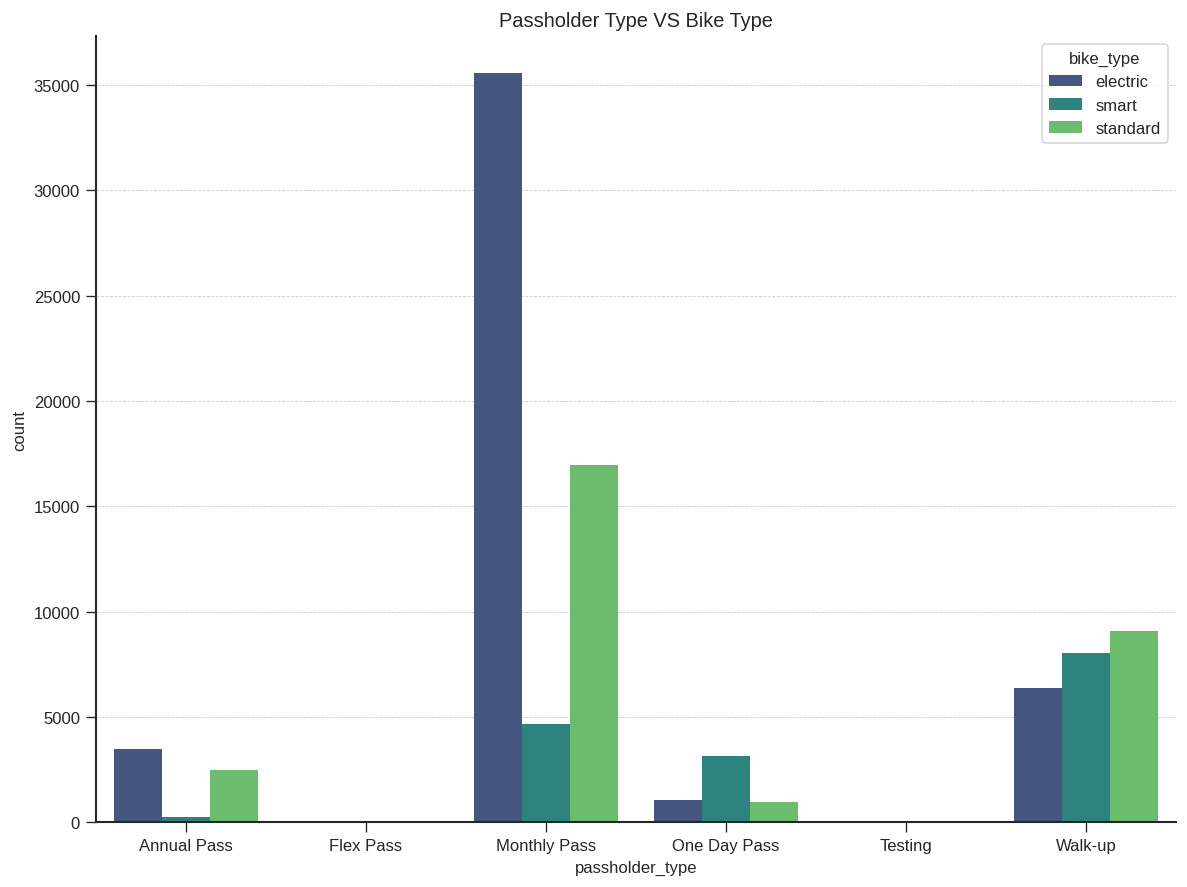

In [18]:
ax = plt.gca()
sns.countplot(data=metro_df, x='passholder_type', hue='bike_type', ax=ax, palette='viridis');
ax.set_title("Passholder Type VS Bike Type");

From this graph, we can see that electric bikes are the most popular even across plan types. For walk-up plan, the most popular bike is the standard one, creating an anomaly where electric bikes are not most popular. Continuing the hypothesis of tourists and locals, this might due to the rustic appeal of using a standard bike around Los Angeles.  

#### passholder_type vs trip_route_category

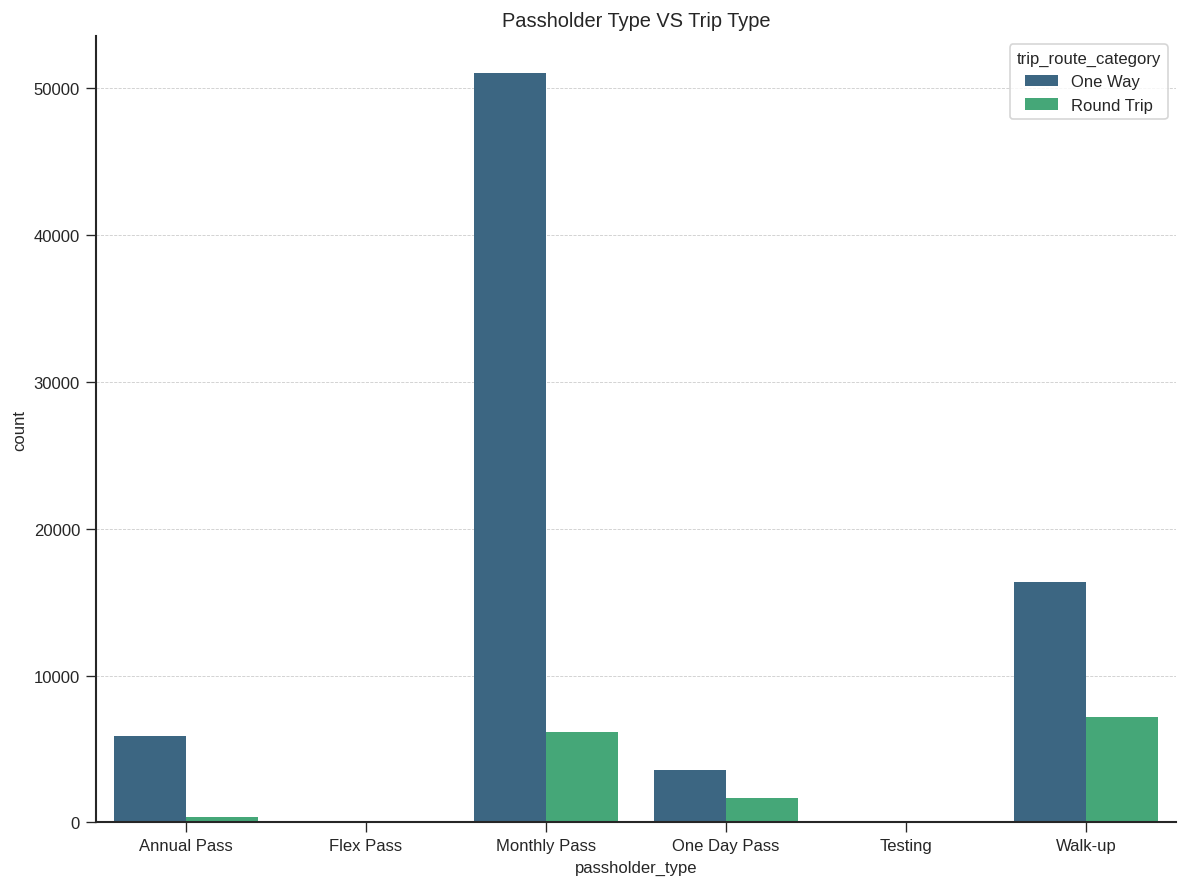

In [19]:
ax = plt.gca()
sns.countplot(data=metro_df, x='passholder_type', hue='trip_route_category', ax=ax, palette='viridis');
ax.set_title("Passholder Type VS Trip Type");

From this we see that monthly pass users prefer one way trips while walk-up ride users opt for round trips at a higher rate.

#### bike_type vs trip_route_category

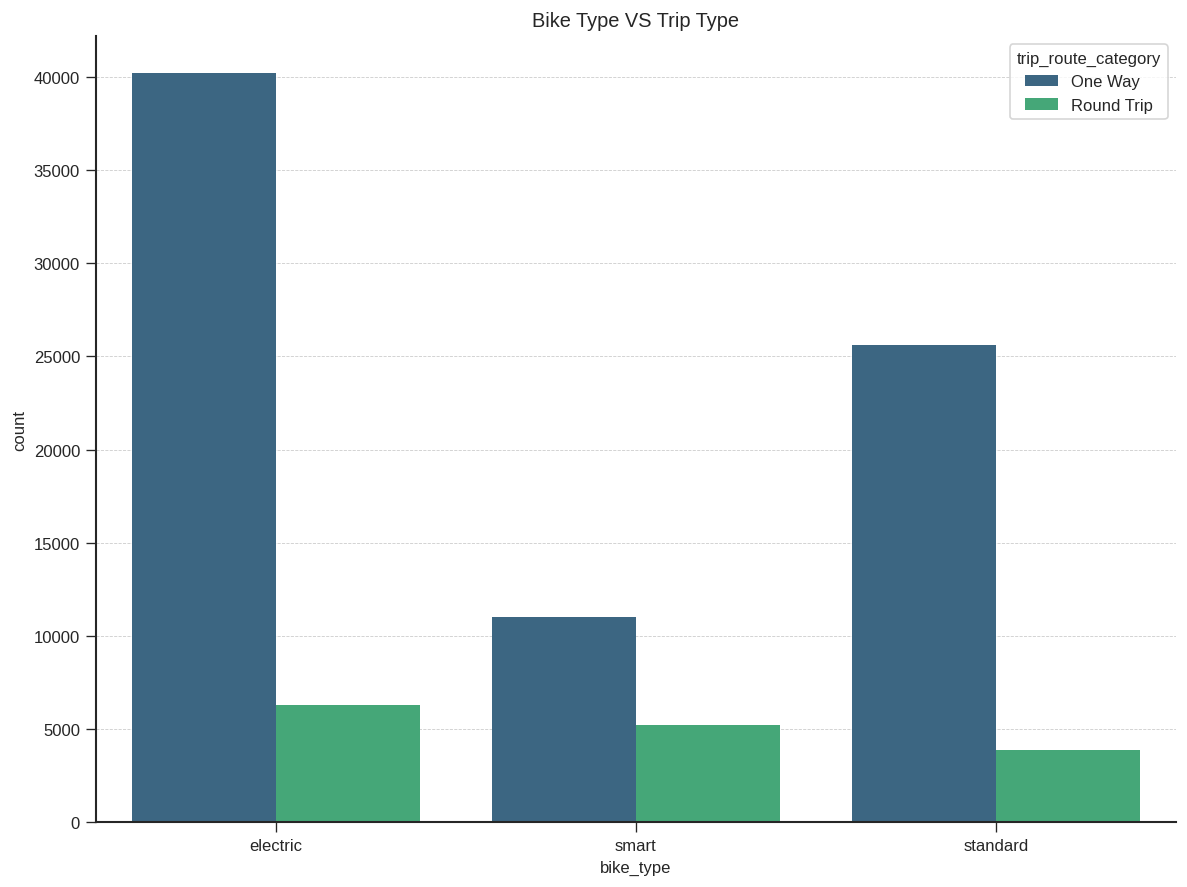

In [20]:
ax = plt.gca()
sns.countplot(data=metro_df, x='bike_type', hue='trip_route_category', ax=ax, palette='viridis');
ax.set_title("Bike Type VS Trip Type");

From this we see that round trips are generally done on electric and smart bikes.

## Adding Attributes

Attributes added - 
1. Part of Day - Gives which part of day the ride was started and ended
2. Day - Gives the day name of the ride
3. Month - Gives the month of the ride


In [21]:
def create_dt_attrs(df: pd.DataFrame, col: str, prefix: str) -> pd.DataFrame:
    """Create new DateTime attributes

    Args:
        df (pd.DataFrame): Input DataFrame
        col (str): datetime column name
        prefix (str): prefix for attribute

    Returns:
        pd.DataFrame: DataFrame with datetime attributes
    """
    # Part of Day
    # Bins and Labels
    bins = [0, 4, 8, 12, 16, 20, 24]
    labels = ["Late Night", "Early Morning", "Morning", "Noon", "Evening", "Night"]
    # Create Attributes
    df[f"{prefix}_part_of_day"] = pd.cut(df[col].dt.hour, bins=bins, labels=labels, include_lowest=True) 
    
    # Day of week and month
    df[f"{prefix}_day"] = df[col].dt.day_name()
    df[f"{prefix}_month"] = df[col].dt.month_name()
    
    # Return DF
    return df


metro_df_enhd = metro_df.copy(deep=True)
for col in ['start_time', 'end_time']:
    metro_df_enhd = create_dt_attrs(metro_df_enhd, col, col.split("_")[0])

metro_df_enhd


trip_id  duration          start_time            end_time  \
0      124657107         5 2019-07-01 00:04:00 2019-07-01 00:09:00   
1      124657587         9 2019-07-01 00:07:00 2019-07-01 00:16:00   
2      124658068         5 2019-07-01 00:20:00 2019-07-01 00:25:00   
3      124659747        20 2019-07-01 00:44:00 2019-07-01 01:04:00   
4      124660227        27 2019-07-01 00:44:00 2019-07-01 01:11:00   
...          ...       ...                 ...                 ...   
92119  130053092         8 2019-09-30 23:32:00 2019-09-30 23:40:00   
92120  130053090        15 2019-09-30 23:38:00 2019-09-30 23:53:00   
92121  130053089         1 2019-09-30 23:40:00 2019-09-30 23:41:00   
92122  130053088        22 2019-09-30 23:41:00 2019-10-01 00:03:00   
92123  130053087         4 2019-09-30 23:58:00 2019-10-01 00:02:00   

      start_station end_station bike_id plan_duration trip_route_category  \
0              4312        4410    6168            30             One Way   
1              3066        3066   17584            30          Round Trip   
2              4410        4312   18920            30             One Way   
3              3045        4275    6016             1             One Way   
4              3035        3049    5867            30             One Way   
...             ...         ...     ...           ...                 ...   
92119          3038        3078   19655             1             One Way   
92120          4401        4401   18984            30          Round Trip   
92121          3038        3067   12361           365             One Way   
92122          3067        3049   16580           365             One Way   
92123          4417        4285   15727           365             One Way   

      passholder_type bike_type start_part_of_day start_day start_month  \
0        Monthly Pass  standard        Late Night    Monday        July   
1        Monthly Pass  electric        Late Night    Monday        July   
2        Monthly Pass  electric        Late Night    Monday        July   
3             Walk-up  standard        Late Night    Monday        July   
4        Monthly Pass  standard        Late Night    Monday        July   
...               ...       ...               ...       ...         ...   
92119         Walk-up  electric             Night    Monday   September   
92120    Monthly Pass  electric             Night    Monday   September   
92121     Annual Pass  standard             Night    Monday   September   
92122     Annual Pass  electric             Night    Monday   September   
92123         Walk-up     smart             Night    Monday   September   

      end_part_of_day  end_day  end_month  
0          Late Night   Monday       July  
1          Late Night   Monday       July  
2          Late Night   Monday       July  
3          Late Night   Monday       July  
4          Late Night   Monday       July  
...               ...      ...        ...  
92119           Night   Monday  September  
92120           Night   Monday  September  
92121           Night   Monday  September  
92122      Late Night  Tuesday    October  
92123      Late Night  Tuesday    October  

[92124 rows x 17 columns]

## EDA on processed data

### Univariate Analysis

#### part_of_day


    The data is divided into 6 parts for each day.
    Most number of rides were started during: Evening
    


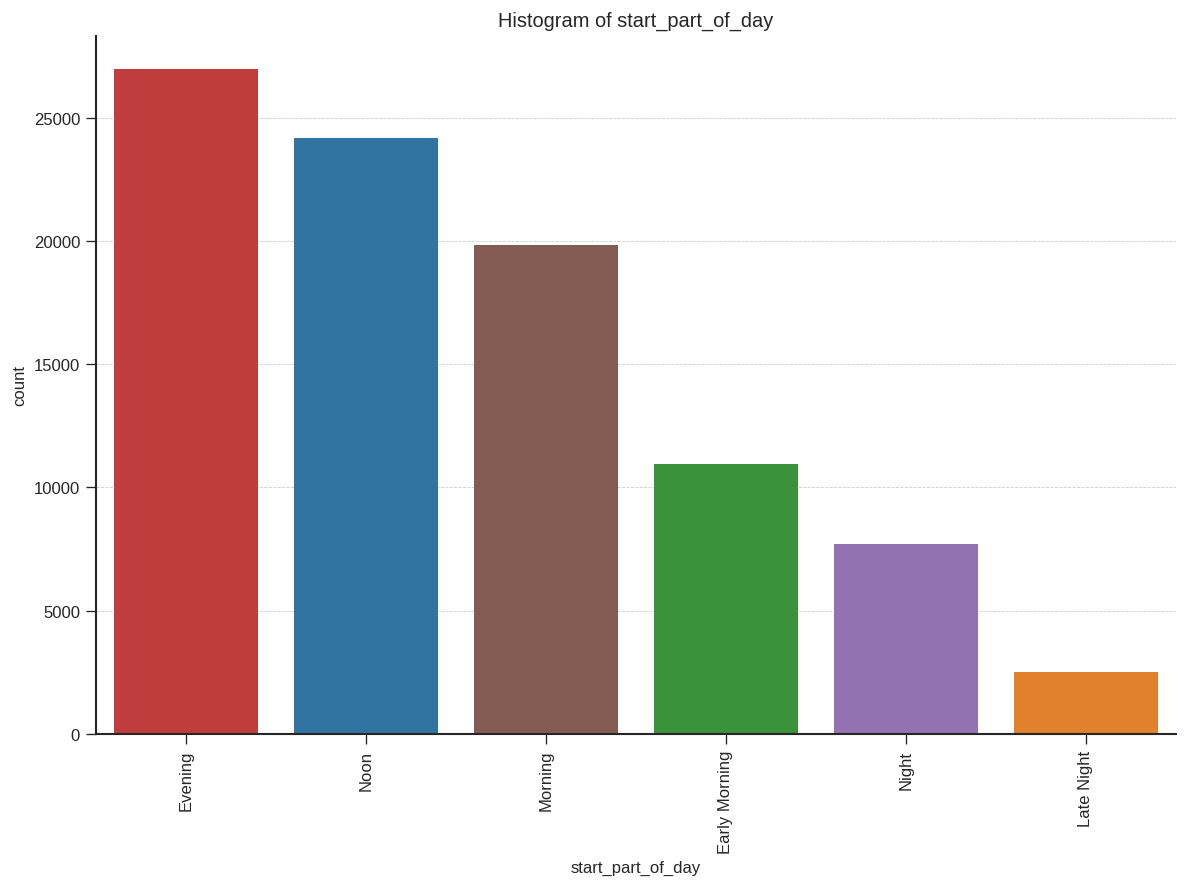


    The data is divided into 6 parts for each day.
    Most number of rides were ended during: Evening
    


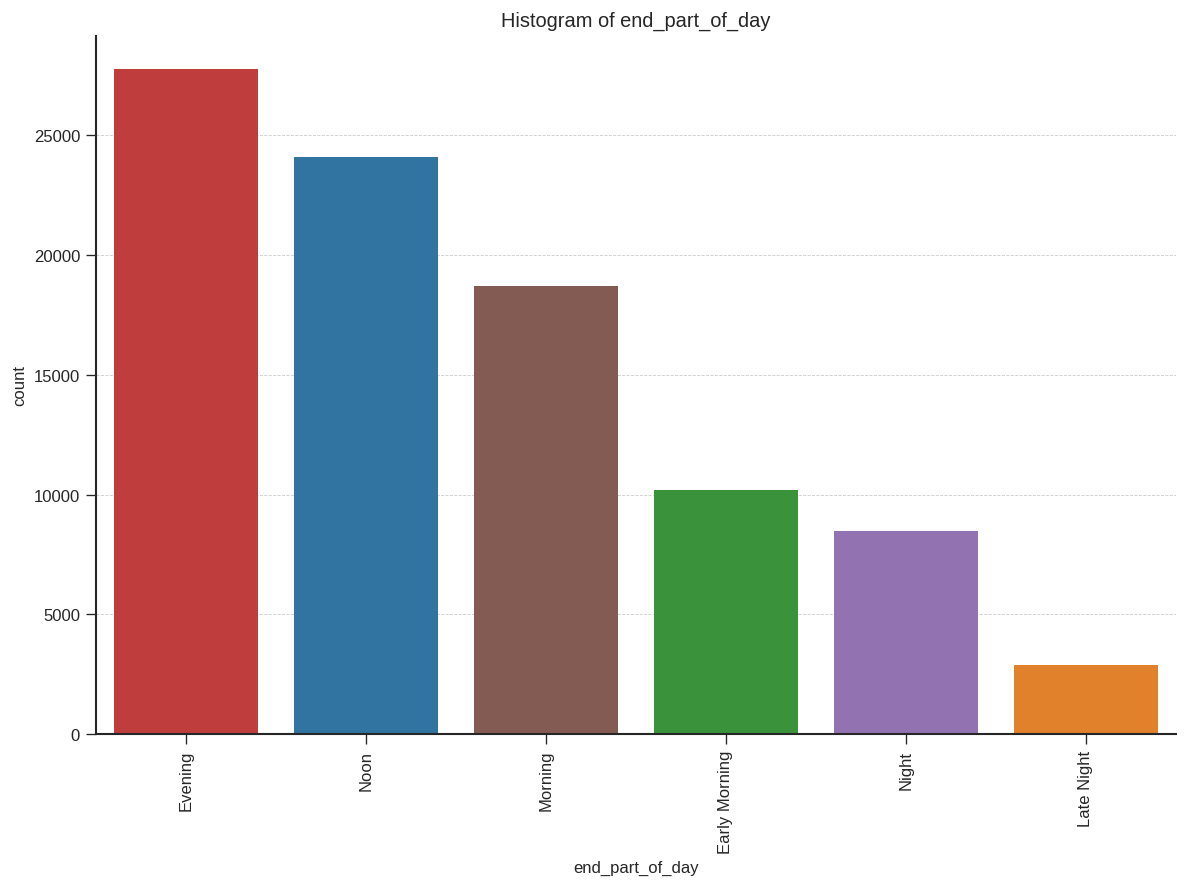

In [22]:
for x in ['start', 'end']:
    col = f"{x}_part_of_day"

    str_ = f"""
    The data is divided into {metro_df_enhd[col].nunique()} parts for each day.
    Most number of rides were {x}ed during: {metro_df_enhd[col].value_counts().iloc[:1].index.to_list()[0]}
    """
    print(str_)

    ax = plt.gca()
    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
    ax.set_title(f"Histogram of {col}")
    ax.tick_params(axis='x', rotation=90)
    plt.show();

Here we see that most of the bikes were booked in the evenings, followed by noon.

#### month

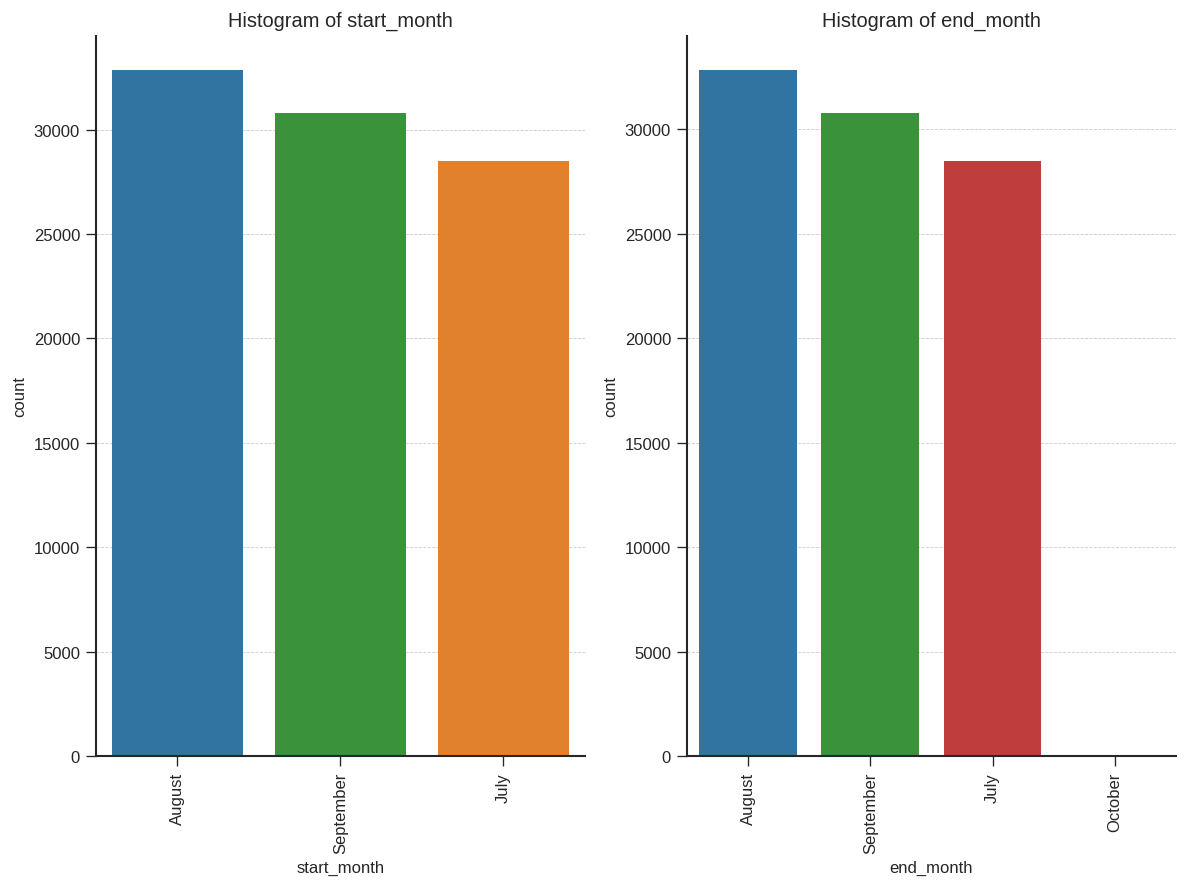

In [23]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_month"

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
    ax.set_title(f"Histogram of {col}")
    ax.tick_params(axis='x', rotation=90)
plt.show();

- The data is collected for 3 months.
- We see that most rides were booked in the month of August with over 35000+ rides booked.

#### day

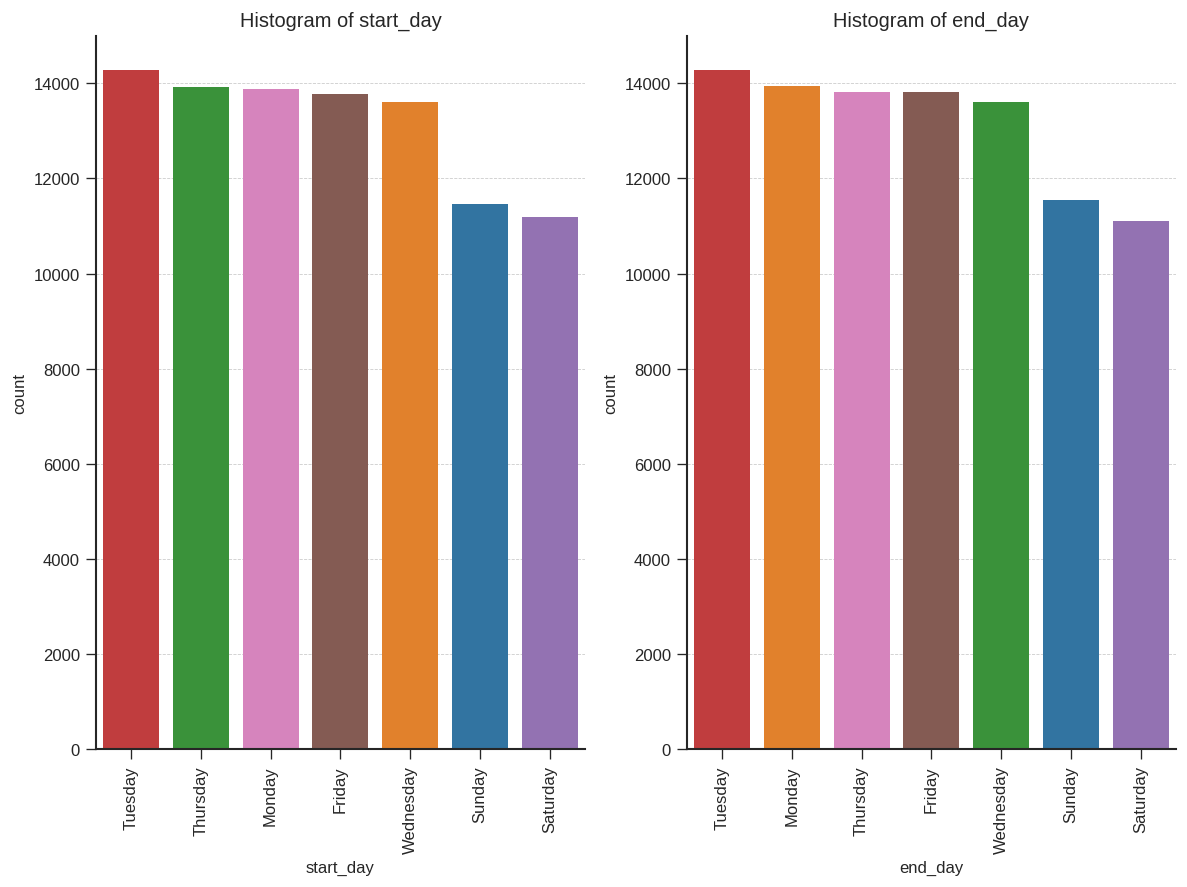

In [24]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_day"

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, ax=ax, palette=palette, order=cats.iloc[:20].index)
    ax.set_title(f"Histogram of {col}")
    ax.tick_params(axis='x', rotation=90)
plt.show();

- We group the data by the day the ride was booked.
- We see that most rides were booked on Tuesdays.

### Bivariate Analysis

#### duration VS day

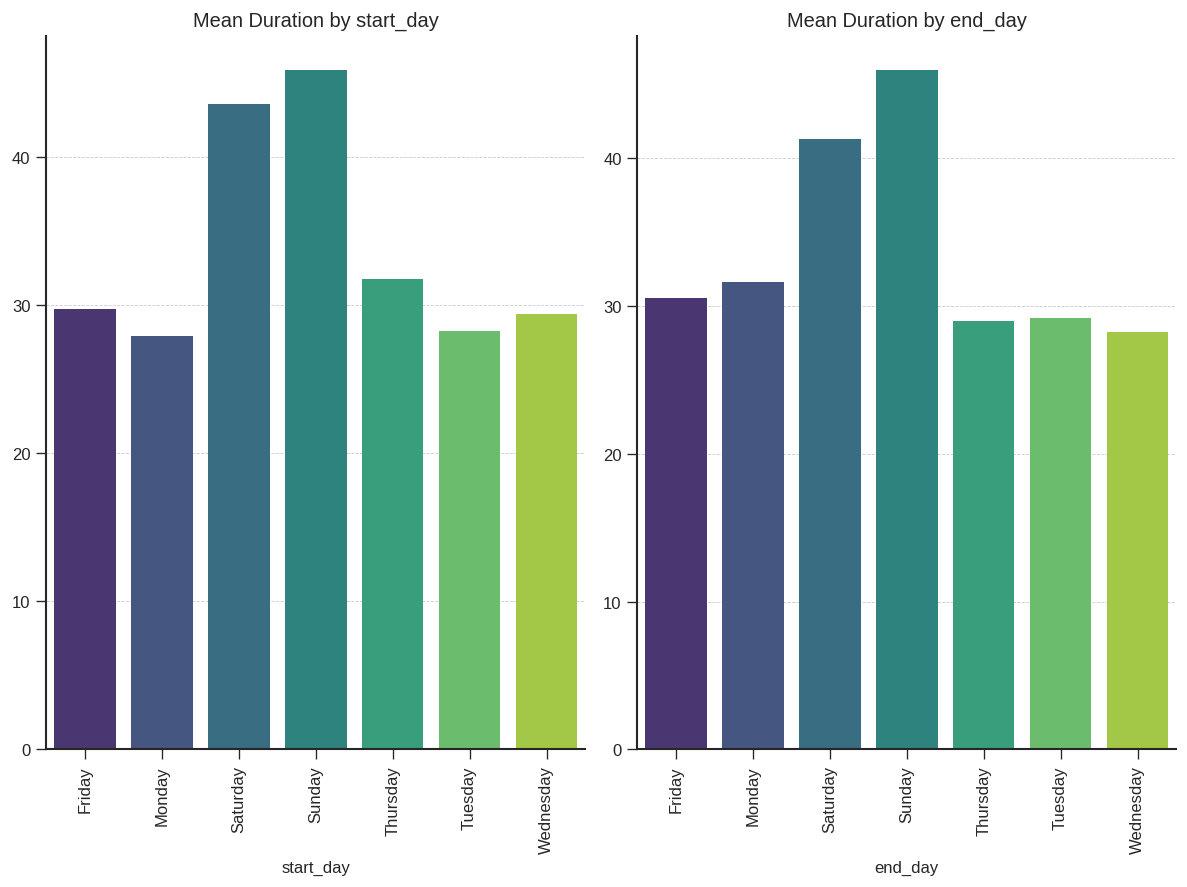

In [25]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_day"
    mean_duration = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.barplot(y=mean_duration.values.reshape(7, ), x=mean_duration.index, ax=ax, palette='viridis');
    ax.set_title(f"Mean Duration by {x}_day");
    ax.tick_params(axis='x', rotation=90)
plt.show();

Here we see that most the shortest rides are on Mondays and the longest bike rides are on Sundays

#### duration VS part_of_day

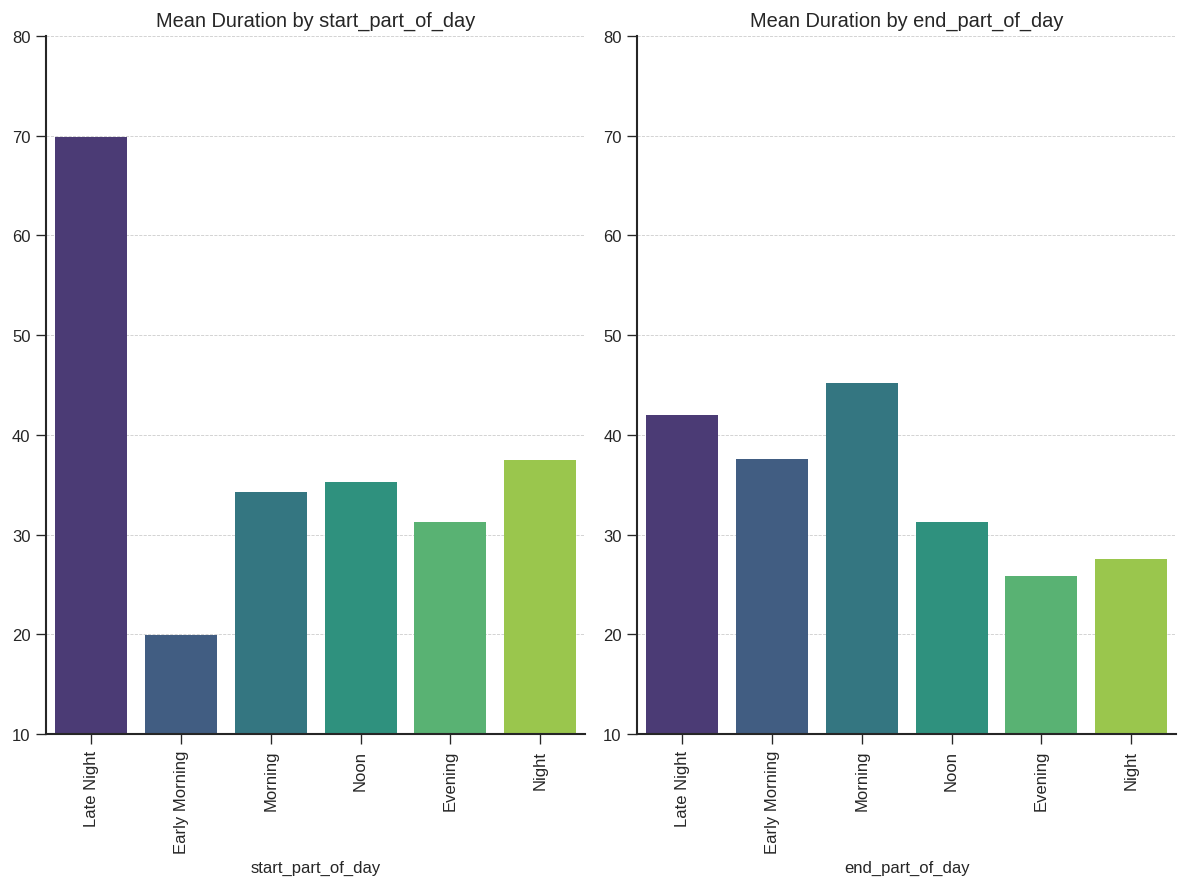

In [26]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_part_of_day"
    mean_duration = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.barplot(y=mean_duration.values.reshape(len(mean_duration), ), x=mean_duration.index, ax=ax, palette='viridis');
    ax.set_title(f"Mean Duration by {x}_part_of_day");
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim(10, 80)
plt.show();

Here we see that most the shortest rides are during early mornings and the longest bike rides are during late nights.

#### bike_type vs day

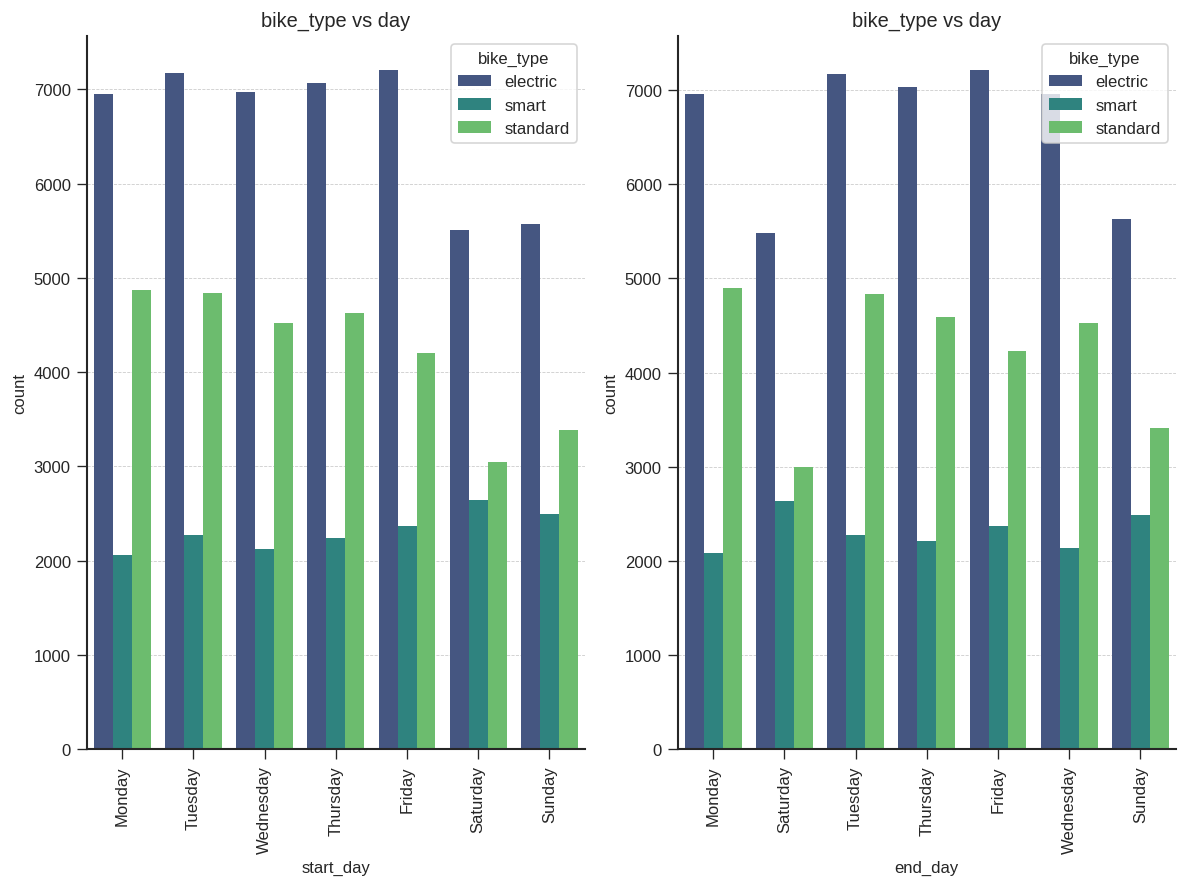

In [27]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_day"
    mean_duration_by_day = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, hue='bike_type', ax=ax, palette='viridis');
    ax.set_title("bike_type vs day");
    ax.tick_params(axis='x', rotation=90)
plt.show();

- Number of electric bikes booked on weekends are lower than number of electric bikes booked on weekdays.

#### bike_type vs part_of_day

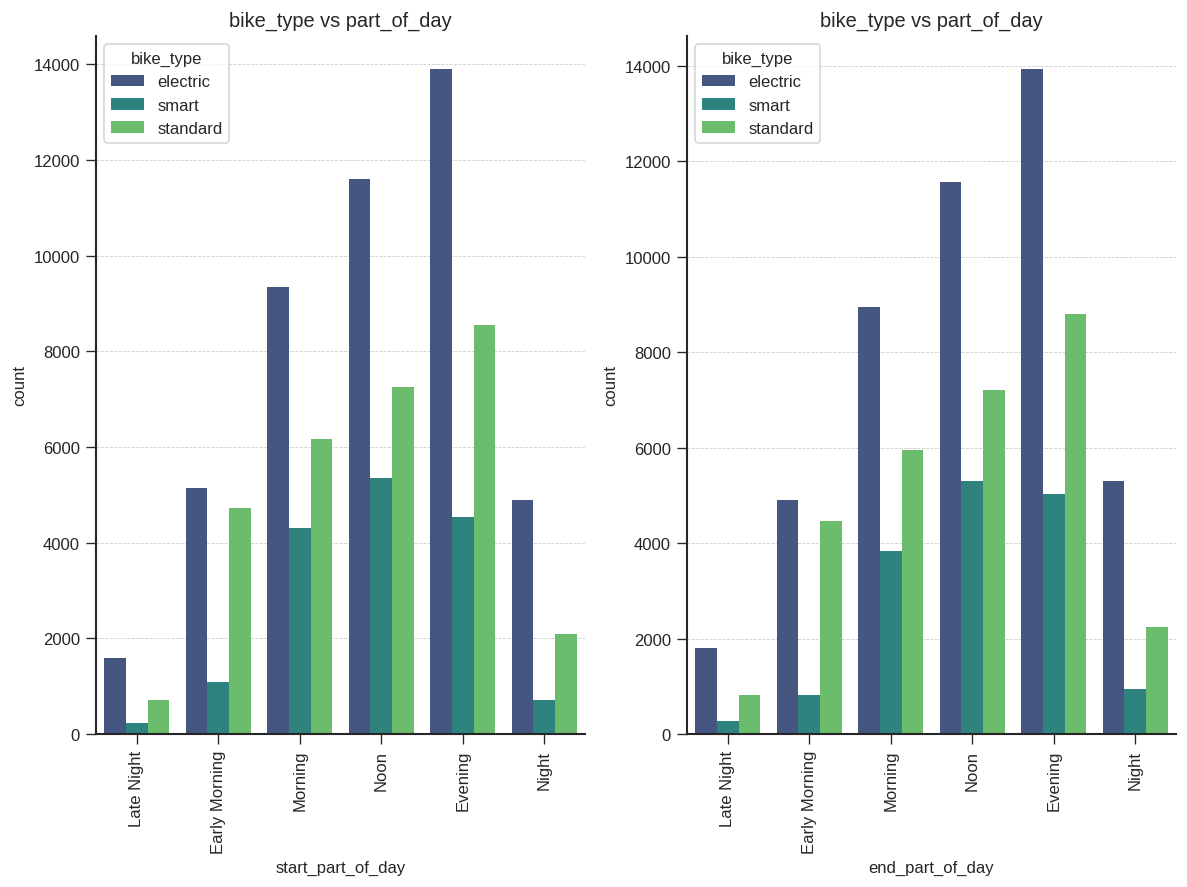

In [28]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_part_of_day"
    mean_duration_by_day = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, hue='bike_type', ax=ax, palette='viridis');
    ax.set_title("bike_type vs part_of_day");
    ax.tick_params(axis='x', rotation=90)
plt.show();

- Electric bikes are popular at all times.

#### passholder_type vs day

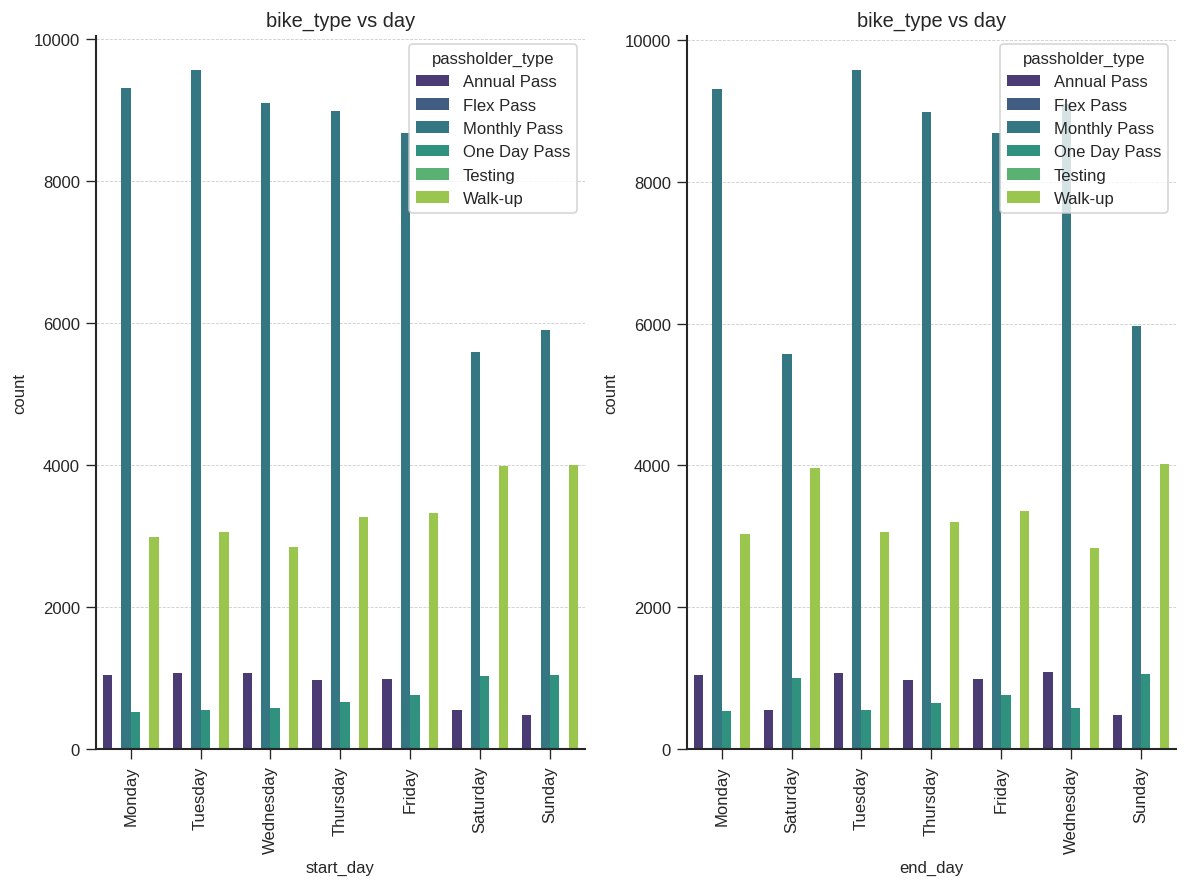

In [29]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_day"
    mean_duration_by_day = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, hue='passholder_type', ax=ax, palette='viridis');
    ax.set_title("bike_type vs day");
    ax.tick_params(axis='x', rotation=90)
plt.show();

From this graph, we can see that 

- On Saturday and Sundays, the more walk-up rides are booked. This can be attributed to tourists booking rides on weekends more.

#### passholder_type vs part_of_day

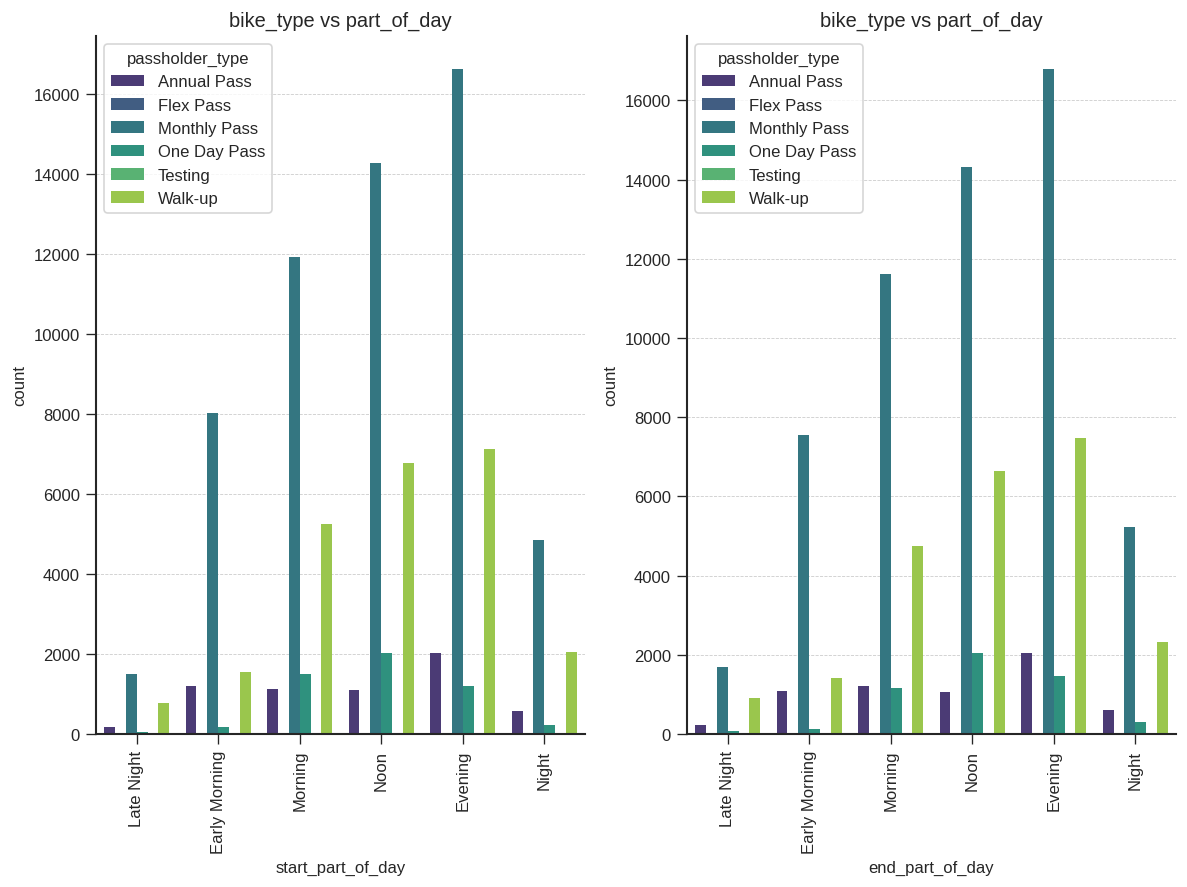

In [30]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_part_of_day"
    mean_duration_by_day = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, hue='passholder_type', ax=ax, palette='viridis');
    ax.set_title("bike_type vs part_of_day");
    ax.tick_params(axis='x', rotation=90)
plt.show();

From this graph, we can see that 

- Monthly pass users book rides all day long.
- Walk-up pass users also book rides all day long but not at the level of monthly pass users.

#### trip_route_category vs day

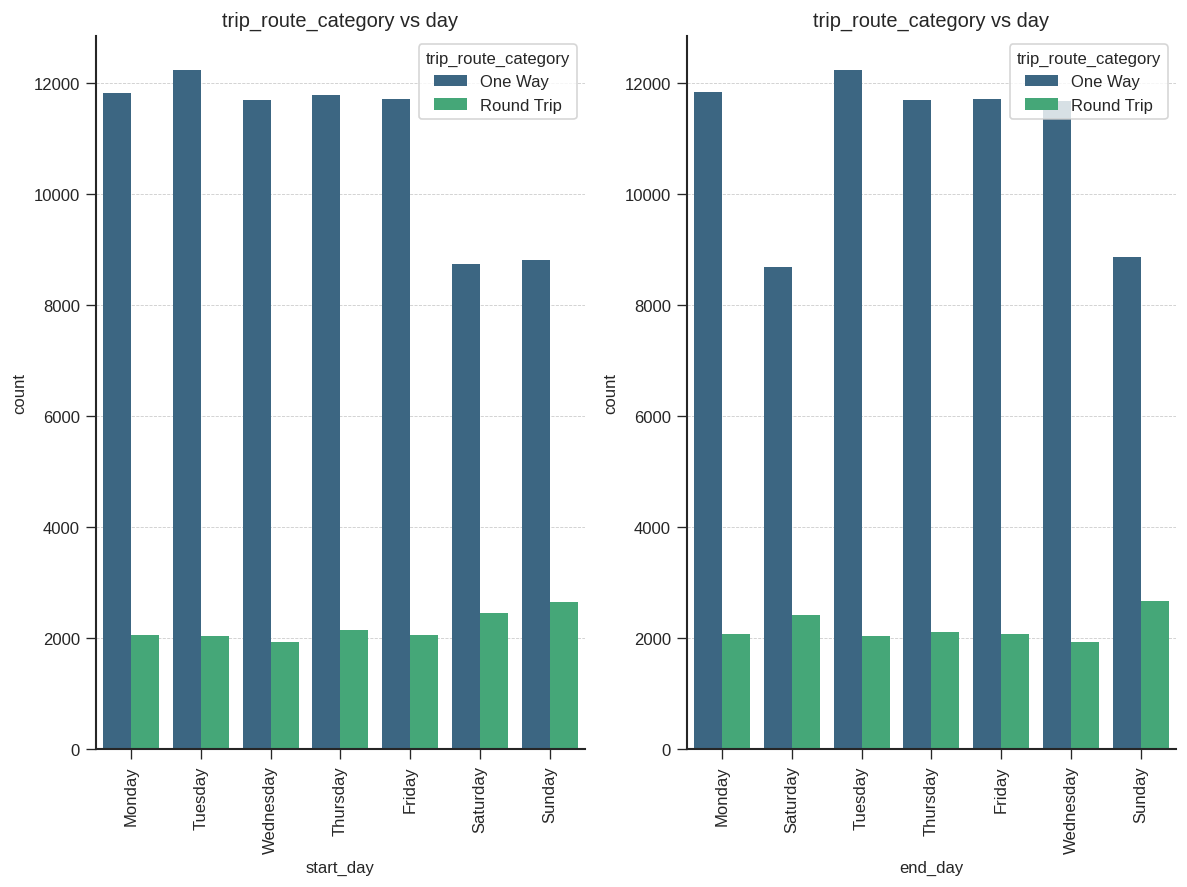

In [31]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_day"
    mean_duration_by_day = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, hue='trip_route_category', ax=ax, palette='viridis');
    ax.set_title("trip_route_category vs day");
    ax.tick_params(axis='x', rotation=90)
plt.show();

From this graph, we can see that 

- Round trips are booked at a constant rate throughout weekdays and increase during weekends
- One way are booked more during weekdays and reduce during weekends.

#### trip_route_category vs part_of_day

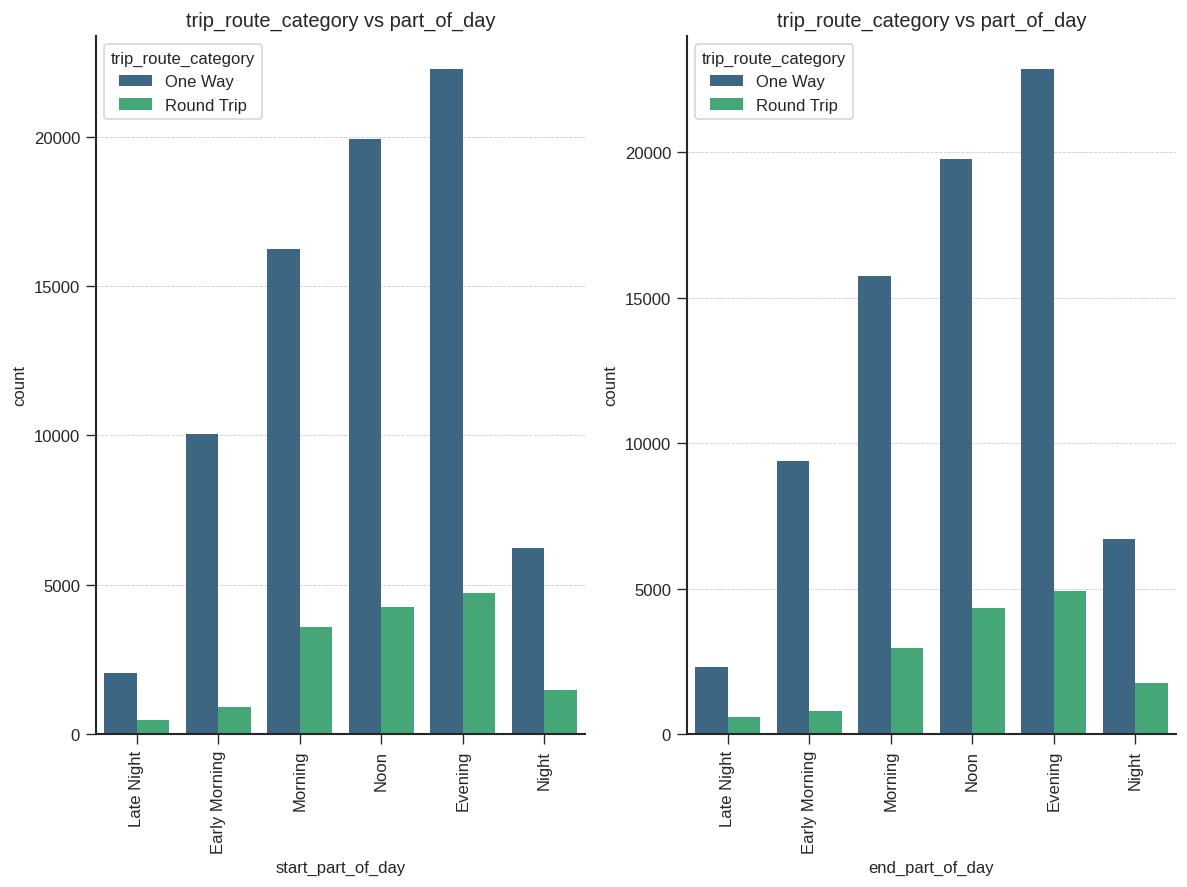

In [32]:
fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for ax, x in zip(axes, ['start', 'end']):
    col = f"{x}_part_of_day"
    mean_duration_by_day = metro_df_enhd.groupby(f'{col}').agg({'duration': 'mean'})

    cats = metro_df_enhd[col].value_counts()
    palette = dict(zip(cats.iloc[:20].index, sns.color_palette(n_colors=20)))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Create graph
    sns.countplot(data=metro_df_enhd, x=col, hue='trip_route_category', ax=ax, palette='viridis');
    ax.set_title("trip_route_category vs part_of_day");
    ax.tick_params(axis='x', rotation=90)
plt.show();

From this graph, we can see that 

- Round trips are booked more often during evening

## Sunburst Charts

In [33]:
import plotly.express as px
# Plot this as a sunburst
fig = px.sunburst(
    metro_df_enhd, 
    path=['start_day', 'start_part_of_day','bike_type'], 
    height=1000,
    title='Distribution of bike types according to day of week and part of day'
)
fig.show()

In [34]:
import plotly.express as px
# Plot this as a sunburst
fig = px.sunburst(
    metro_df_enhd, 
    path=['start_month', 'passholder_type','bike_type'], 
    height=1000,
    title='Distribution of bike type according to pass type and month'
)
fig.show()

In [35]:
import plotly.express as px
# Plot this as a sunburst
fig = px.sunburst(
    metro_df_enhd, 
    path=['start_day', 'bike_type', 'trip_route_category'], 
    height=1000,
    title='Distribution of trip type according to day of week and bike type'
)
fig.show()

## PCA and Clustering Analysis

### PCA Analysis




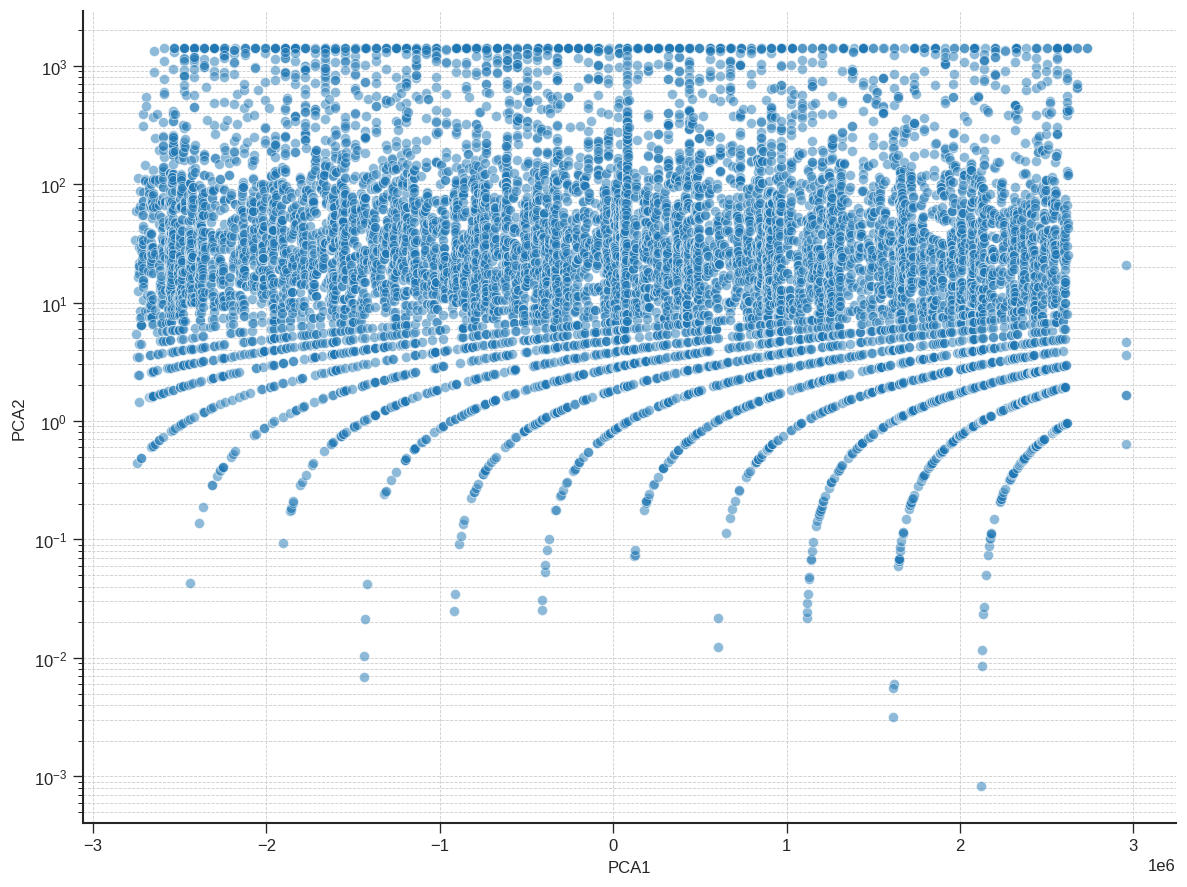

In [36]:
"""
OHE for categories
PCA with 2 components
Visualise
"""

metro_ohe_df = pd.get_dummies(metro_df_enhd[[x for x in metro_df_enhd if 'time' not in x]])
pca = PCA(n_components=2, random_state=420)
metro_pca_df = pd.DataFrame(data=pca.fit_transform(metro_ohe_df), columns=['PCA1', 'PCA2'])
ax = plt.gca()
sns.scatterplot(data=metro_pca_df, x='PCA1', y='PCA2', alpha=0.5, ax=ax)
ax.set_yscale('log');

### Clustering Analysis 

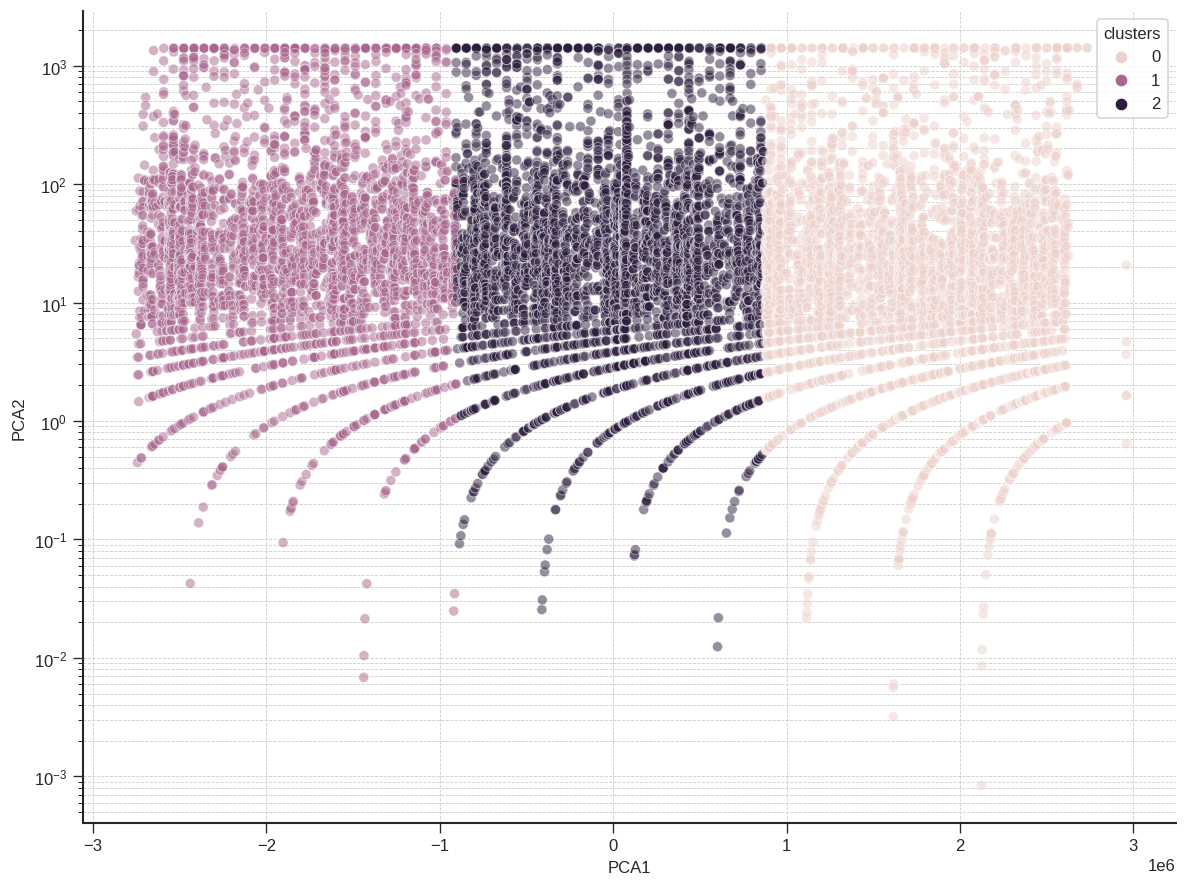

In [37]:
"""
Apply KMeans on whole data OHE data
Visualise in 2D using PCA 
"""

kmeans = cluster.KMeans(n_clusters=3, random_state=420)
kmeans.fit_predict(metro_ohe_df)
metro_pca_df['clusters'] = kmeans.labels_
ax = plt.gca()
sns.scatterplot(data=metro_pca_df, x='PCA1', y='PCA2', alpha=0.5, ax=ax, hue='clusters', cmap='viridis')
ax.set_yscale('log');

Here we can see that the data can be clustered easily using 3 clusters.

### T-Test

Annual Pass vs. Flex Pass: p-value = 0.7967561096988505
Annual Pass vs. Monthly Pass: p-value = 0.8079066494292784
Annual Pass vs. One Day Pass: p-value = 2.2588629186253607e-117
Annual Pass vs. Testing: p-value = 0.23356025974011252
Annual Pass vs. Walk-up: p-value = 1.140334547288597e-86
Flex Pass vs. Monthly Pass: p-value = 0.7098197976254619
Flex Pass vs. One Day Pass: p-value = 0.3717481723380336
Flex Pass vs. Testing: p-value = 0.3599517977287976
Flex Pass vs. Walk-up: p-value = 0.46988358481506165
Monthly Pass vs. One Day Pass: p-value = 0.0
Monthly Pass vs. Testing: p-value = 0.09648189805342629
Monthly Pass vs. Walk-up: p-value = 0.0
One Day Pass vs. Testing: p-value = 0.08736201326124707
One Day Pass vs. Walk-up: p-value = 0.0022124997179959363
Testing vs. Walk-up: p-value = 0.19828924536904566


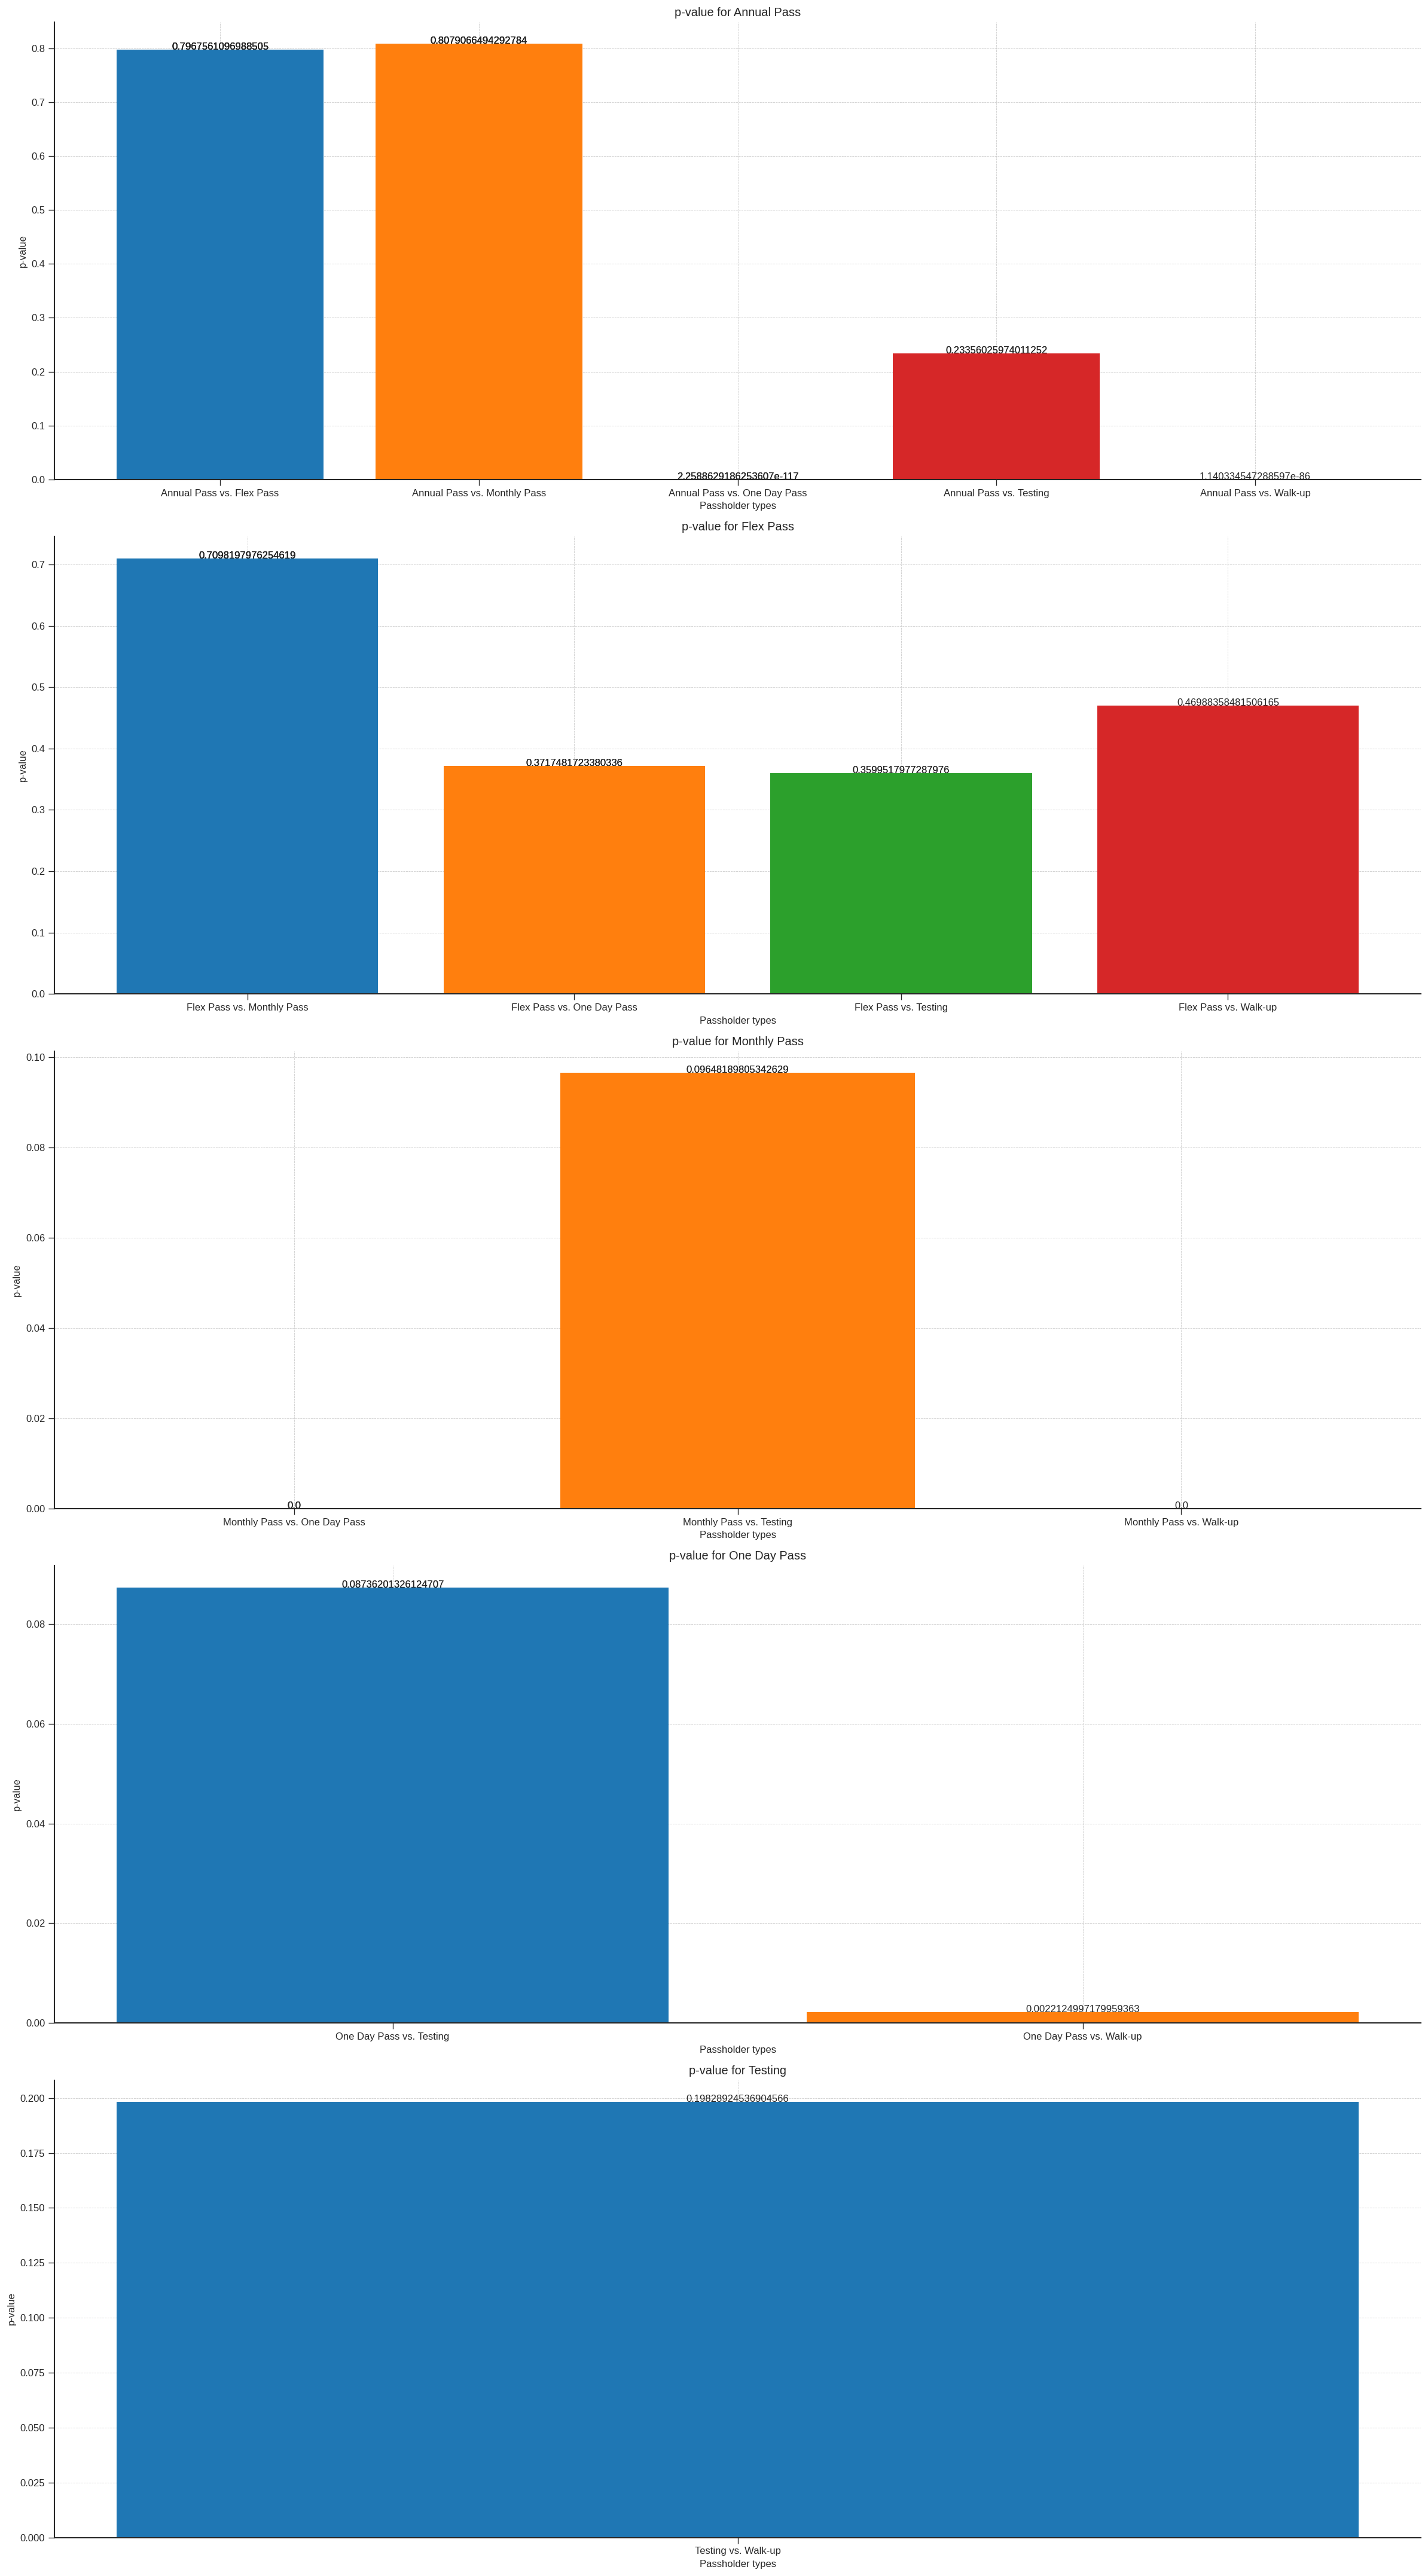

In [38]:
# import all the other necessary libraries for metro_bike data

from scipy import stats

metro_df_by_passholder = metro_df.groupby("passholder_type")

metro_df_by_duration_by_passholder = metro_df_by_passholder["duration"]

mean_duration_by_passholder = metro_df_by_duration_by_passholder.mean()

# Create a figure with multiple subplots
fig, axs = plt.subplots(nrows=len(mean_duration_by_passholder.index)-1, ncols=1, 
                        figsize=(20, 6*len(mean_duration_by_passholder.index)))

# Loop through each pair of passholder types and plot the t-statistic values
for i, passholder_type1 in enumerate(mean_duration_by_passholder.index[:-1]):
  for j, passholder_type2 in enumerate(mean_duration_by_passholder.index[i+1:]):
    t_stat, p_value = stats.ttest_ind(metro_df_by_duration_by_passholder.get_group(passholder_type1), 
                                      metro_df_by_duration_by_passholder.get_group(passholder_type2))
    print(f'{passholder_type1} vs. {passholder_type2}: p-value = {p_value}')
    axs[i].bar(f"{passholder_type1} vs. {passholder_type2}", p_value)
    axs[i].set_title(f"p-value for {passholder_type1}")
    for p in axs[i].patches:
        axs[i].text(p.get_x() + p.get_width()/2, p.get_height(), p.get_height(), ha='center')
    axs[i].set_xlabel("Passholder types")
    axs[i].set_ylabel("p-value")

plt.show()

Here we see that the different passholder_type values are from different distributions.

In [39]:
# If facing with memory issues run this cell!

# WARNING: 
# This will effectively reset the jupyter notebook and erase all variables
# and has been provided to refresh the notebook between different tasks.

%reset -f

---
# Task 2 - Clustering Analysis

## Imports and Settings

In [40]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

# Imports
import os
import sys
import time
import warnings
from collections import defaultdict
from ipywidgets import widgets, Layout
from IPython.display import display
from IPython.display import Markdown as md

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples


In [41]:
# Matplotlib Settings
plt.style.use(["seaborn-ticks"])
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = "x-large"
sns.set(rc=dict(plt.rcParams))


## Visualisation

### Full Data Visualisation

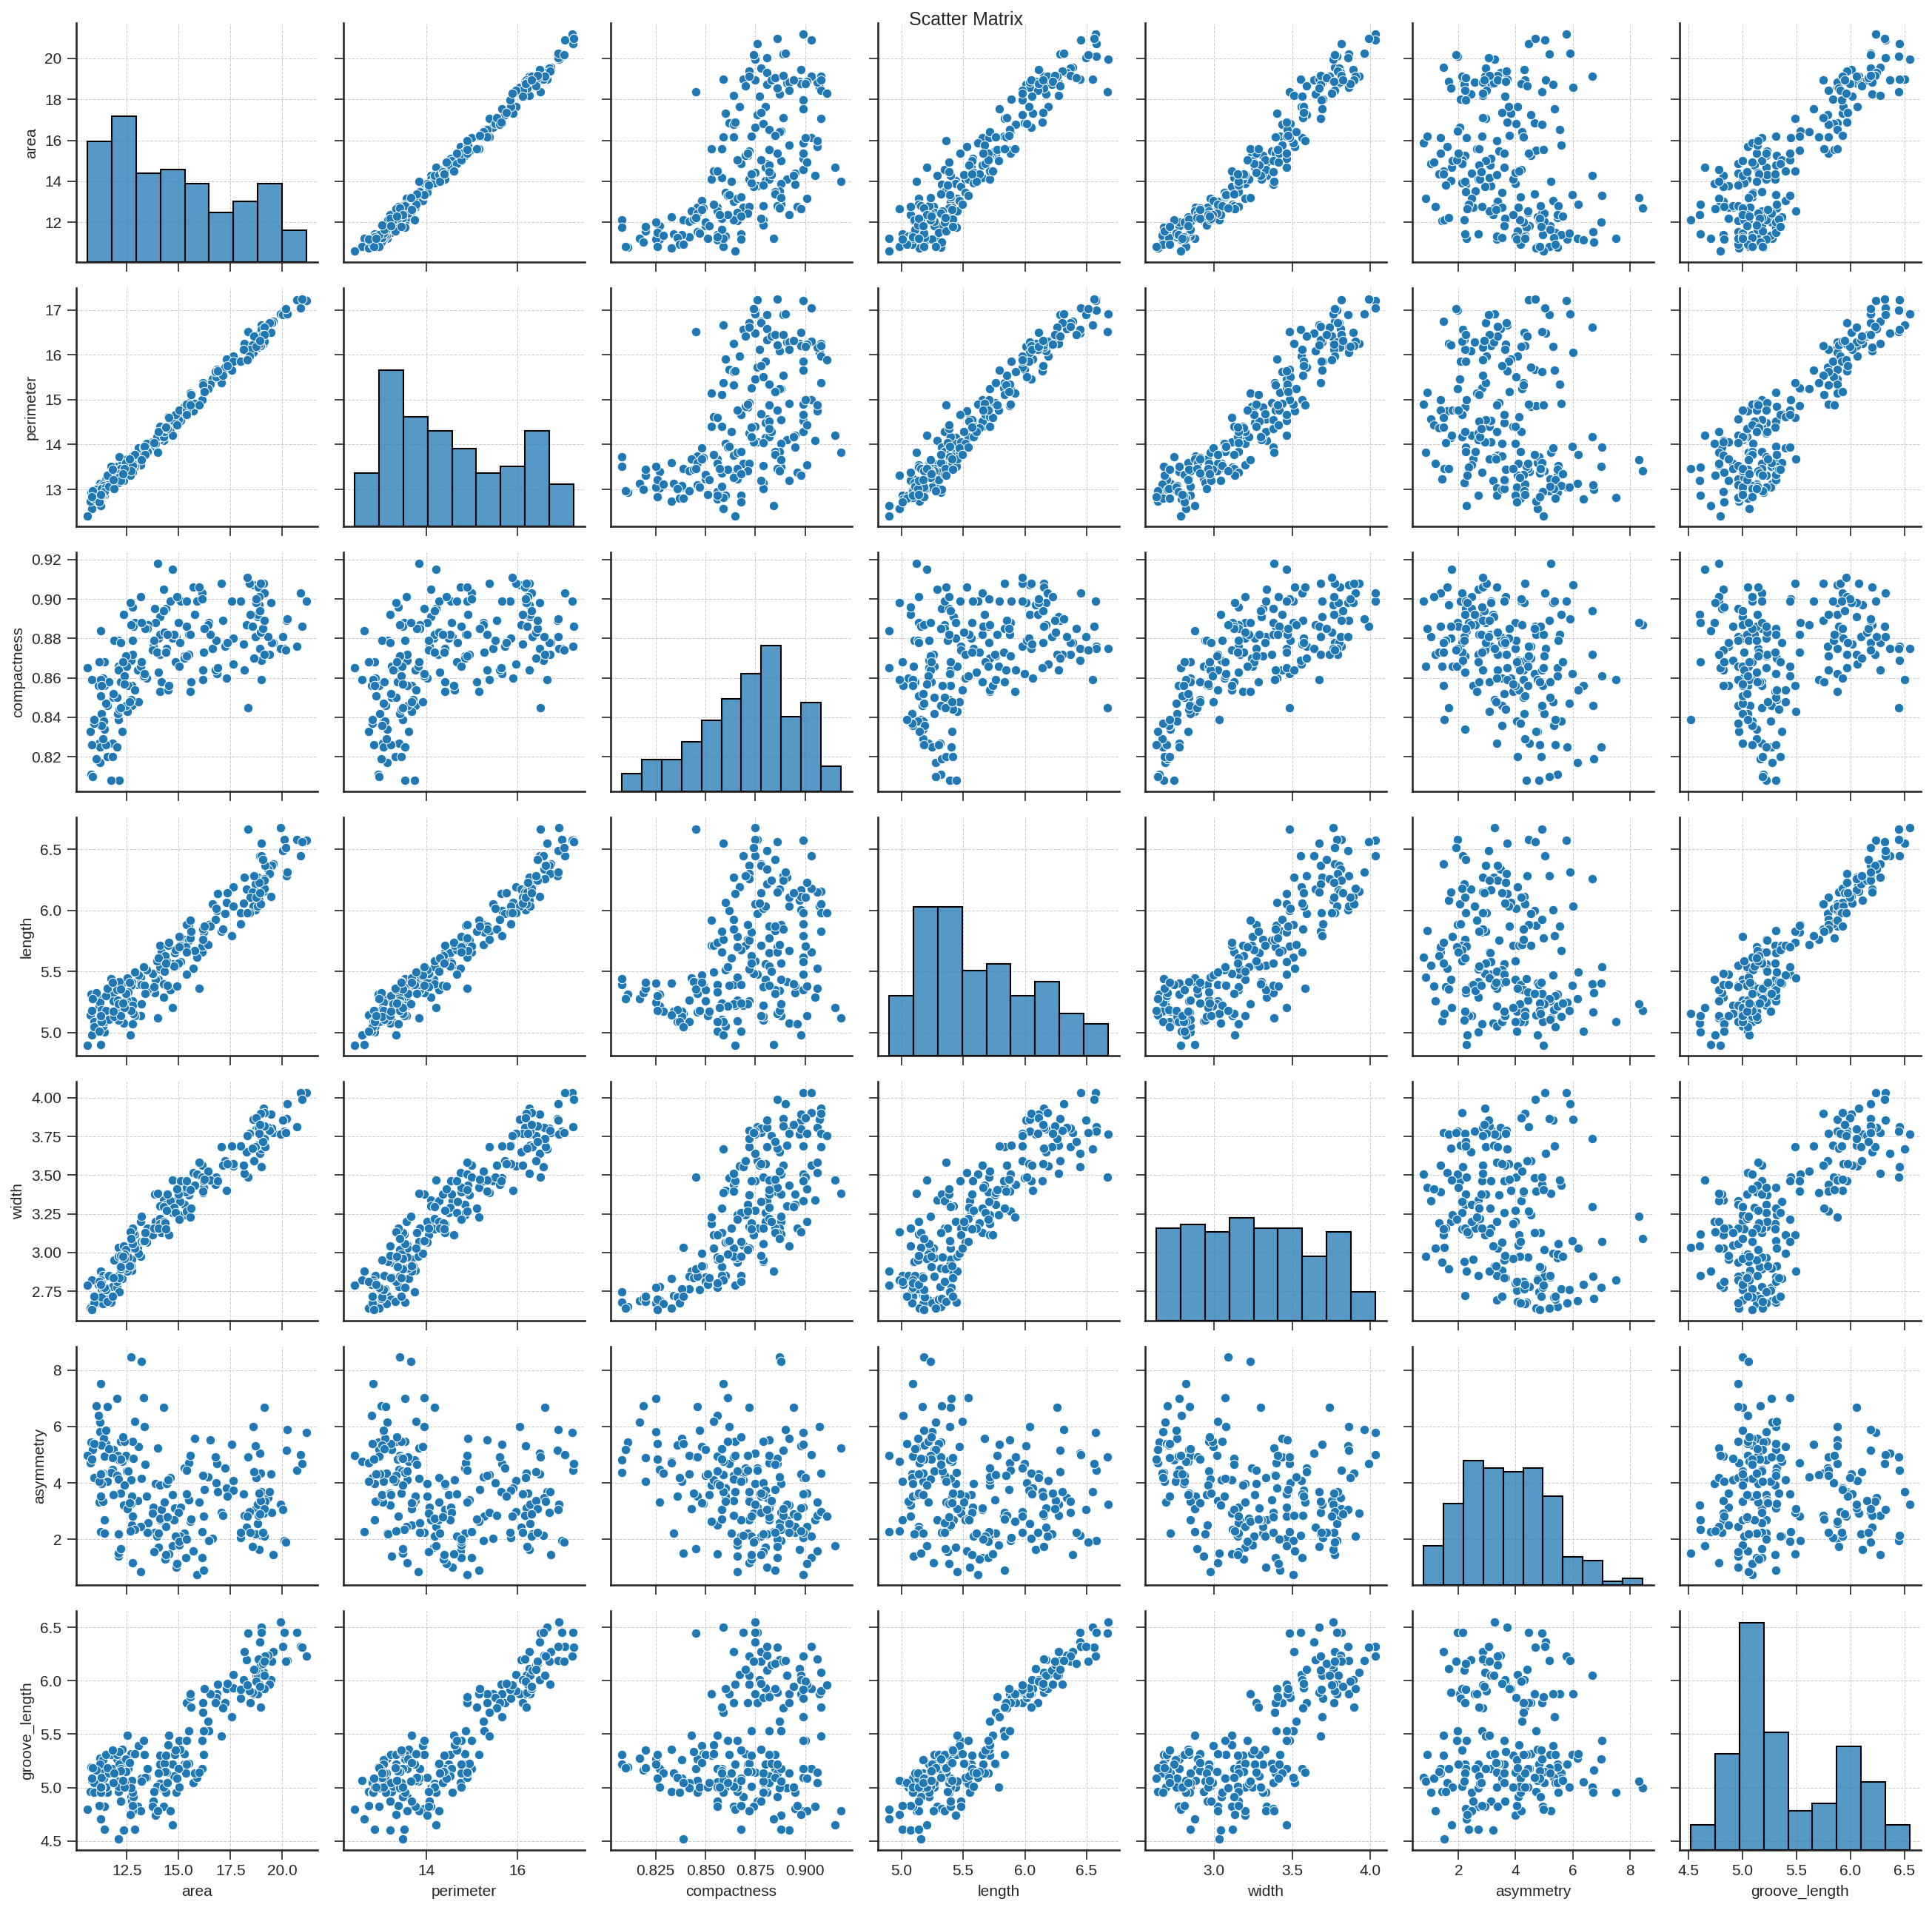

In [42]:
seeds_df = pd.read_csv("./data/seeds.csv")
sns.pairplot(seeds_df)
plt.suptitle("Scatter Matrix");

To get an understanding of the distribution of the seeds dataset, we visualise a scatter_matrix using seaborn

We perform some initial analysis this plot - 
1. Most features are distributed evenly, making it difficult to assign data points to groups.
2. `width` has a very even distribution and would not help in differentiating between groups.
3. The subplots in the bottom row of the figure show clear cluster groupings. Thus it can be said that `groove_length` is an important feature for clustering.
4. The `asymmetry` feature is also helpful for clustering although not as good as `groove_length` 

### PCA reduced data analysis

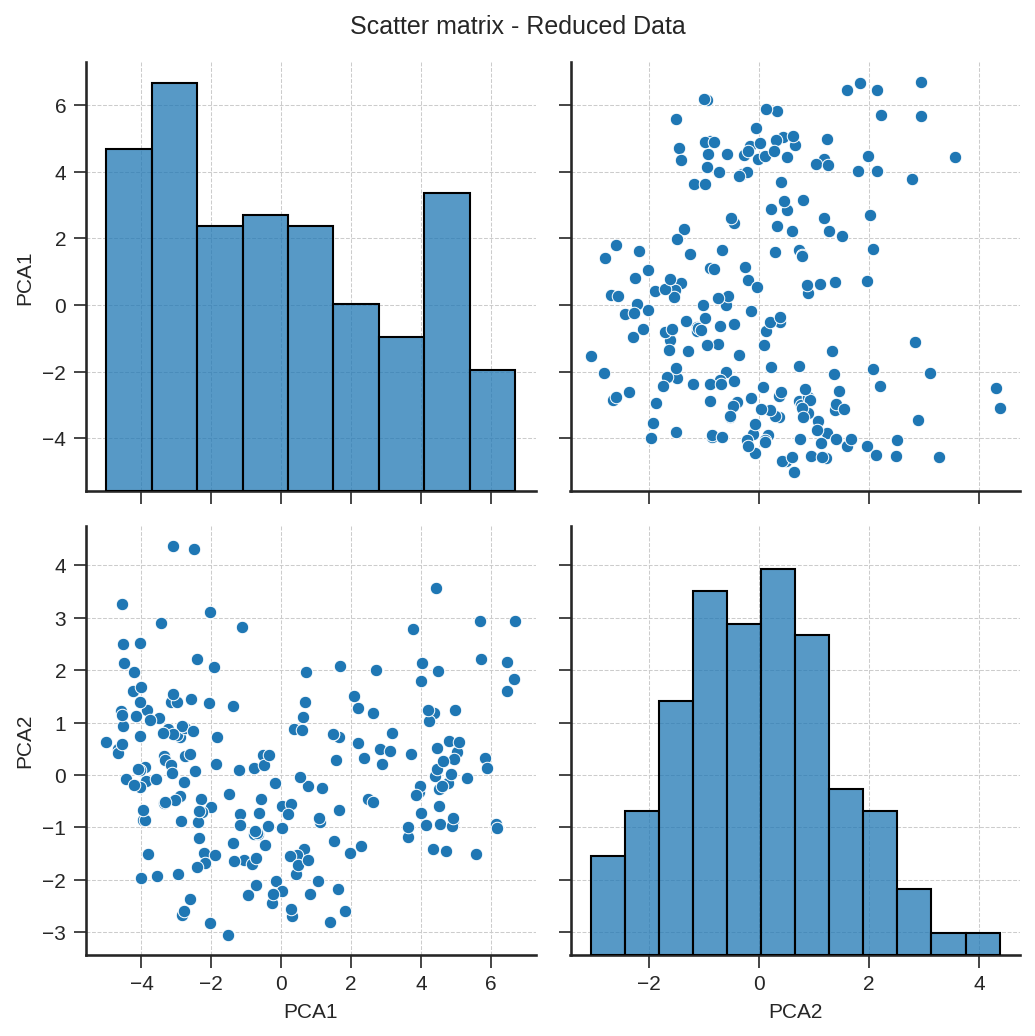

In [43]:
# Apply PCA on data
seeds_pca = PCA(n_components=2, random_state=420)
seeds_pca_df = pd.DataFrame(
    data=seeds_pca.fit_transform(seeds_df), columns=["PCA1", "PCA2"]
)

# Scatter matrix of seeds data
sns.pairplot(seeds_pca_df, height=3.5)
plt.suptitle("Scatter matrix - Reduced Data")
plt.show()


To get an understanding of how the data looks in a 2D space, we perform PCA on the dataset. This will be used to visualise clusters in 2D as well by changing the transforming the cluster centers we get from clustering algorithms.

From the above graph, we can say -
1. There are approximately 3-4 clusters in 2D
1. `DBScan` would be a bad algorithm to apply here as the density of data points in 2D does not vary very much.

Hence we will use **KMeans** and **Gaussian Mixtures** to do our clutering analysis. Although in 2 dimensions, we see a 3-4 clusters on the graph, we will still test models with a varying number of clusters from 2 clusters to 10 to be exact. This is because the 2 dimensional representation of the data using PCA is just an approximation and there might be higher dimensional relationships or groupings that we can potentially miss.

---
## KMeans

KMeans works well with uniformly distributed data. Hence KMeans is a good starting point for clustering this data.


### Workflow
1. Fit n models
3. Do silhouette analysis to get smaller subset of clusters
3. Elbow method using inertia and Average Silhouette score on smaller subset
2. For each model plot using plotting utils to further reduce the set of clusters
4. Take the best model.

### Fit models

#### Implementation Details
1. We use sklearn library to fit KMeans model onto the data.
1. Maintain a dictionary for storing metrics and properties of different models.
1. Maintain a copy of the `seeds_pca_df` for storing predictions for visualisations.
1. Set the random_state of each model to 420 for reproducability

In [44]:
# Set number of clusters
n_clusters = list(range(2, 11))

# Create metrics dict
kmeans_metrics_df = defaultdict(list)
kmeans_metrics_df["n_clusters"] = n_clusters

# Copy PCA dataframe for storing cluster labels
kmeans_labels_df = seeds_pca_df.copy(deep=True)

# Fit and evaluate models
for k in n_clusters:
    # Fit the model
    kmeans = cluster.KMeans(n_clusters=k, random_state=420)
    kmeans.fit(seeds_df)

    # Add labels to kmeans_labels_df
    kmeans_labels_df[f"{k}_clusters_labels"] = kmeans.labels_

    # Append the metrics to the dictionary
    kmeans_metrics_df["Inertia"].append(kmeans.inertia_)
    kmeans_metrics_df["Silhouette Average"].append(
        silhouette_score(seeds_df, kmeans.labels_)
    )
    kmeans_metrics_df["Silhouette Samples"].append(
        silhouette_samples(seeds_df, kmeans.labels_)
    )
    kmeans_metrics_df["Cluster Centers"].append(kmeans.cluster_centers_)

# Convert metrics dict to dataframe
kmeans_metrics_df = pd.DataFrame(kmeans_metrics_df)


### Visualising Clusters

#### Implementation Details

1. Details can be found in the `plot_kmeans` function docstring

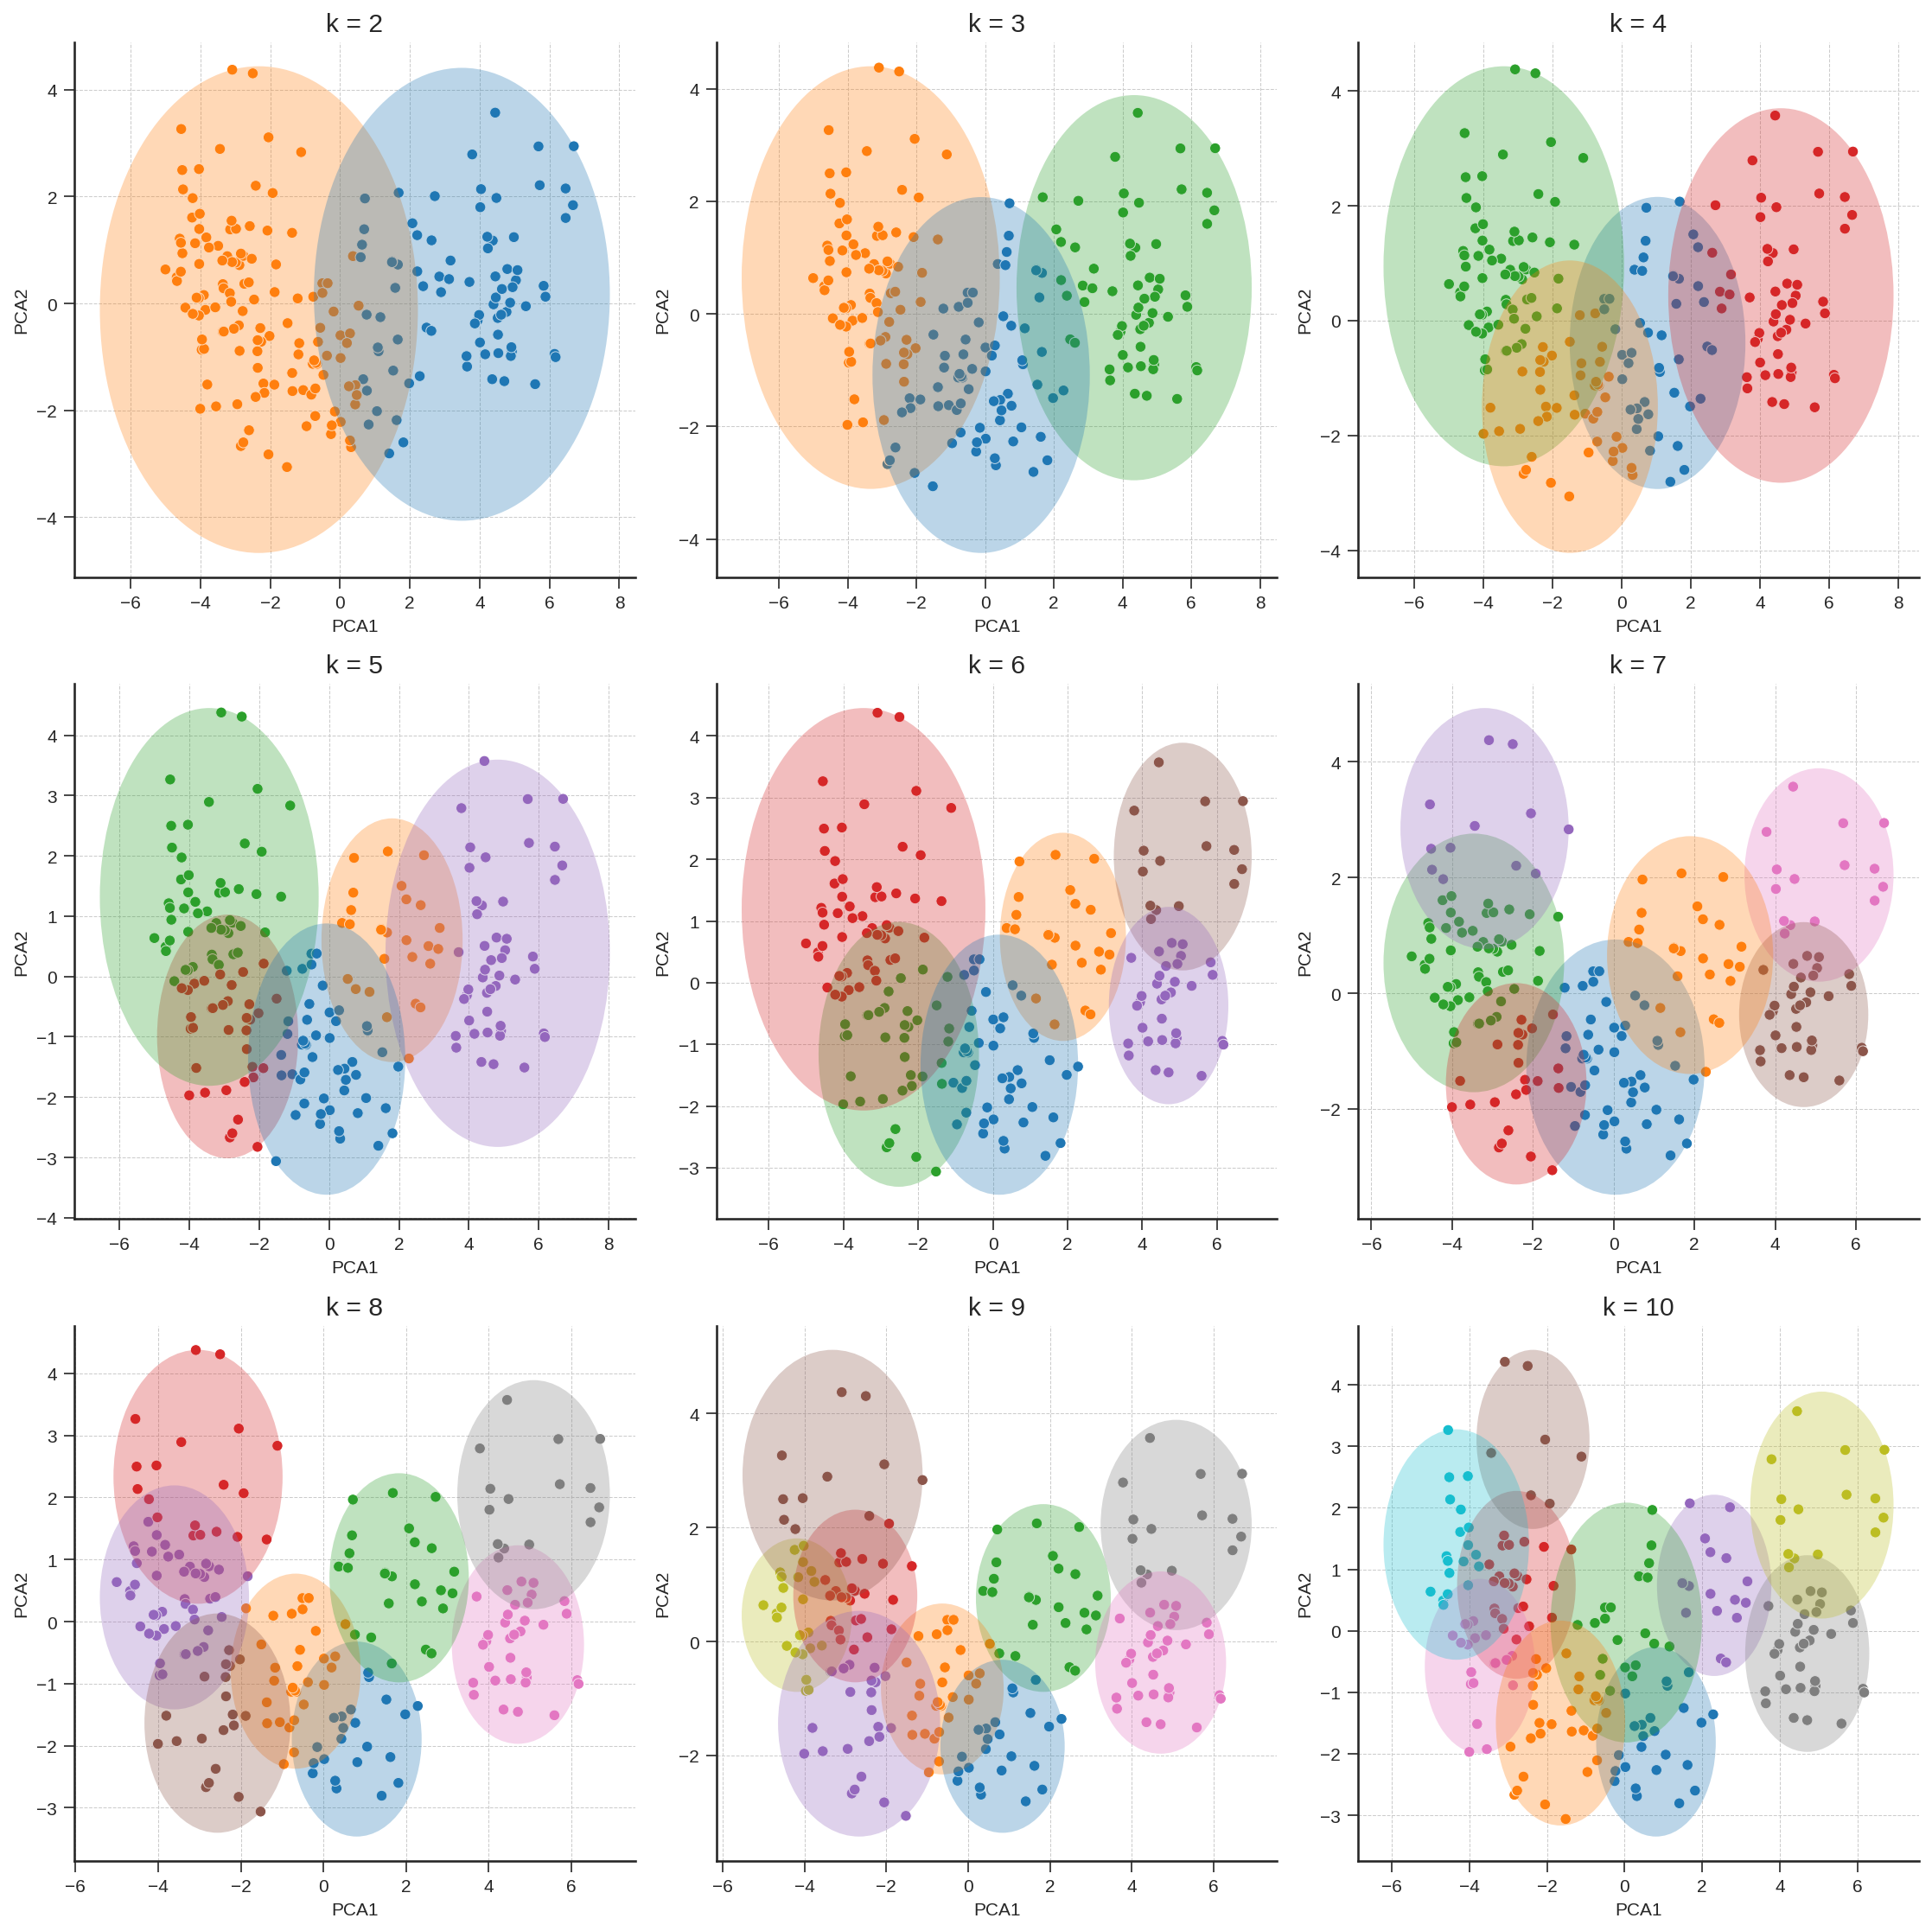

In [45]:
def plot_kmeans(
    kmeans_labels_df: pd.DataFrame,
    kmeans_metrics_df: pd.DataFrame,
    pca_model: PCA,
    k: int,
    ax=None,
):
    """
    Function to plot visualise KMeans clusters using circles.

    Args:
        kmeans_labels_df (pd.DataFrame): DataFrame containing kmeans labels and PCA datapoints for each model
        kmeans_metrics_df (pd.DataFrame): DataFrame containing properties of each model.
        pca_model (PCA): PCA model already fitted on the data
        k (int): Number of clusters to draw
        ax (_type_, optional): Axis on which to draw the figure. Defaults to None.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    # Get centers
    centers = kmeans_metrics_df.loc[kmeans_metrics_df["n_clusters"] == k, "Cluster Centers"].values[0]
    centers = pca_model.transform(centers)   # Transform the cluster centers using previously fitted PCA model

    # Get radius
    radii = [
        cdist(
            kmeans_labels_df.loc[
                kmeans_labels_df[f"{k}_clusters_labels"] == i, ["PCA1", "PCA2"]
            ],
            [center],
        ).max()
        for i, center in enumerate(centers)
    ]

    # Get color palette
    unique = kmeans_labels_df[f"{k}_clusters_labels"].unique()
    palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    # Plot clusters
    sns.scatterplot(
        kmeans_labels_df,
        x="PCA1",
        y="PCA2",
        hue=f"{k}_clusters_labels",
        ax=ax,
        palette=palette,
    )
    for c, r, col in zip(centers, radii, palette):
        ax.add_patch(plt.Circle(c, r, fc=col, lw=3, zorder=1, alpha=0.3))
    ax.set_title(f"k = {k}")
    ax.get_legend().remove()


# Create subplot figure
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plot the clusters
for i, ax in enumerate(axes):
    plot_kmeans(kmeans_labels_df, kmeans_metrics_df, seeds_pca, i + 2, ax=ax)


### Silhouette Analysis
Given $a$ mean intracluster distance and $b$ mean nearest cluster distance, then the Silhouette of a sample is defined as -
$$
C_S = \frac{b-a}{\max{(a,b)}}
$$
- Ranges from $[-1, 1]$
    - $+1 \implies$ instance is well inside its own cluster and far from neighbourhoods
    - $-1 \implies$ assigned to wrong cluster
    - $0 \implies$ cluster boundary
- The Silhouette score is the mean of the silhouette of every sample in the dataset.

#### Implementation Details

This code has been inspired from lecture notes as well as [sklearn documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html). 

Text(0.5, 0.98, 'Silhouette Analysis')

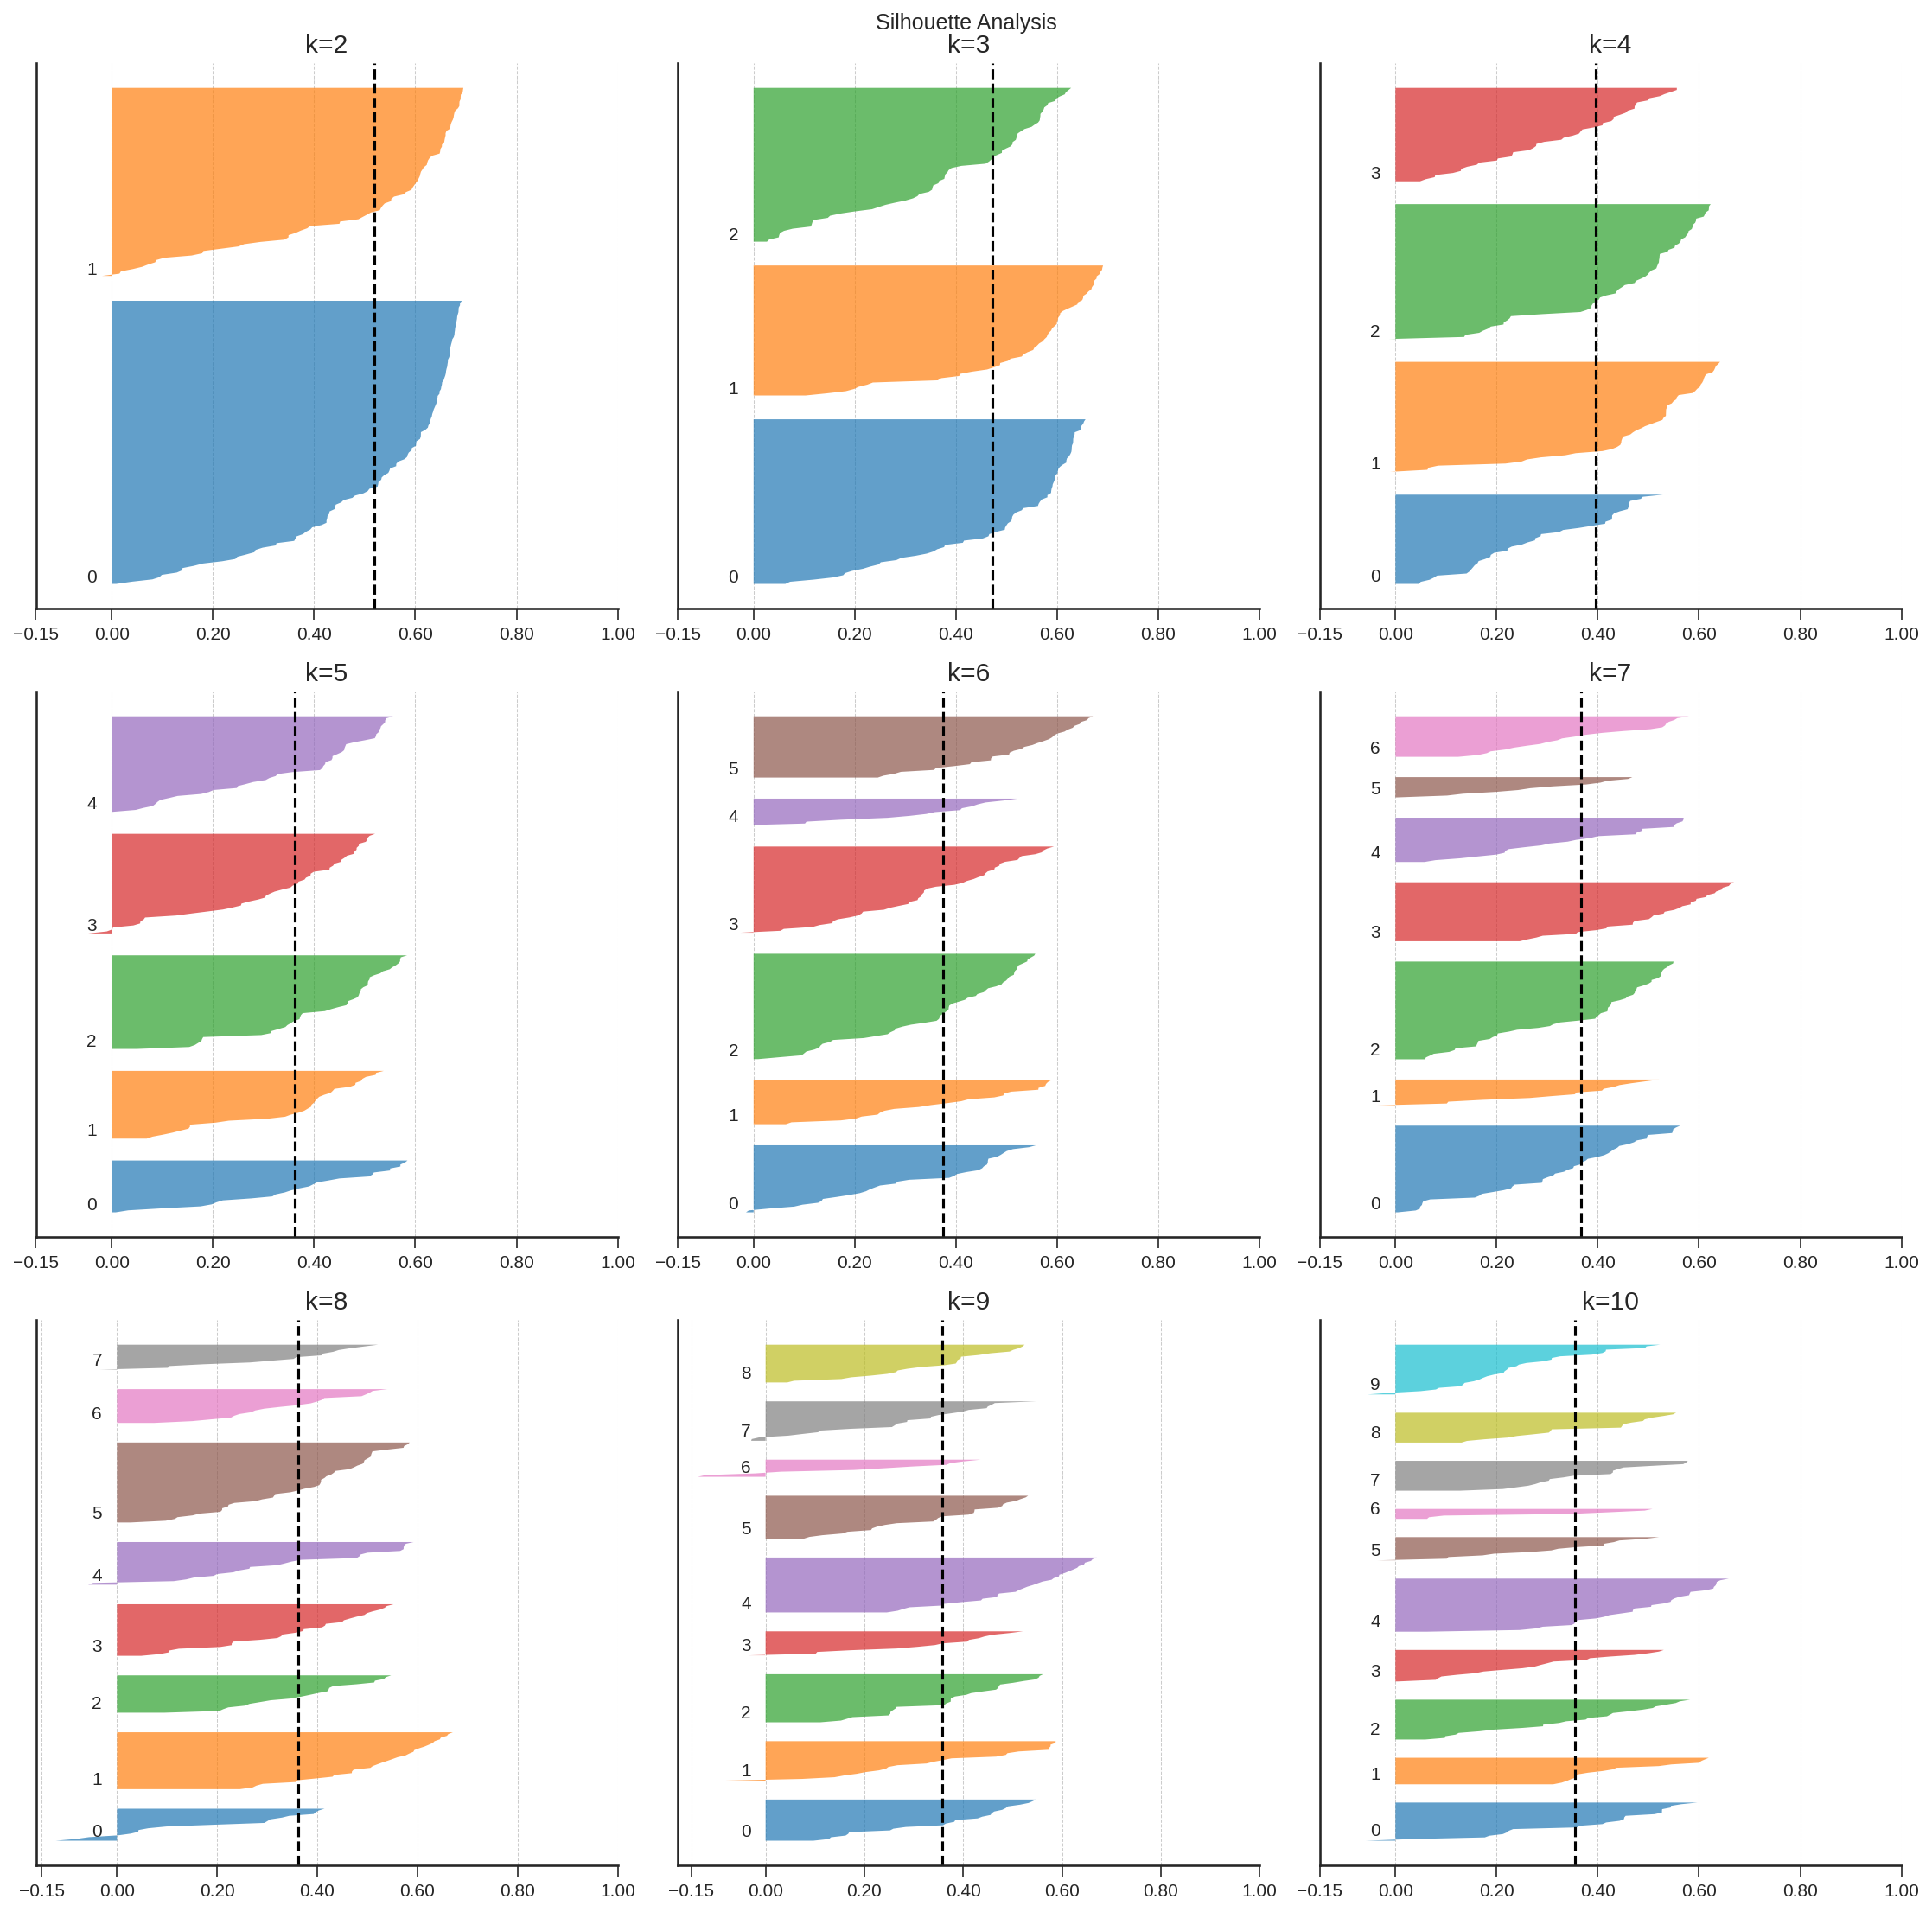

In [46]:
# Create plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Loop over all n_clusters
for k in n_clusters:
    # Get silhouette values
    sil_score = kmeans_metrics_df.loc[
        kmeans_metrics_df["n_clusters"] == k, "Silhouette Average"
    ].values[0]
    sil_values = kmeans_metrics_df.loc[
        kmeans_metrics_df["n_clusters"] == k, "Silhouette Samples"
    ].values[0]
    labels = kmeans_labels_df[f"{k}_clusters_labels"].values

    # Set lower limit for better visulaisation
    y_lower = 10

    # Loop over all clusters
    for i in range(k):
        # Get samples belonging to cluster i
        ith_cluster_sil_values = sil_values[labels == i]
        ith_cluster_sil_values.sort()

        # Get y_upper
        num_samples = ith_cluster_sil_values.shape[0]
        y_upper = num_samples + y_lower

        # Create the plot
        axes[k - 2].fill_betweenx(
            np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, alpha=0.7
        )
        # Label the silhouette plots with their cluster numbers at the middle
        axes[k - 2].text(-0.05, y_lower + 0.3 * k, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    axes[k - 2].set_title(f"k={k}")
    axes[k - 2].axvline(x=sil_score, color="black", linestyle="--")

    axes[k - 2].set_yticks([])  # Clear the yaxis labels / ticks
    axes[k - 2].set_xticks([-0.15, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle("Silhouette Analysis")


#### Analysis
From the above graph, we can see that when

- **n_clusters = [2, 3. 4]**
    - The sizes of each cluster is big and somewhat even
    - All the clusters easily cross the average silhouette score  

<break>

- **n_clusters = 5**
    - The cluster sizes are not exactly even but most of them roughly the same size 
    - All the clusters easily cross the average silhouette score
    - *Cluster 3* have some negative silhouette scores but not enough to discard the model


<break>

- **n_clusters = 6**
    - The cluster sizes are uneven but not enough to discard the model 
    - All the clusters easily cross the average silhouette score
    - *Clusters [0, 4]* have some negative silhouette scores but not enough to discard the model

<break>

- **n_clusters = 7**
    - Cluster sizes are uneven enough to discard the model
    - *Cluster 1* has some negative silhouette scores but not enough to discard the model

<break>

- **n_clusters = 8**
    - Cluster sizes are completely uneven
    - *Cluster 0* barely crosses the average silhouette score
    - *Clusters [0, 4]* also have negative silhouette scores for some samples

<break>

- **n_clusters = 9**
    - Cluster sizes are somewhat even but very small indicating that there are too many clusters
    - *Cluster 6* barely crosses the average silhouette score
    - *Cluster [1, 3, 6, 7]* also have negative silhouette scores for some samples

<break>

- **n_clusters = 10**
    - Cluster sizes are somewhat even but very small indicating that there are too many clusters
    - *Clusters [0, 5, 9]* have negative silhouette scores for some samples

<break>

Hence we will remove the models with n_clusters in [8, 9, 10] and proceed with the elbow method using Inertia score for choosing the best model

### Filter the Models set and plot the inertia scores

#### Implementation Details

1. First we filter the dataframe containing and consider only models with `n_clusters <= 7`.
1. Then we create a new metric - `Silhouette Average*1000`. This is just the Silhouette Average Score multiplied by 1000. This is just so that we can plot `Inertia` and `Silhouette Average * 1000` on the same figure

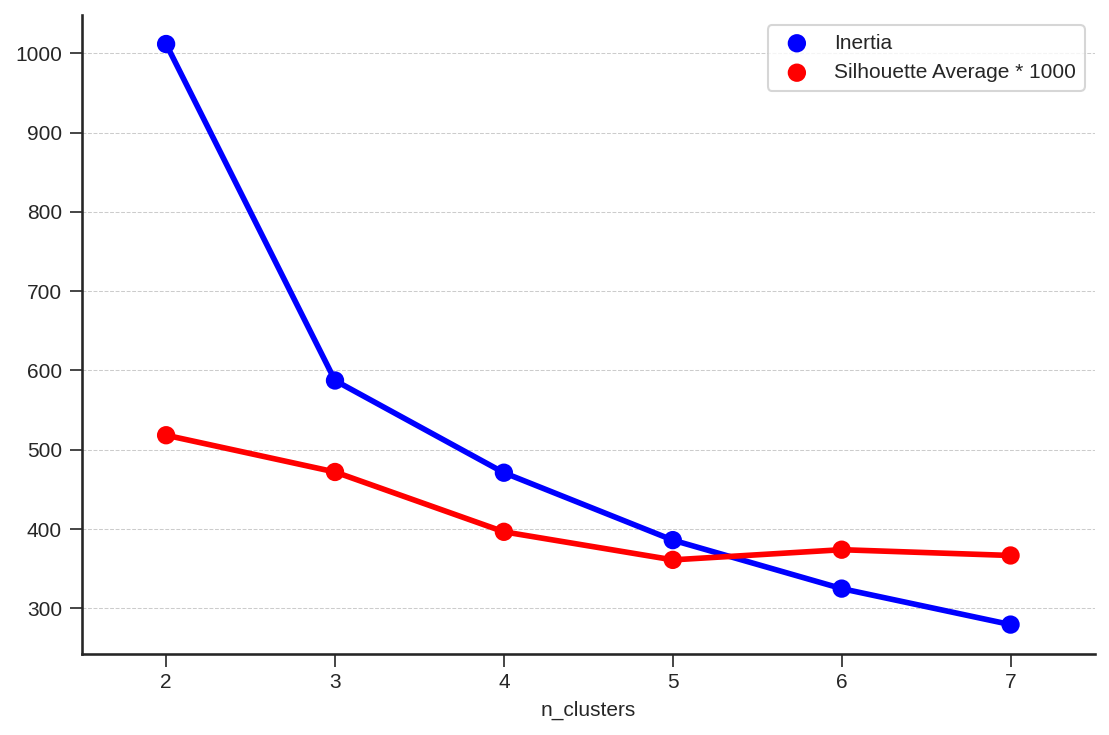

In [47]:
# Filter the dataset and Create a metric - Average Silhouette * 1000 for comparision on the same graph
kmeans_metrics_df = kmeans_metrics_df.loc[kmeans_metrics_df["n_clusters"] <= 7, :]
kmeans_metrics_df["Silhouette Average*1000"] = (
    kmeans_metrics_df["Silhouette Average"] * 1000
)

# Plot the metrics
sns.pointplot(
    kmeans_metrics_df, x="n_clusters", y="Inertia", color="blue", label="Inertia"
)
sns.pointplot(
    kmeans_metrics_df,
    x="n_clusters",
    y="Silhouette Average*1000",
    color="red",
    label="Silhouette Average * 1000",
)
plt.ylabel("")
plt.legend();


### Result

From this graph we see that the optimal tradeoff is achieved when `n_clusters = 3`. 

Hence we conclude that **n_clusters = 3** is optimal number of clusters for this dataset when we do `KMeans` clustering.

---
## Gaussian Mixture Models

While KMeans works well, it does not give probability of a sample belonging to a cluster. Gaussian Mixture Models on the other hand give the probabilities for each cluster. This gives a confidence score for the predictions made and can help improve the model


### Workflow
1. Fit n models
2. Visulaize the models by drawing ellipsoids.
3. Calculate AIC and BIC scores of each model.
4. Take the best model using AIC and BIC.

### Fit models

#### Implementation Details
1. Implementation is similar to the KMeans code above
1. We use sklearn library to fit GaussianMixture model onto the data.
1. Maintain a dictionary for storing metrics and properties of different models.
1. Maintain a copy of the `seeds_pca_df` for storing predictions for visualisations.
1. Set the random_state of each model to 420 for reproducability

In [48]:
# Set number of clusters
n_clusters = list(range(2, 11))

# Create metrics dict
gmm_metrics_df = defaultdict(list)
gmm_metrics_df["n_clusters"] = n_clusters

# Copy PCA dataframe for storing cluster labels
gmm_labels_df = seeds_pca_df.copy(deep=True)

# Fit and evaluate models
for k in n_clusters:
    # Fit the model
    gmm = GaussianMixture(n_components=k, random_state=420)
    gmm.fit(seeds_df)

    # Add labels to gmm_labels_df
    gmm_labels_df[f"{k}_clusters_labels"] = gmm.predict(seeds_df)

    # Append the metrics to the dictionary
    gmm_metrics_df["Weights"].append(gmm.weights_)
    gmm_metrics_df["Means"].append(gmm.means_)
    gmm_metrics_df["Covariances"].append(gmm.covariances_)
    gmm_metrics_df["AIC"].append(gmm.aic(seeds_df))
    gmm_metrics_df["BIC"].append(gmm.bic(seeds_df))

# Convert metrics dict to dataframe
gmm_metrics_df = pd.DataFrame(gmm_metrics_df)


### Visualising Models
#### Implementation Details

Details can be found in the `plot_kmeans` function docstring

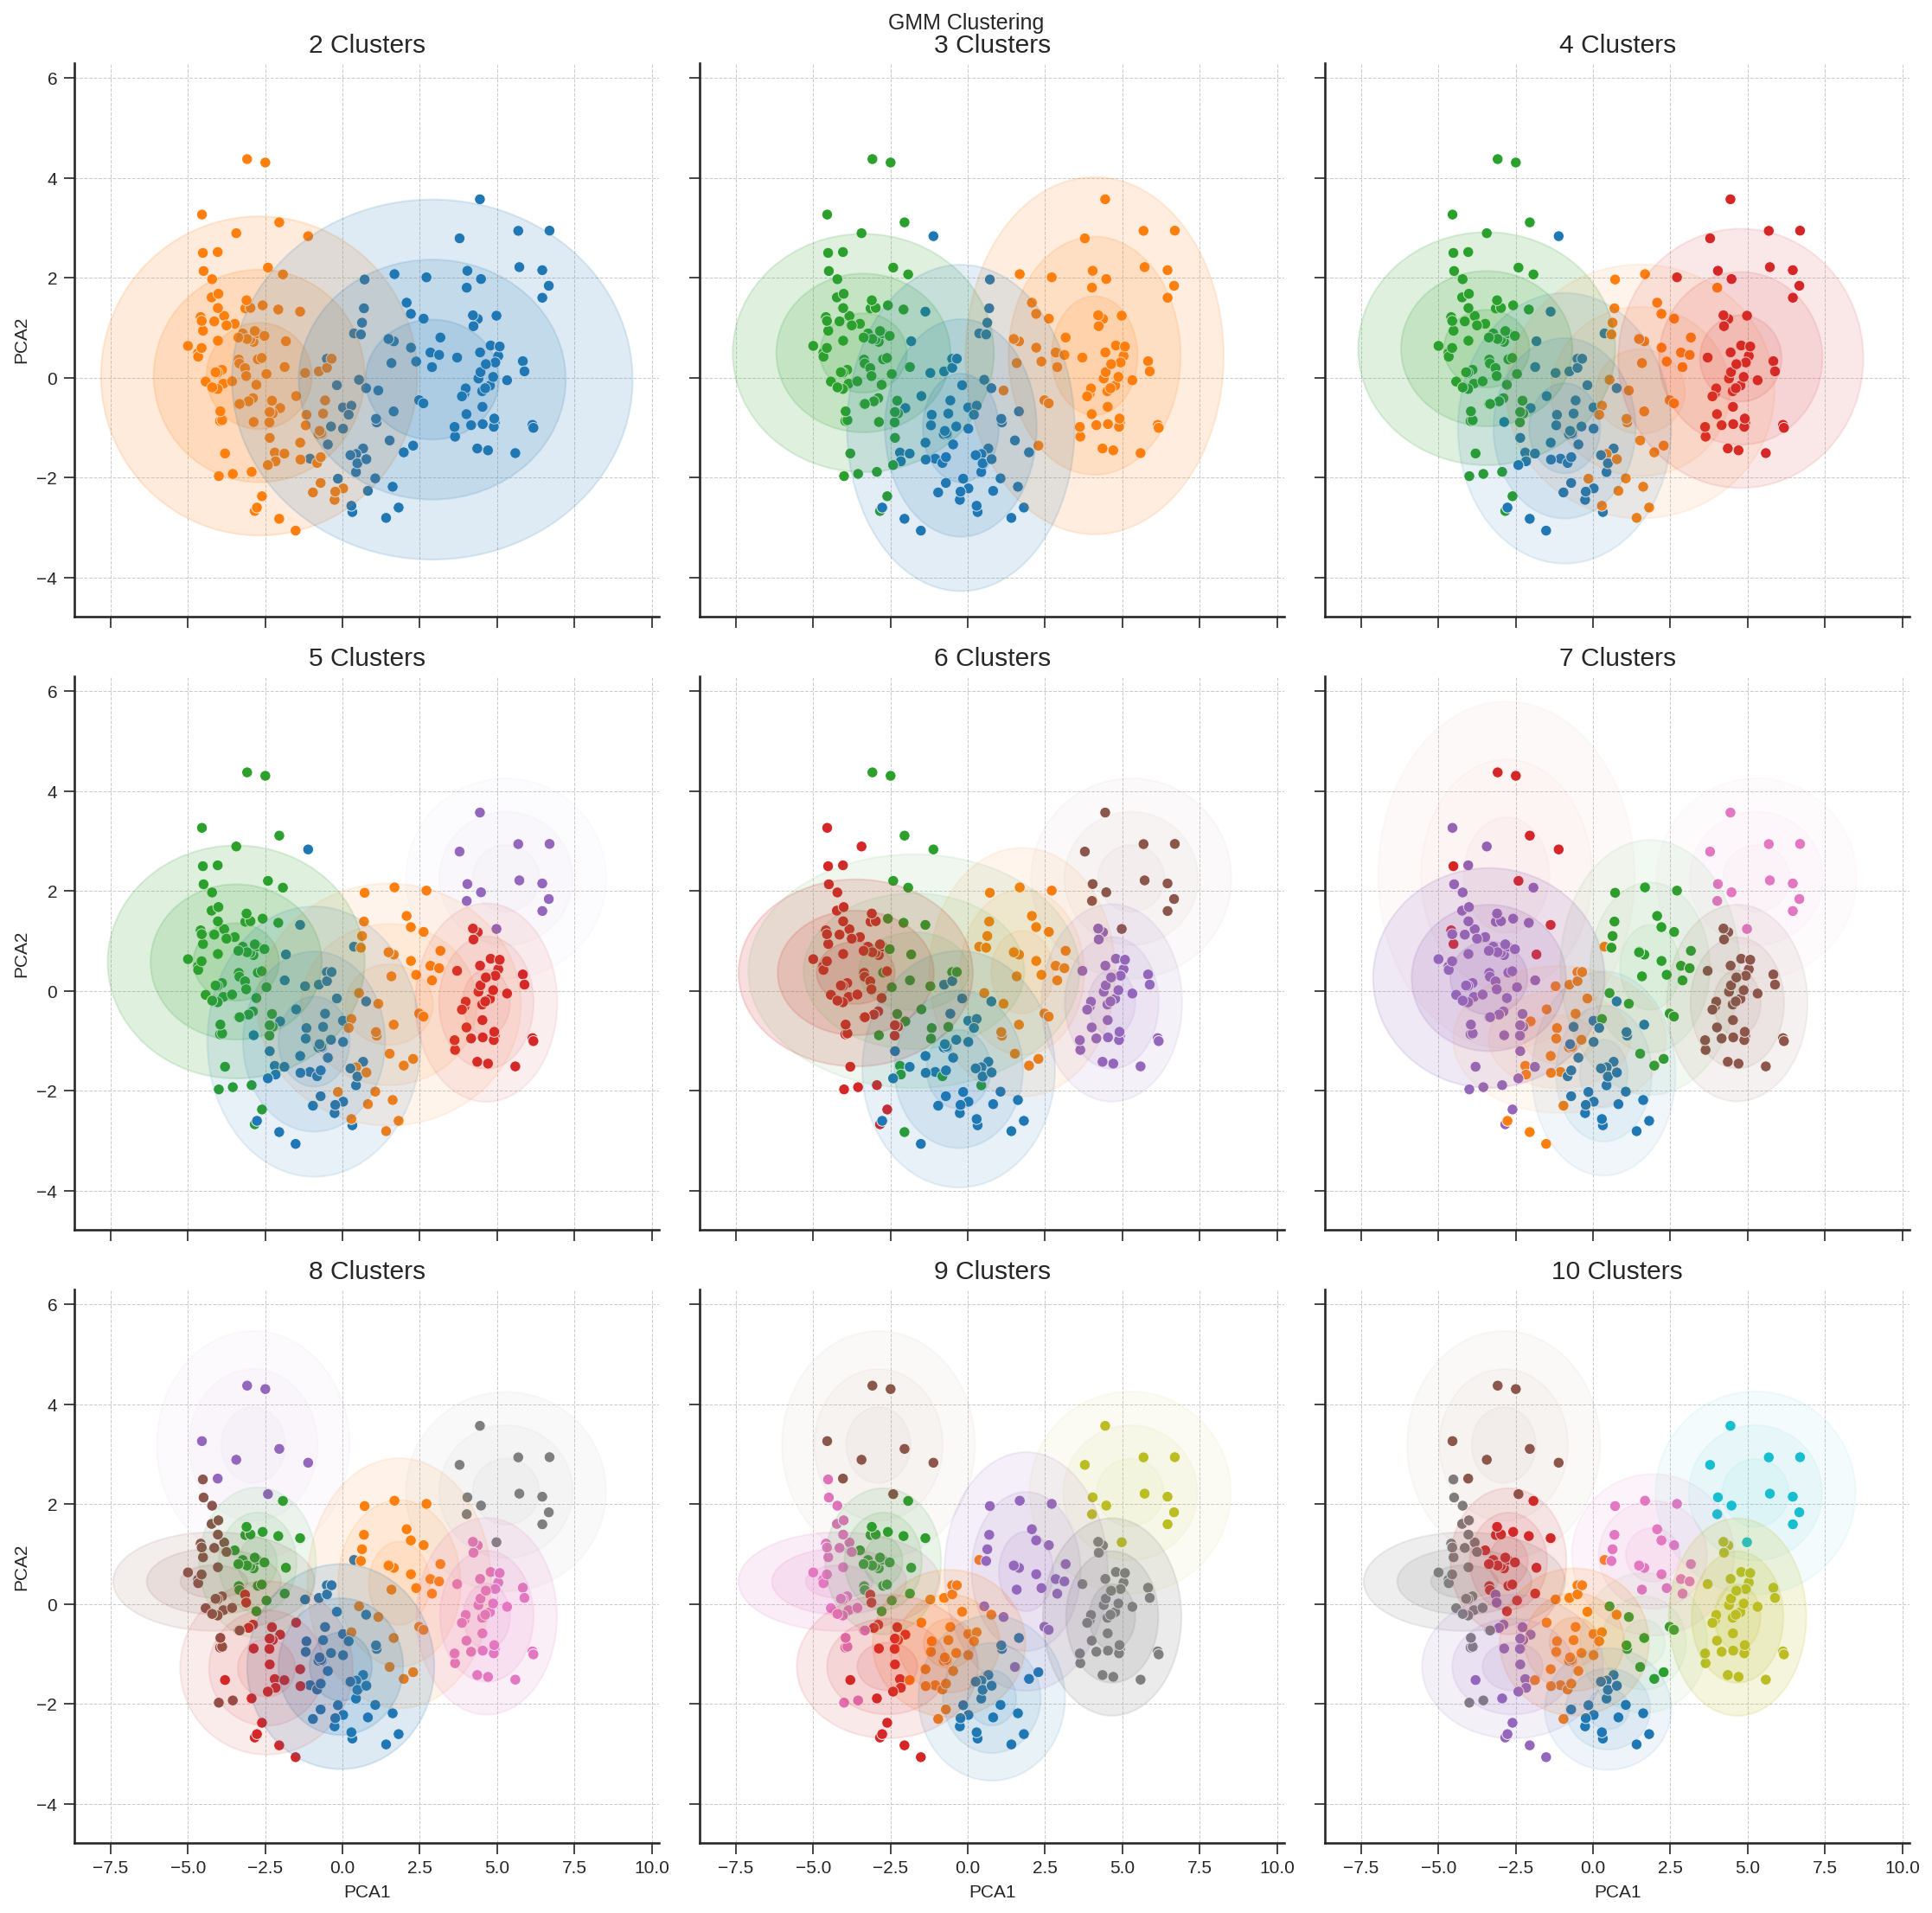

In [49]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance

    Inspired By: VanderPlas, Jake (2016). Python Data Science Handbook. O'Reilly Media, Inc. ISBN: 9781491912058
    """
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        U, s, Vt = np.linalg.svd(covariance)
        width, height = 2 * np.sqrt(s[:2])

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position[0], nsig * width, nsig * height, angle, **kwargs))


def plot_gmm(
    gmm_metrics_df: pd.DataFrame,
    gmm_labels_df: pd.DataFrame,
    pca_model: PCA,
    k: int,
    ax=None,
):
    """Plot the GMM clusters with varying levels of certainty.
    
    Inspired By: VanderPlas, Jake (2016). Python Data Science Handbook. O'Reilly Media, Inc. ISBN: 9781491912058
    
    Args:
        gmm_labels_df (pd.DataFrame): DataFrame containing gmm labels and PCA datapoints for each model
        gmm_metrics_df (pd.DataFrame): DataFrame containing properties of each model.
        pca_model (PCA): PCA model already fitted on the data
        k (int): Number of clusters to draw
        ax (_type_, optional): Axis on which to draw the figure. Defaults to None.
        reverse (bool, optional): Reverse the palette colors. Defaults to False.
    """

    # Get palette
    unique = gmm_labels_df[f"{k}_clusters_labels"].unique()
    palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
    palette = list(map(lambda x: x[1], sorted(palette.items())))

    sns.scatterplot(
        gmm_labels_df,
        x="PCA1",
        y="PCA2",
        hue=f"{k}_clusters_labels",
        palette=palette,
        ax=ax,
    )

    # Get metrics
    weights = gmm_metrics_df.loc[gmm_metrics_df["n_clusters"] == k, "Weights"].values[0]
    means = gmm_metrics_df.loc[gmm_metrics_df["n_clusters"] == k, "Means"].values[0]
    covariances = gmm_metrics_df.loc[gmm_metrics_df["n_clusters"] == k, "Covariances"].values[0]

    # Draw ellipse
    w_factor = 0.15 / weights.max()
    for pos, covar, w, c in zip(means, covariances, weights, palette):
        draw_ellipse(
            position=pca_model.transform(pos.reshape(-1, 7)),   # Transform the cluster centers using previously fitted PCA model
            covariance=covar,
            alpha=w * w_factor,
            ax=ax,
            color=c,
        )

    # Set title
    ax.set_title(f"{k} Clusters")


fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    plot_gmm(gmm_metrics_df, gmm_labels_df, seeds_pca, i + 2, ax=ax)
    ax.get_legend().remove()
plt.suptitle("GMM Clustering");

### Model Selection

**Akaike Information Criterion (AIC)**
- It is a measure of relative fit of several statistical models to data.
- Used to select which model best represents the data, in other words the model that most adequately describes and unkonwn, high dimensional reality.
- AIC presents the danget of overfitting.
- *Lower the score, better the model.*
- Given observed data $x$, num parameters $k$, MLE of the parameters $\hat\theta$ and model likelihood $L$, the AIC is calculated as 
$$
AIC = 2k - 2\log(L(\hat\theta|x))
$$


**Bayesian Information Criterion (BIC)**
- Related AIC, but gives a stronger penalty based on the number of parameters.
- Used to select a True model among the set of candidates.
- BIC presents the danger of underfitting the model by penalising it too much.
- *Lower the score, better the model.*
- Given observed data $x$, num parameters $k$, MLE of the parameters $\hat\theta$ and model likelihood $L$, the AIC is calculated as 
$$
BIC = k\log(n) - 2\log(L(\hat\theta|x))
$$

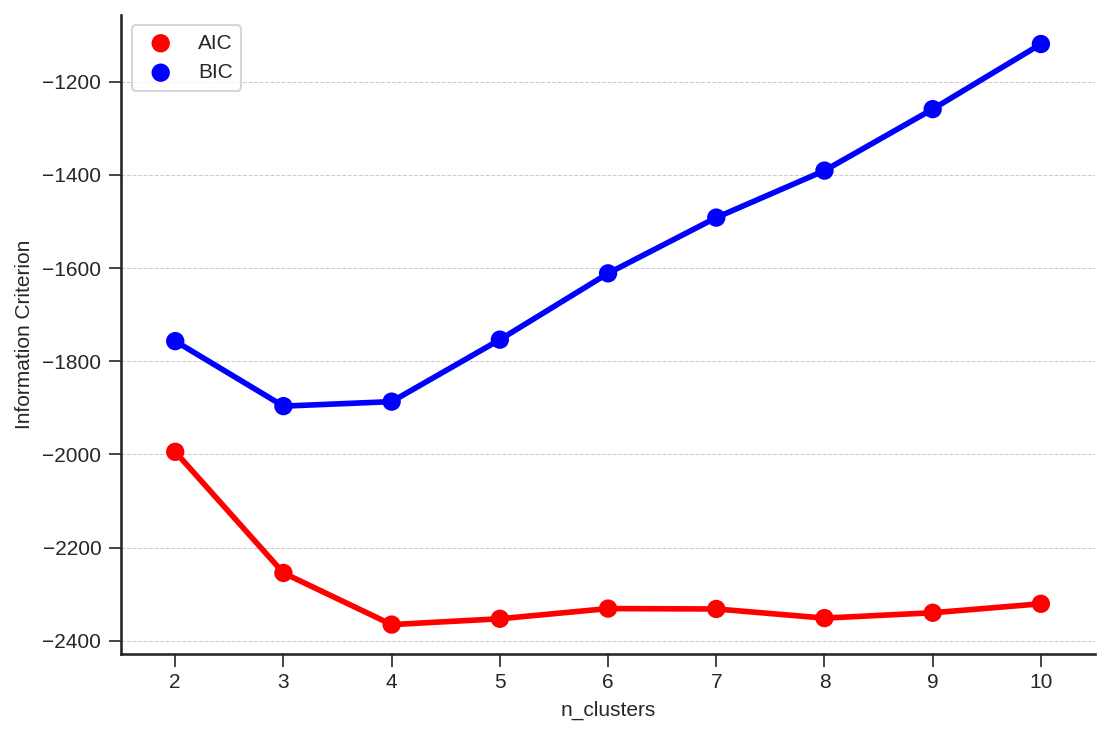

In [50]:
# AIC, BIC
sns.pointplot(gmm_metrics_df, x="n_clusters", y="AIC", color="red", label="AIC")
sns.pointplot(gmm_metrics_df, x="n_clusters", y="BIC", color="blue", label="BIC")
plt.ylabel("Information Criterion")
plt.legend();

### Result

From this graph we see that the optimal model is obtained when `n_components = 4`. 

Hence we conclude that **n_components = 4** is optimal number of components for this dataset when we do `Gaussian Mixture` clustering.

## Compare KMEans and GMM

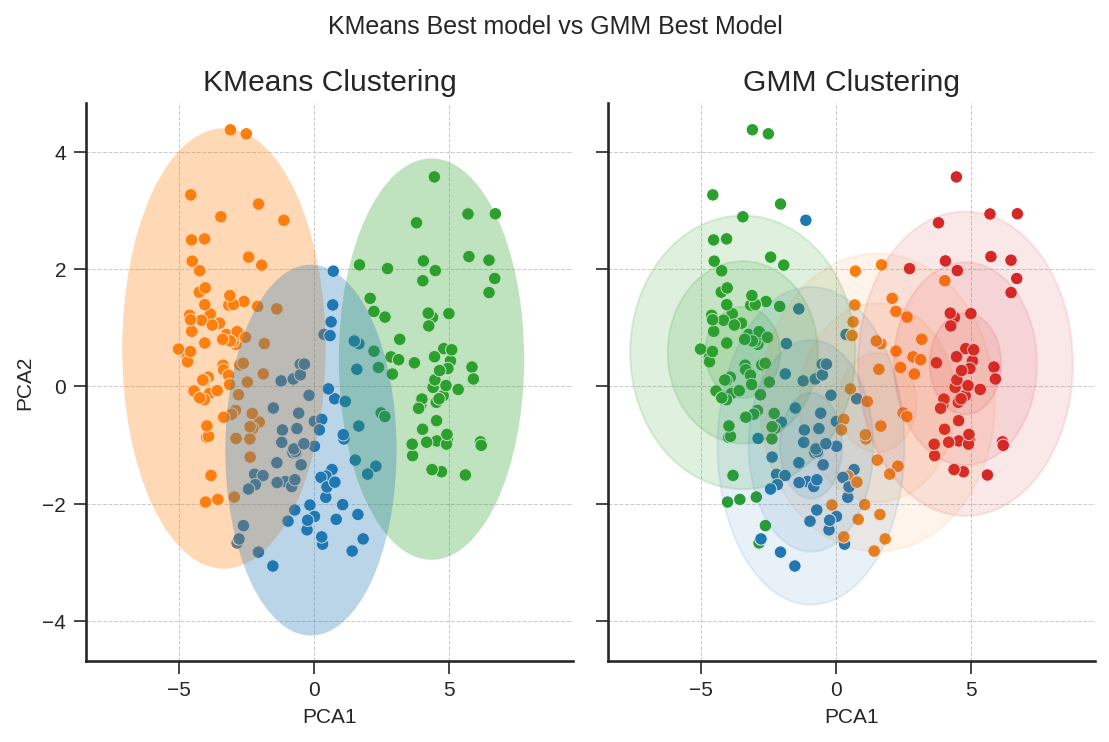

In [51]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes = axes.flatten()

plot_kmeans(kmeans_labels_df, kmeans_metrics_df, seeds_pca, 3, ax=axes[0])
axes[0].set_title("KMeans Clustering")

plot_gmm(gmm_metrics_df, gmm_labels_df, seeds_pca, 4, ax=axes[1])
axes[1].set_title("GMM Clustering")
axes[1].get_legend().remove()

plt.suptitle(f"KMeans Best model vs GMM Best Model")
plt.show();

### Result

Comparing these 2 we see that both GMM and KMeans have done a similar job of clustering the data samples. 

In [52]:
# If facing with memory issues run this cell!

# WARNING: 
# This will effectively reset the jupyter notebook and erase all variables
# and has been provided to refresh the notebook between different tasks.

%reset -f

---
# Task 3 - Network Analysis

## Imports and Settings

In [53]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import sys
import time
import warnings
from collections import defaultdict
from ipywidgets import widgets, Layout
from IPython.display import display
from IPython.display import Markdown as md

import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import networkx as nx

In [54]:
# Matplotlib Settings
plt.style.use(["seaborn-ticks"])
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = "x-large"
sns.set(rc=dict(plt.rcParams))


## Reading Data

**Implementation Details**
1. Open the data file using inbuilt `open` function.
1. Create a set of edges.
1. Use the list to create a `Graph` object for further analysis.

**Preprocessing for List of Edges**
1. Convert str to int.
1. Sort each of the edges to easily identify duplicates.
1. Save as set to automatically remove duplicates.

In [55]:
# Convert str to int
str_to_int = lambda x: map(int, x)

# Convert type, sort the list and save as tuple
preprocess_edge_list = lambda x: map(lambda i: tuple(sorted(str_to_int(i))), x)

with open("data/social-network.csv", "r") as f:
    edge_list = [line.split(",") for line in f]  # Get list of edges 
    
    # Preprocess the edges and save as set to remove duplicates
    edge_list = set(preprocess_edge_list(edge_list))
    
    nx_graph = nx.from_edgelist(edge_list)       # Create Graph object
    del edge_list                                # Delete edge_list for memory
    
print(f"Number of edges: {nx_graph.number_of_edges()}")
print(f"Number of nodes: {nx_graph.number_of_nodes()}")

Number of edges: 2981
Number of nodes: 2888


## Statistics

### Degree
- The degree of a node in a network is the number of edges the node has connected to it.
- By visualising the distribution of degrees of each node, we can get an idea of how connected the network is.

#### Implementation Details

**Degree Statistics**
- We create a DataFrame containing all the nodes in the network and it's respective degree. 
- We calculate the frequency and unique values of degrees by using the `value_counts()` method on the `Degree` column.

**Visualisation**
- We generate a degree distribution using `nx.degree_histogram` builtin function from the `networkx` module.
- Since the frequency of the degrees for the given data varies from 0-2970, we visualise the distribution by applying a `log10` transform to the frequency axis.

Frequency of Degree:
1      2790
2        82
3         3
4         3
55        1
58        1
97        1
139       1
170       1
221       1
287       1
481       1
710       1
769       1
Name: Degree, dtype: int64

Some Highly Connected Nodes: 
Node   603 is highly connected with a maximum degree of  769
Node  1525 is highly connected with a maximum degree of  710
Node   288 is highly connected with a maximum degree of  481
Node     1 is highly connected with a maximum degree of  287
Node   710 is highly connected with a maximum degree of  221
Node  2687 is highly connected with a maximum degree of  170
Node   714 is highly connected with a maximum degree of  139


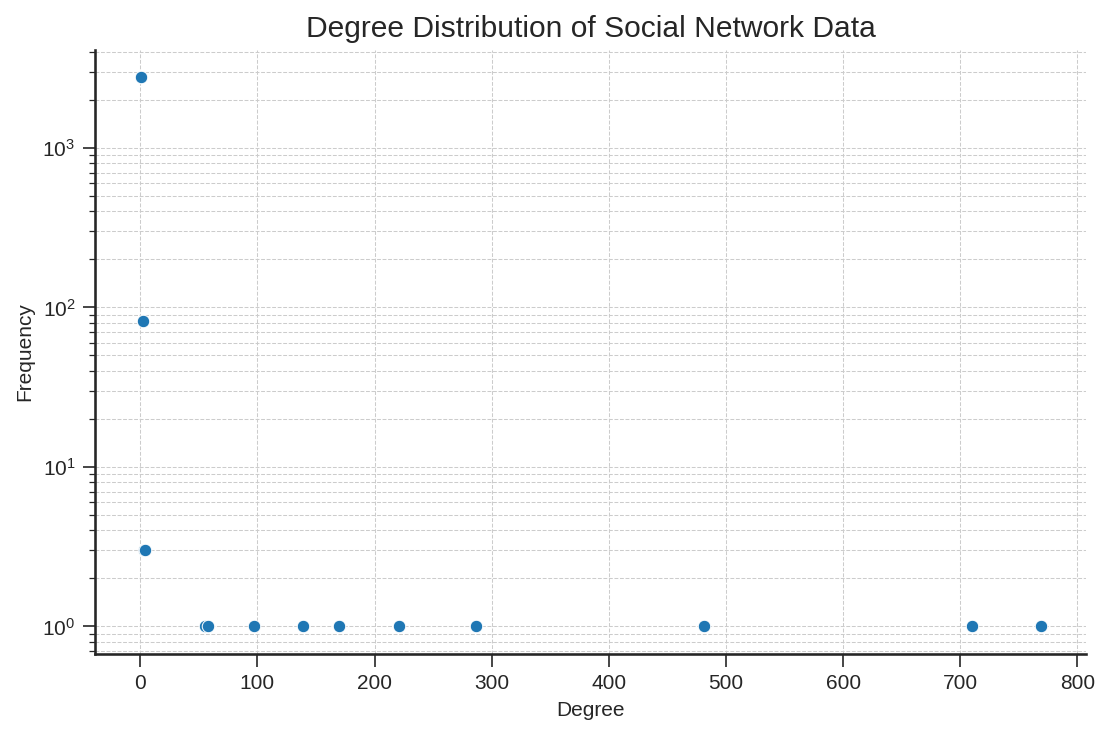

In [56]:
# Create DF of each node and its degree
node_deg_df = pd.DataFrame(
    sorted(nx_graph.degree(), key=lambda x: x[1], reverse=True),
    columns=["Node", "Degree"],
)
print("Frequency of Degree:")
print(node_deg_df["Degree"].value_counts().sort_index(ascending=True))

print("\nSome Highly Connected Nodes: ")
for deg in node_deg_df['Degree'].loc[node_deg_df['Degree'] > 100]:
    print(
        "Node {: 5d} is highly connected with a maximum degree of {: 4d}".format(
            node_deg_df.loc[node_deg_df["Degree"] == deg, "Node"].values[0], deg
        )
    )

# Degree distribution
ddist = nx.degree_histogram(nx_graph)
sctr_plt = sns.scatterplot(x=range(len(ddist)), y=ddist, marker="o")
sctr_plt.set(yscale="log")
plt.title("Degree Distribution of Social Network Data")
plt.ylabel("Frequency")
plt.xlabel("Degree");

#### Analysis
- There are no 0 degree nodes.
- There are many leaf nodes in the network (1 degree nodes)
- There are 7 highly connected nodes with a degree > 100.
- Given above data, it can be hypothesised that most of the edges are towards leaf nodes from the highly connected nodes.

### Connected components
- Set of nodes from which it is possible to reach all other nodes in the set.
- This gives an idea of the most important nodes in the network.
- If there are multiple connected components, the network is disjointed.

#### Implementation Details
- `networkx` module has an inbuilit function `number_connected_components` for the that gives us this statistic.

In [57]:
print("Number of Components: {}".format(nx.number_connected_components(nx_graph)))

Number of Components: 1


#### Analysis
- Thus we can see that the network is not disjointed.

### Diameter

- Gives the shortest path between the most distanced nodes.
- Largest number of nodes which must be tracersed in order to travel from one node to another without backtracking, looping.

#### Implementation
- We can the `networkx` module's inbuilt function `diameter` to calculate the diameter of the graph. 

In [58]:
print("Diameter of the graph: {}".format(nx.diameter(nx_graph)))

Diameter of the graph: 9


### Clustering Coefficient
- Measure of interconnectedness of the neighbours
- Average the score of all nodes to get the network clustering coefficient.
- Given $E_N$ total number of edges between neighbours of the node and $k$ is the number of neighbours, the Clustering Coefficient of the node is calculated as --

$$
C = \frac{2E_N}{k(k-1)}
$$

- Social networks tend to create tightly knit groups characterised by a relatively high density of ties. Hence clustering coefficient is a good statistic to understand how closely knit a particular social network is.

#### Implementation Details

- `networkx` module has an inbuilit function `clustering` for the that gives us this statistic.

Network Average Clustering Coefficient: 0.02725


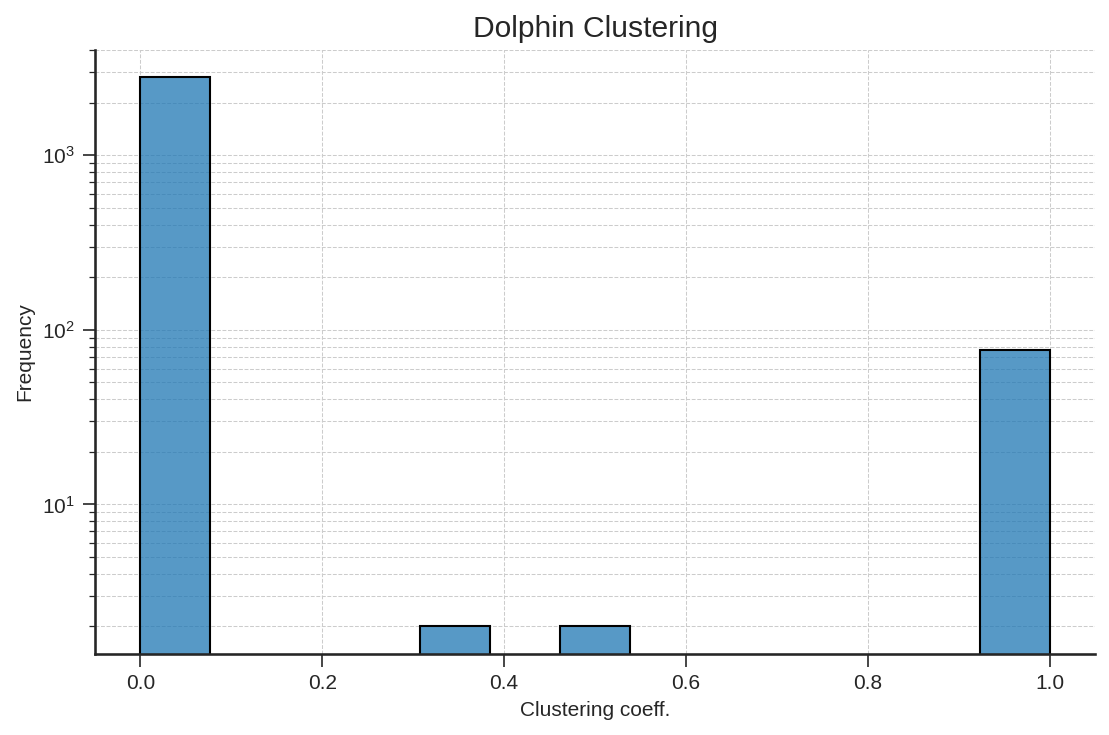

In [59]:
cluster_coeff = nx.clustering(nx_graph)

print(
    "Network Average Clustering Coefficient: {:.5f}".format(
        np.mean(list(cluster_coeff.values()))
    )
)

clust_plt = sns.histplot(x=list(cluster_coeff.values()), bins="auto")
clust_plt.set(yscale="log")
plt.title("Dolphin Clustering")
plt.ylabel("Frequency")
plt.xlabel("Clustering coeff.");


### Betweeness Centrality
- Importance of a node in terms of possible paths through the network
- It is calculated as the fraction of all shortest paths in the network that pass through a node.
- This is important to identify nodes that act as brigdes between separate regions of the network.

#### Implementation Details
- `networkx` module has an inbuilit function `betweenness_centrality` for the that gives us this statistic.

In [60]:
bw_cent = nx.betweenness_centrality(nx_graph)
bw_cent = dict(sorted(bw_cent.items(), key=lambda kv: kv[1], reverse=True))
bw_cent = {node: bnc for node, bnc in bw_cent.items() if bnc > 0.15}

for node, bnc in bw_cent.items():
    print("Node {: 5d} has betweenness Centrality of {:.5f}".format(node, bnc))

Node   603 has betweenness Centrality of 0.54971
Node   288 has betweenness Centrality of 0.46613
Node  1525 has betweenness Centrality of 0.42945
Node   247 has betweenness Centrality of 0.24124
Node     1 has betweenness Centrality of 0.18610


#### Analysis
- We choose a betweeness score of 0.15 as the threshold for a node to be an important central node.
- 5 nodes in the network have a betweeness centrality of more than 0.15 and are considered to be important nodes.

### Assortavity
- Measure of strength of the tendency for nodes to interact with similar other ones.
- Positive values indicate relationships between nodes of similar degrees.
- Negative values indicate relationships between nodes of different degrees.

#### Implementation Details
- `networkx` module has an inbuilit function `degree_assortativity_coefficient` for the that gives us this statistic.

In [61]:
assort_coeff = nx.degree_assortativity_coefficient(nx_graph)
print("The assortavity coefficient of the given network is: {:.5f}".format(assort_coeff))

The assortavity coefficient of the given network is: -0.66821


#### Analysis
- The assortavity coefficient is negative.
- This was expected given the number of leaf nodes. 

## Visualisation

### Implementation Details
- For easier visualisation, we take 100 of the leaf nodes from the graph. This way the shape of the graph is still somewhat maintained while increasing visibility.
- Collect the leaf nodes into a list.
- Shuffle and take the first half of the list as the set to be kept.
- We do not fix the seed here, so as to randomise the nodes kept in the plot and 

In [64]:
import random

# Get leaf nodes
leaf_nodes = list(node_deg_df.loc[node_deg_df['Degree'] == 1, 'Node'])

# Shuffle and remove nodes
random.shuffle(leaf_nodes)
leaf_nodes_to_remove = leaf_nodes[:-1000]
nx_graph1 = nx_graph.copy()
nx_graph1.remove_nodes_from(leaf_nodes_to_remove)

# Plot the graph
layout = nx.spring_layout(nx_graph1)
nx.draw(nx_graph1, pos=layout, alpha=0.5, node_size=20)

NameError: name 'node_deg_df' is not defined

## Conclusions and Learnings

### Conclusions
1. Using information gathered till now, the network can be roughly visualised in the shape of a centipede with central nodes as the body and the leaf nodes as the legs.
1. Most of the nodes are leaf nodes in the graph.
1. The network is not joint and whole.
1. The leaf nodes are connected to a single nearby node and thus form clusters in the network. 
1. There are few highly central and important nodes that keep the network together.


### Learnings
1. Learned network analysis using networkx library
1. Learned to identify important nodes in a graph using statistcs like betweenness centrality.
1. Learned how to visualise networks efficiently

In [63]:
# If facing with memory issues run this cell!

# WARNING: 
# This will effectively reset the jupyter notebook and erase all variables
# and has been provided to refresh the notebook between different tasks.

%reset -f

---
# References

[1] Pandas - https://pandas.pydata.org/docs/

[2] Numpy - https://numpy.org/doc/  

[3] Scikit-learn - https://scikit-learn.org/stable/

[4] Scipy - https://docs.scipy.org/doc/scipy/

[5] Seaborn - https://seaborn.pydata.org/api.html

[6] Plotly - https://plotly.com/python/plotly-express/

[7] NetworkX - https://networkx.org/documentation/stable/index.html

[8] McKinney, W., 2012. Python for data analysis: Data wrangling with Pandas, NumPy, and IPython. " O'Reilly Media, Inc.".

---